# Mini 2: Porous GaN in Space

## Disclaimer

If you are publishing data analysed by this software package please cite: DOI:10.5281/zenodo.1469364

Special thanks go to Duncan Johnstone, Elena Pascal, Paul R. Edwards and Jordi Ferrer-Orri in helping to create this particular analysis File

Code was shared by Armin Barthel to Edward Saunders for use in his Mini 2 NanoDTC project. Edward Saunders extended the code shared to this file.

V3 is a restructured version to make radiation series observations more apparent. There may be some remaining functionality in the script I was given to start with that I have yet to copy over.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
import h5py
import os
from pathlib import Path
from os import walk                       # To get filepaths automatically
from natsort import natsorted             # To easily resort file order
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import pandas as pd

## Data Extraction Functions

Functions to read data

In [2]:
def dat_to_pd(fpath):
    """Read PL data"""
    df = pd.read_csv(fpath, sep=",", header=[22,23]) # meta data is in earlier lines
    return df

def get_subfolders(folder):
    """Function to extract subfolders from a path object folder"""
    subfolders=[]
    _, sfnames,_ = next(os.walk(folder))
    for sfname in sfnames:
        subfolder=folder / sfname
        subfolders.append(subfolder)
    return subfolders

def get_filepaths(folder):
    """Given a folder path, returns a list of the filepaths in the folder as strings in a sorted list"""
    fpaths = []
    _, _, fnames = next(walk(folder)) # ignores other outputs of this
    for fname in fnames:
        fpaths.append(folder/fname)
    # Automatically place into numerical order rather than 1, 10, 11
    fpaths = natsorted(fpaths)
    return fpaths

def CL_1D_signal(data_folder):
    """
    Function to extract CL data from the output files of GaN Group CL proto-type.
    Returns a hyperspy Signal1D object and pixel dimensions. 
    """
    
    file_to_open = data_folder / 'MicroscopeStatus.txt'
    
    """Get values from MicroscopeStatus"""
    
    with open(file_to_open, encoding='windows-1252' ) as status :
        for line in status:
            #if 'Field of view'  in line:
             #   calax = float(line[-9:-4] )    #calax= micro meter per pixel
            if 'Horizontal Binning' in line:
                binning = int(line[line.find(':')+1:-1])        #binning = binning status
            if 'Resolution_X' in line:
                nx = int(line[line.find(':')+1:-8])         #nx = pixel in x-direction
            if 'Resolution_Y' in line:
                ny = int(line[line.find(':')+1:-8])         #ny = pixel in y-direction
            if 'Real Magnification' in line:
                 FOV = float (line[line.find(':')+1:-2])
            if 'Grating - Groove Density:' in line:
                grating = float (line[line.find(':')+1:-7])
            if 'Camera Model:' in line:
                camera = str ((line[line.find(':')+1:-1]))
            if 'Central wavelength:' in line:
                centrelambda = float (line[line.find(':')+1:-3])
                
    
    if camera == 'A.920' :
        ch = 1024//binning
        Ebert = 21.2 # Ebert Angle in degree from Horiba website
        lccd = 26.7 # CCD width in mm from Andor Specsheet
        flength = 319.76001 #focal length in mm from horiba specsheet
        gamma = -3.5 #in degree
        lH = flength*np.cos(gamma/180*np.pi)
        hblcentre = flength*np.sin(gamma/180*np.pi)

        alpha = np.arcsin((10**(-6)*grating*centrelambda)/(2*np.cos((Ebert/(2*180))*np.pi)))/np.pi*180-Ebert/2 
        beta = Ebert+alpha

        betamin = beta + gamma - np.arctan((((lccd/ch)  * (ch - ch/2) + hblcentre)/lH))*180/np.pi
        lambdamin = ((np.sin(alpha/180*np.pi)+np.sin(betamin/180*np.pi))*10**6)/grating

        betamax = beta + gamma - np.arctan((((lccd/ch)  * (1 - ch/2) + hblcentre)/lH))*180/np.pi
        lambdamax = ((np.sin(alpha/180*np.pi)+np.sin(betamax/180*np.pi))*10**6)/grating

        if grating == 150 :
            corrfactor = 2.73E-04
        elif grating == 600 :
            corrfactor = 6.693659836087227e-05
        elif grating == 1200 :
            corrfactor = 3.7879942917985216e-05
        else :
            print('Something went wrong')
    
    elif camera =='A.(IR)490' :
        ch = 512//binning
        Ebert = -11.6348 # Ebert Angle in degree from Horiba website
        lccd = 12.8 # CCD width in mm from Andor Specsheet
        flength = 326.7 #focal length in mm from horiba specsheet
        gamma = -4.8088 #in degree
        lH = flength*np.cos(gamma/180*np.pi)
        hblcentre = flength*np.sin(gamma/180*np.pi)

        alpha = np.arcsin((10**(-6)*grating*centrelambda)/(2*np.cos((Ebert/(2*180))*np.pi)))/np.pi*180-Ebert/2 
        beta = Ebert+alpha

        betamin = beta + gamma - np.arctan((((lccd/ch)  * (ch - ch/2) + hblcentre)/lH))*180/np.pi
        lambdamin = ((np.sin(alpha/180*np.pi)+np.sin(betamin/180*np.pi))*10**6)/grating

        betamax = beta + gamma - np.arctan((((lccd/ch)  * (1 - ch/2) + hblcentre)/lH))*180/np.pi
        lambdamax = ((np.sin(alpha/180*np.pi)+np.sin(betamax/180*np.pi))*10**6)/grating

        if grating == 150 :
            corrfactor = 2.73E-04
        else :
            print('Something went wrong')
    
    
    else :
        print('Dont know that camera')
        
    """Load data into numpy array and make into hs object"""
        
    filename = data_folder / 'HYPCard.bin'
    with open(filename, 'rb') as f:    
        data = np.fromfile(f, dtype= [('bar', '<i4')], count= ch*nx*ny)
        #data = np.fromfile(f, count= 1024*nx*ny)
        array = np.reshape(data, [ch, nx, ny], order='F')

    sarray = np.swapaxes(array, 1,2) # Swap Axes for proper x-y use

    suncor = hs.signals.Signal2D(sarray).T
    suncor.change_dtype('float')
    
    """Define axes"""
    x = suncor.axes_manager.navigation_axes[0]
    y = suncor.axes_manager.navigation_axes[1]

    calax = 131072/(FOV*nx)

    x.name = 'x'
    x.scale = calax * 1000         #changes micrometer to nm, value for the size of 1 pixel
    x.units = 'nm'

    y.name = 'y'
    y.scale = calax * 1000      #changes micrometer to nm, value for the size of 1 pixel
    y.units = 'nm'

    dx = suncor.axes_manager.signal_axes[0]

    dx.name = 'wavelength'
    dx.scale = ((lambdamax-lambdamin)/ch)
    dx.offset = lambdamin
    dx.units = '$nm$'
    
    """Background correction""" # Needs background to be collected, doesn't automatically remove background from signal when collect data.
    background_filepath = data_folder / 'BKG1.txt'
    
    # official background removal
    if os.path.exists(background_filepath):
        bkg = np.loadtxt(background_filepath, skiprows = 1)
        bkgarray =np.ones((nx,ny, len(bkg)))*bkg
        s = suncor - bkgarray
    else:
        s = suncor
        
    """Correction of wavelength shift along the x axis""" # necessary correction required, some detail associated with the grating
    garray=np.arange((-corrfactor/2) * calax * 1000 * (nx), (corrfactor/2) * calax * 1000 * (nx), corrfactor *calax * 1000) #(Total Variation, Channels, Step)
    barray = np.full((nx,ny),garray)
    s.shift1D(barray)
    
    return s

## PL Data

PL_data class to store information in convenient form.

In [3]:
class PL_data:
    """
    Class used to contain the data and some methods associated with a CL map.
    Assignment of several attributes relating to material sample are only assigned if the information is in the folder name and this is case sensitive e.g. 500nmhvhe.
    """
    def __init__(self, data_folder):
        ### Extract name
        self.folder_path = data_folder
        f_name = str(data_folder) # should come up with something better later probably but have made folder the name
        self.name = f_name[::-1][:f_name[::-1].index("\\")][::-1]
        
        ### Extract PL data
        PL_data=[]
        for fpath in get_filepaths(PL_sample):
            fpath=str(fpath)
            if fpath[::-1][:fpath[::-1].index("\\")][::-1][:9] == "pointspec": # because I have other files from PL in PL folders
                PL_data.append(dat_to_pd(fpath))
        df = pd.concat(tuple(PL_data))
        df = df.sort_values(by=[df.columns[0]], axis= "index", ascending=True) # sort by wavelength
        self.PL_df = df
        
        
        
        ### Meta data I haven't learnt to/can't extract properly yet 
        
        # porous_thickness units are nm
        if "t" in self.name:
            self.porous_thickness = 0.0 
        elif "500nm" in self.name:
            self.porous_thickness = 500.0 
        elif "200nm" in self.name:
            self.porous_thickness = 200.0
        elif "100nm" in self.name:
            self.porous_thickness = 100.0
        else:
            self.porous_thickness = np.NaN
        
        # proton fluence is in units of cm^-2
        if "ne" in self.name or "t0" in self.name:
            self.proton_fluence = 0.0
        if "le" in self.name or "t1" in self.name:
            self.proton_fluence = 1e14
        if "he" in self.name or "t2" in self.name:
            self.proton_fluence = 1e15

        # nominal voltage of etch different from measured
        if "nv" in self.name or "t" in self.name:
            self.etch_volt = 0
        if "lv" in self.name:
            self.etch_volt = 8
        if "hv" in self.name:
            self.etch_volt = 10
        

Select folder for PL data and extract spectra.

In [4]:
PL_folder = Path("C:/Users/es758/OneDrive - University of Cambridge/NanoDTC/Mini 2/PL/080322")

PL_samples = []
for PL_sample in get_subfolders(PL_folder):
    PL_samples.append(PL_data(PL_sample))

Sort into pandas df.

In [5]:
structure = {
    "Fluence": [0.0, 1e14, 1e15]
    
}

PL_spectra_df = pd.DataFrame(structure)
for sample in PL_samples:
    PL_spectra_df.loc[PL_spectra_df.index[PL_spectra_df["Fluence"]==sample.proton_fluence][0],str(int(sample.porous_thickness)) + " nm " + str(sample.etch_volt)+ " V"] = sample

PL_spectra_df

Fluence                                      500 nm 10 V  \
0  0.000000e+00  <__main__.PL_data object at 0x000002B488245D30>   
1  1.000000e+14  <__main__.PL_data object at 0x000002B488253130>   
2  1.000000e+15  <__main__.PL_data object at 0x000002B494F8AD30>   

                                        500 nm 8 V  \
0  <__main__.PL_data object at 0x000002B494F8AF70>   
1  <__main__.PL_data object at 0x000002B48824D820>   
2  <__main__.PL_data object at 0x000002B4882538B0>   

                                        500 nm 0 V  \
0  <__main__.PL_data object at 0x000002B494FE1A00>   
1                                              NaN   
2                                              NaN   

                                          0 nm 0 V  
0  <__main__.PL_data object at 0x000002B488258400>  
1  <__main__.PL_data object at 0x000002B494F8AF10>  
2  <__main__.PL_data object at 0x000002B488299AF0>

### PL Spectra

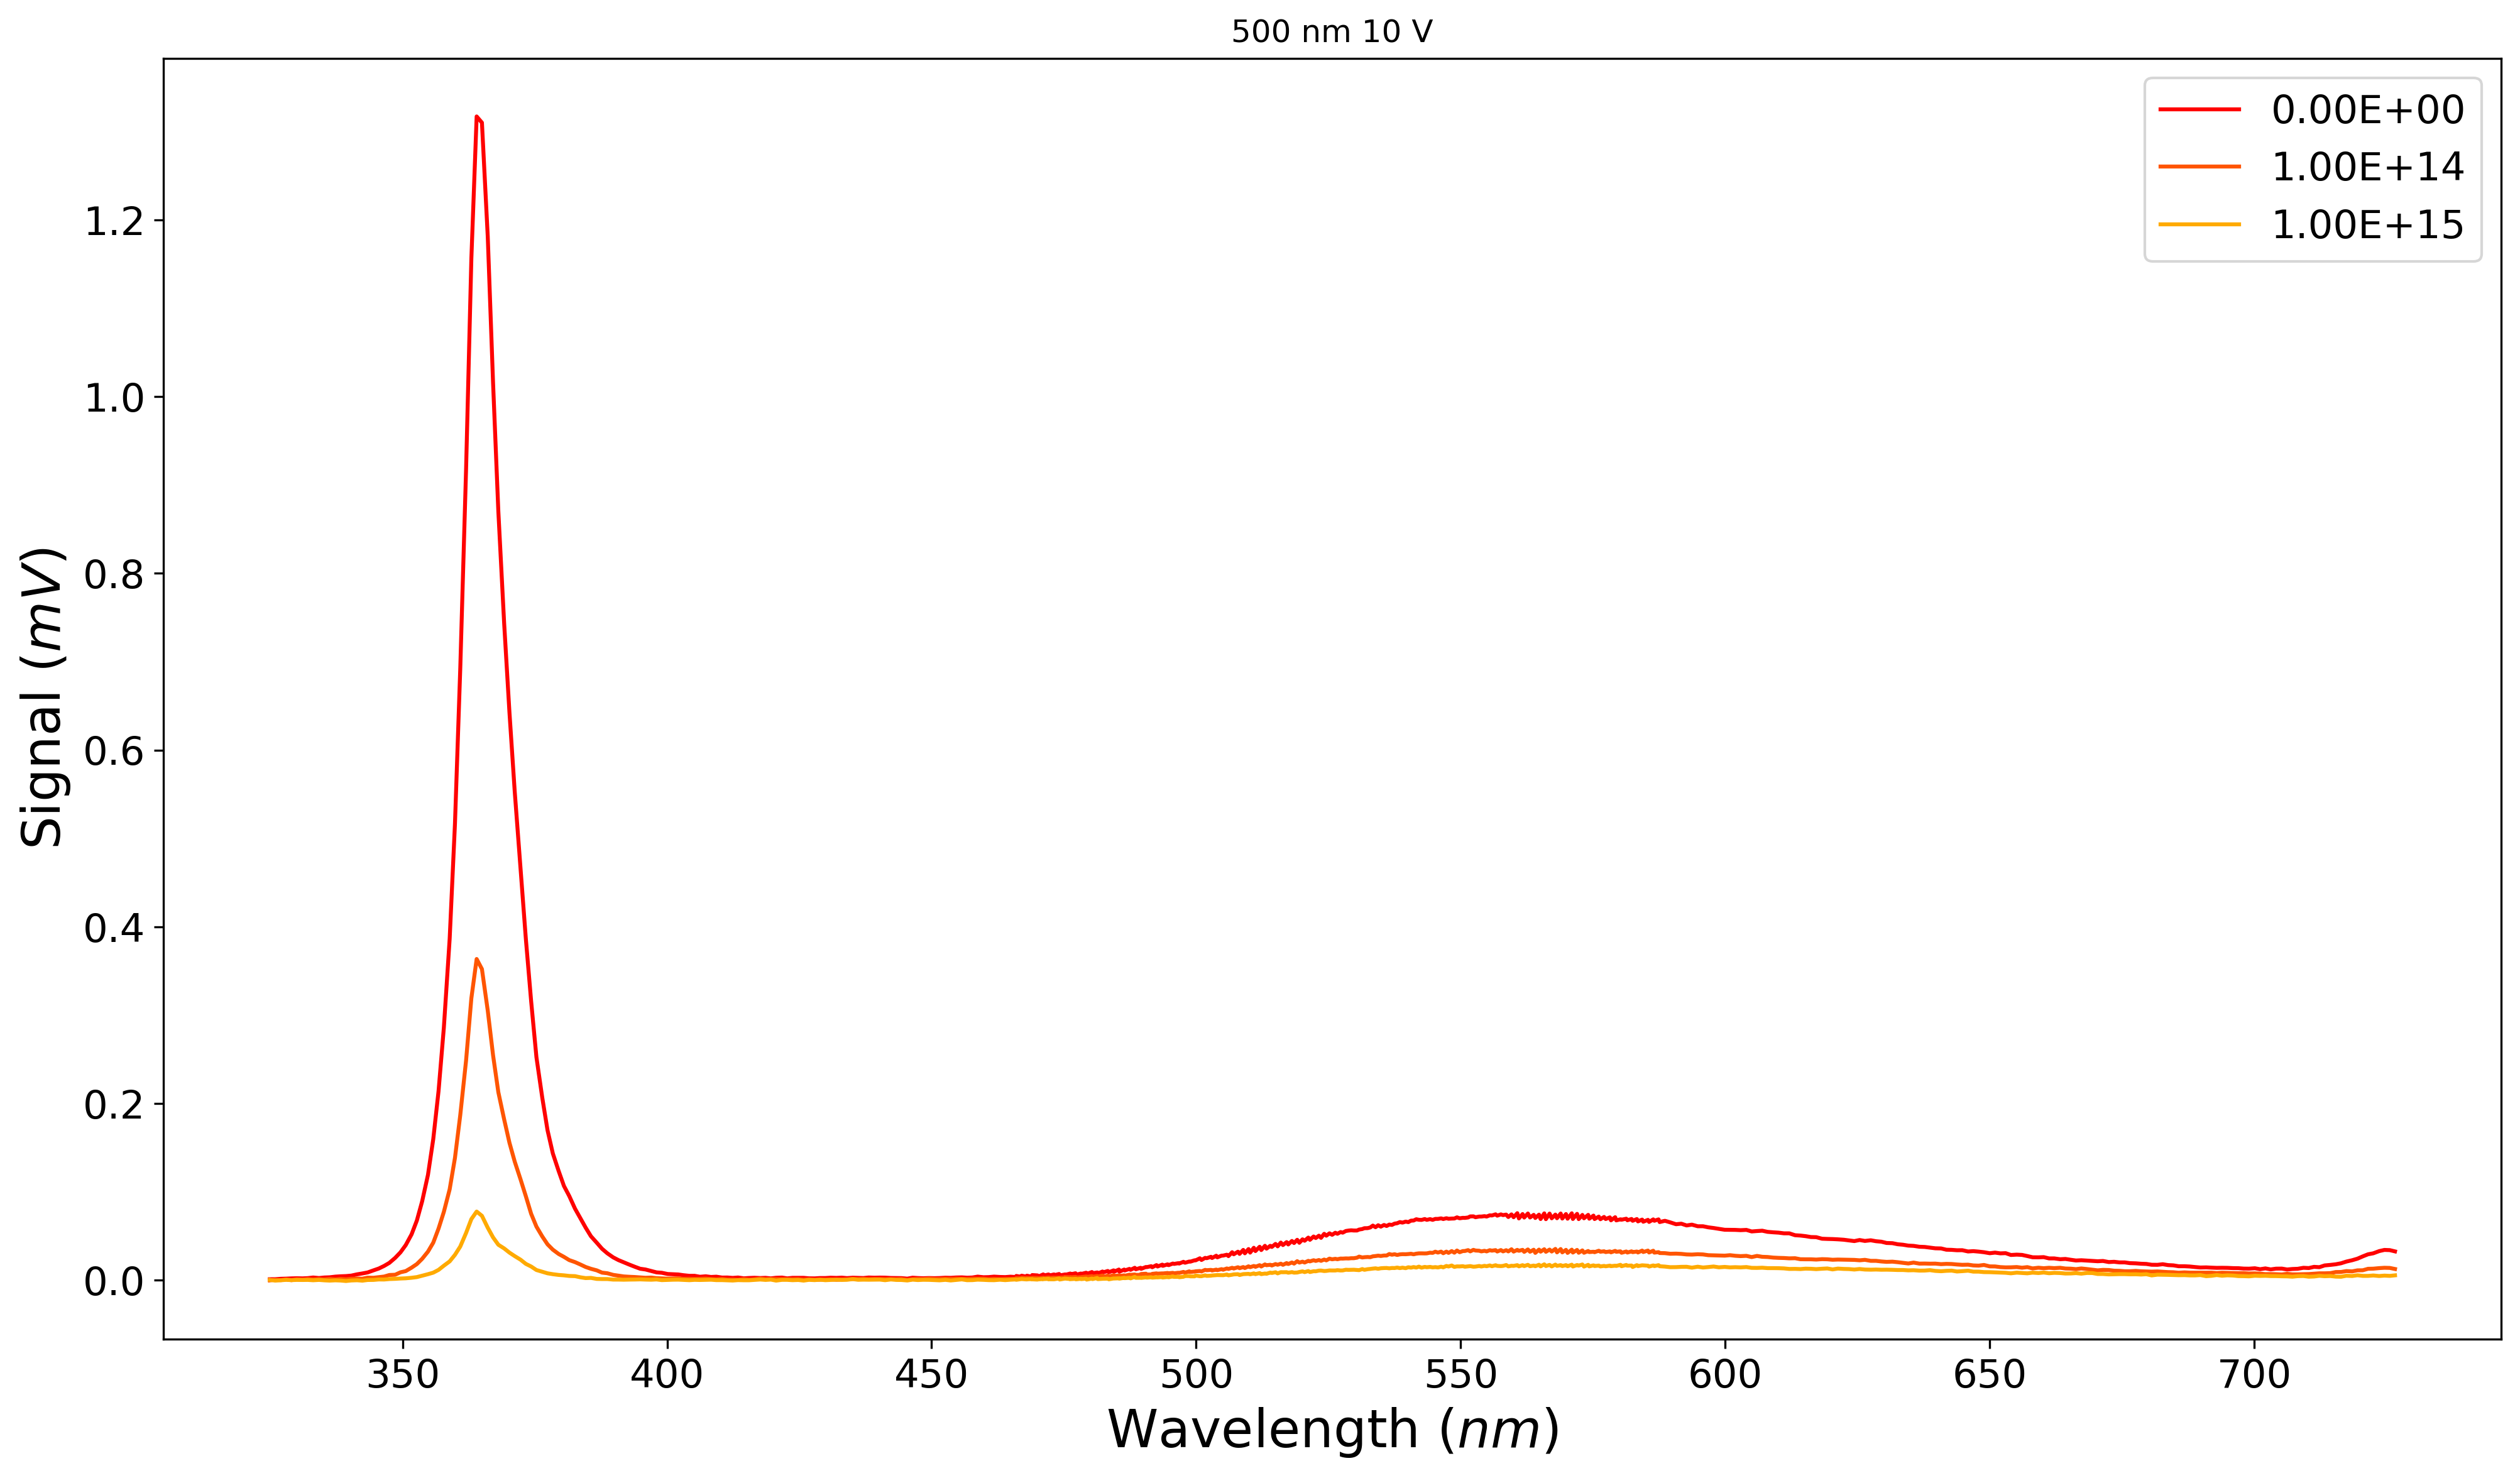

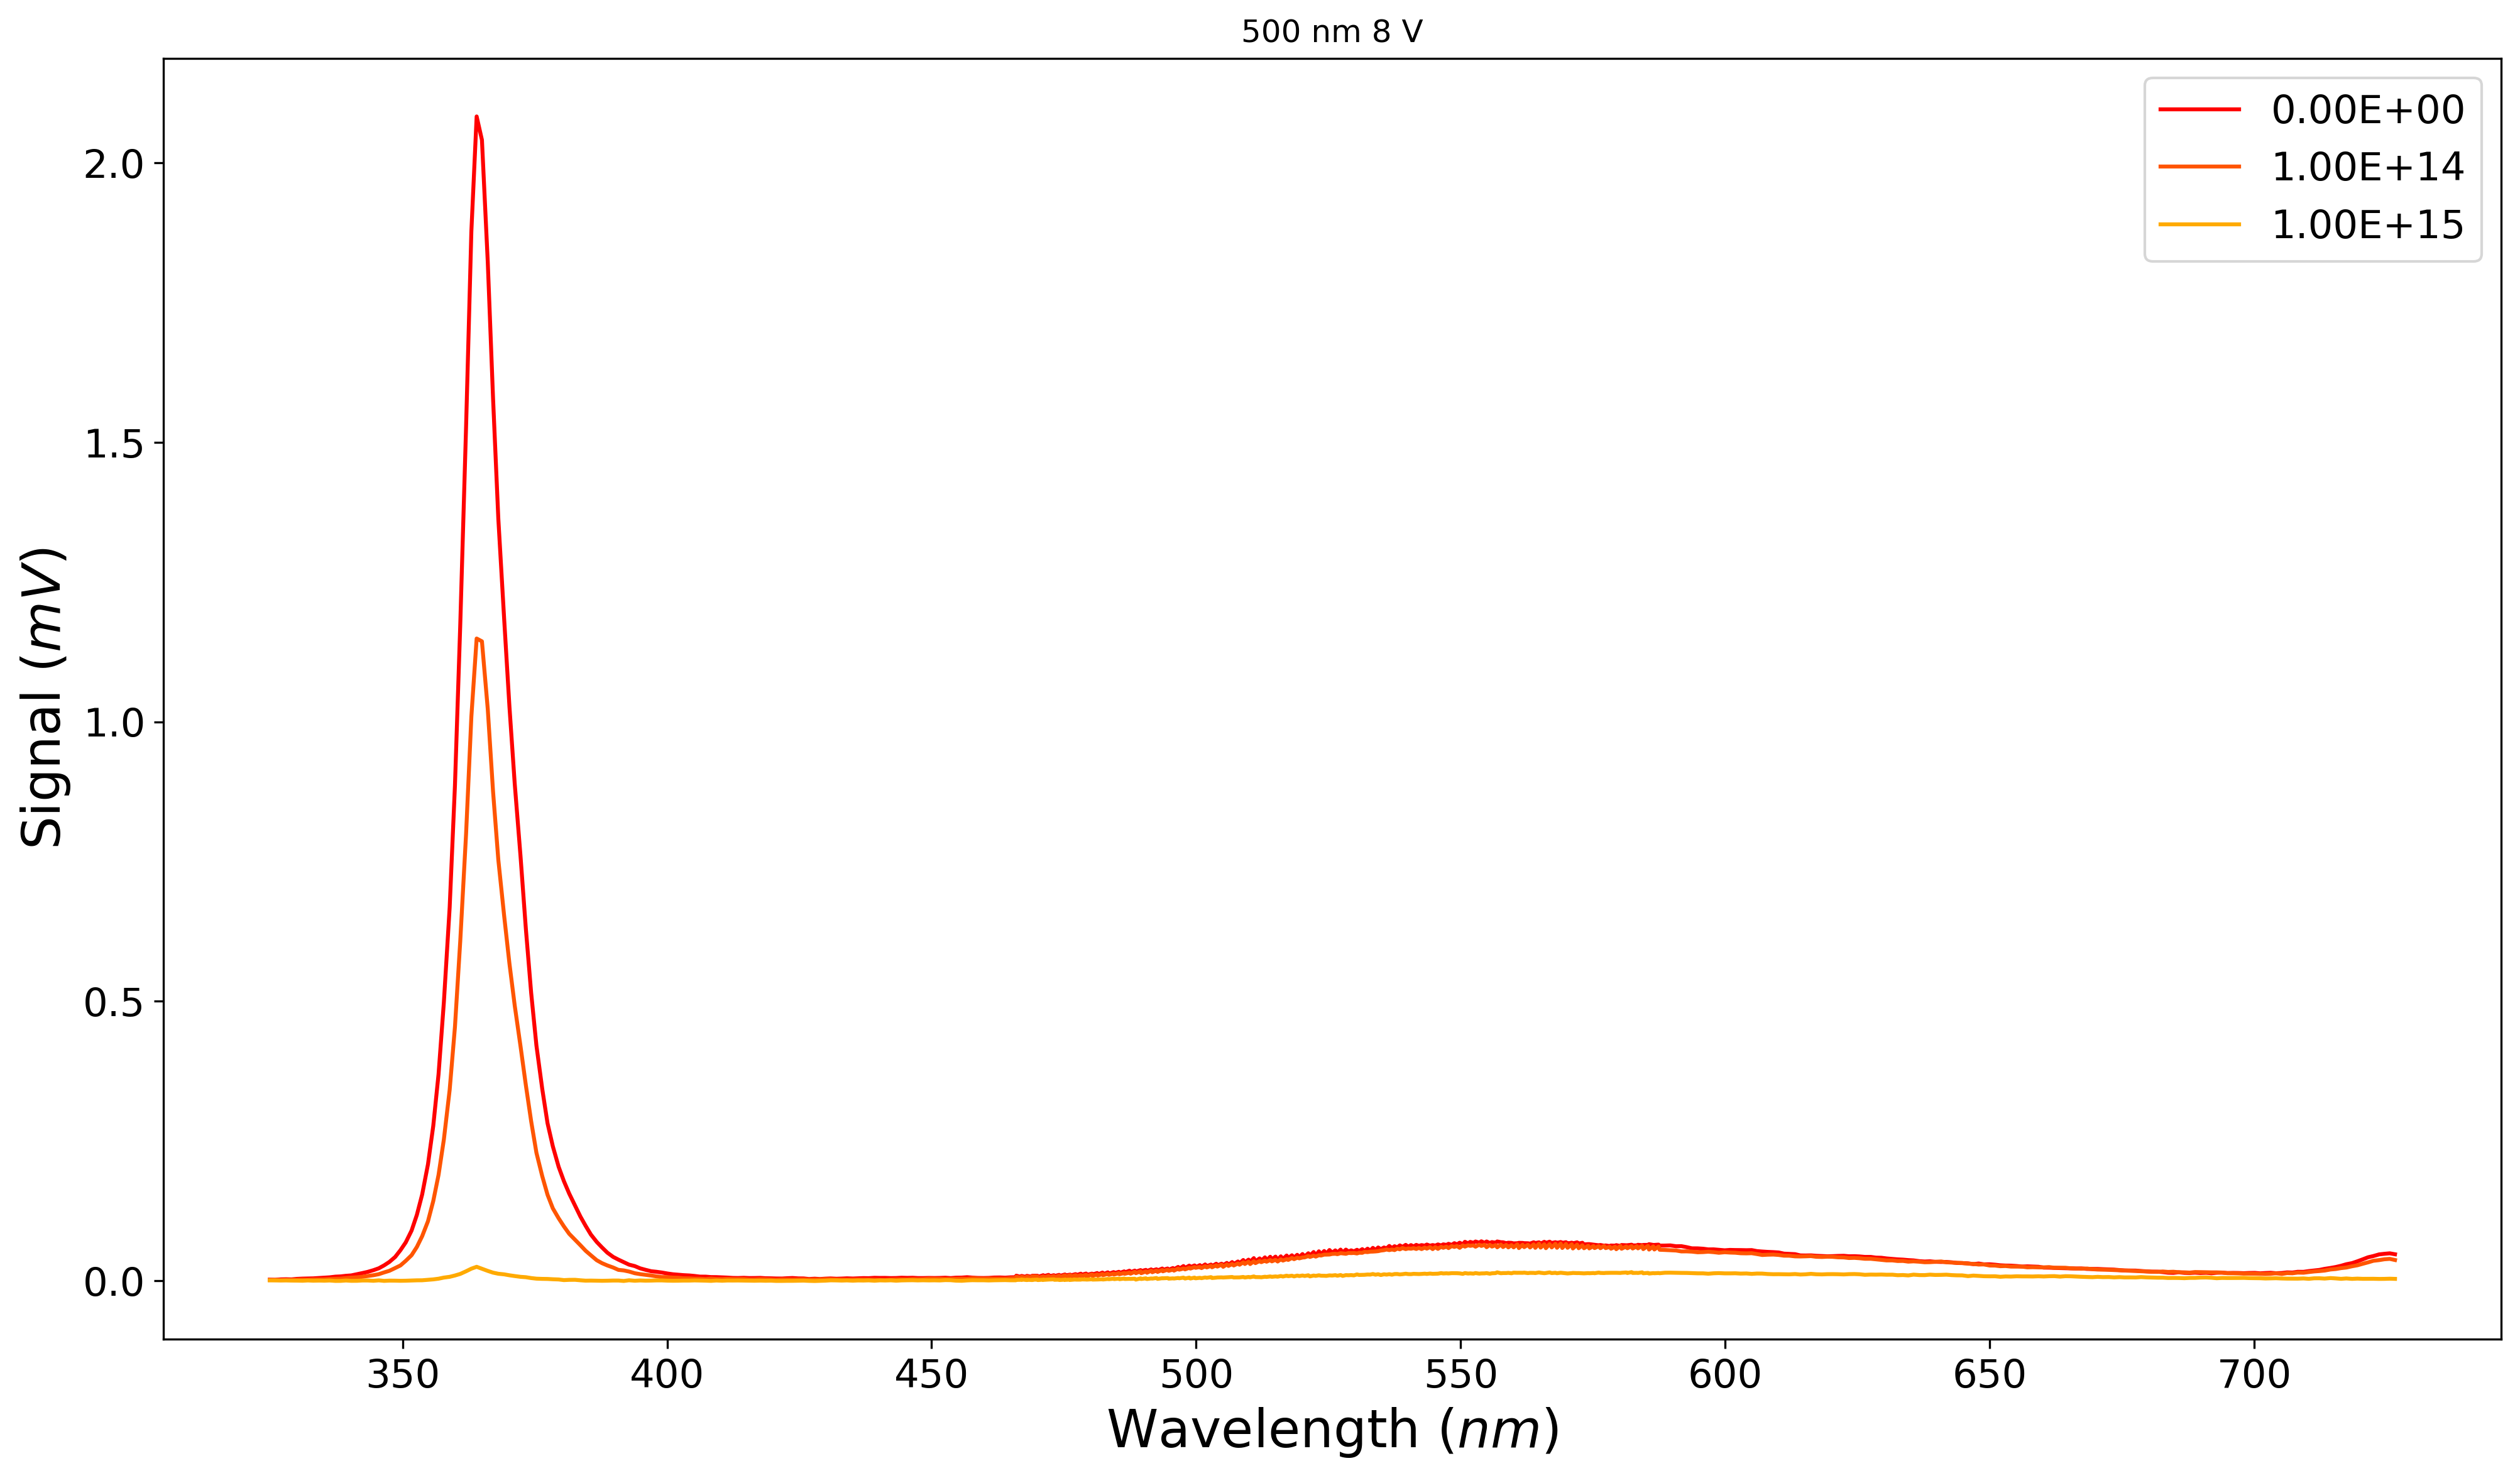

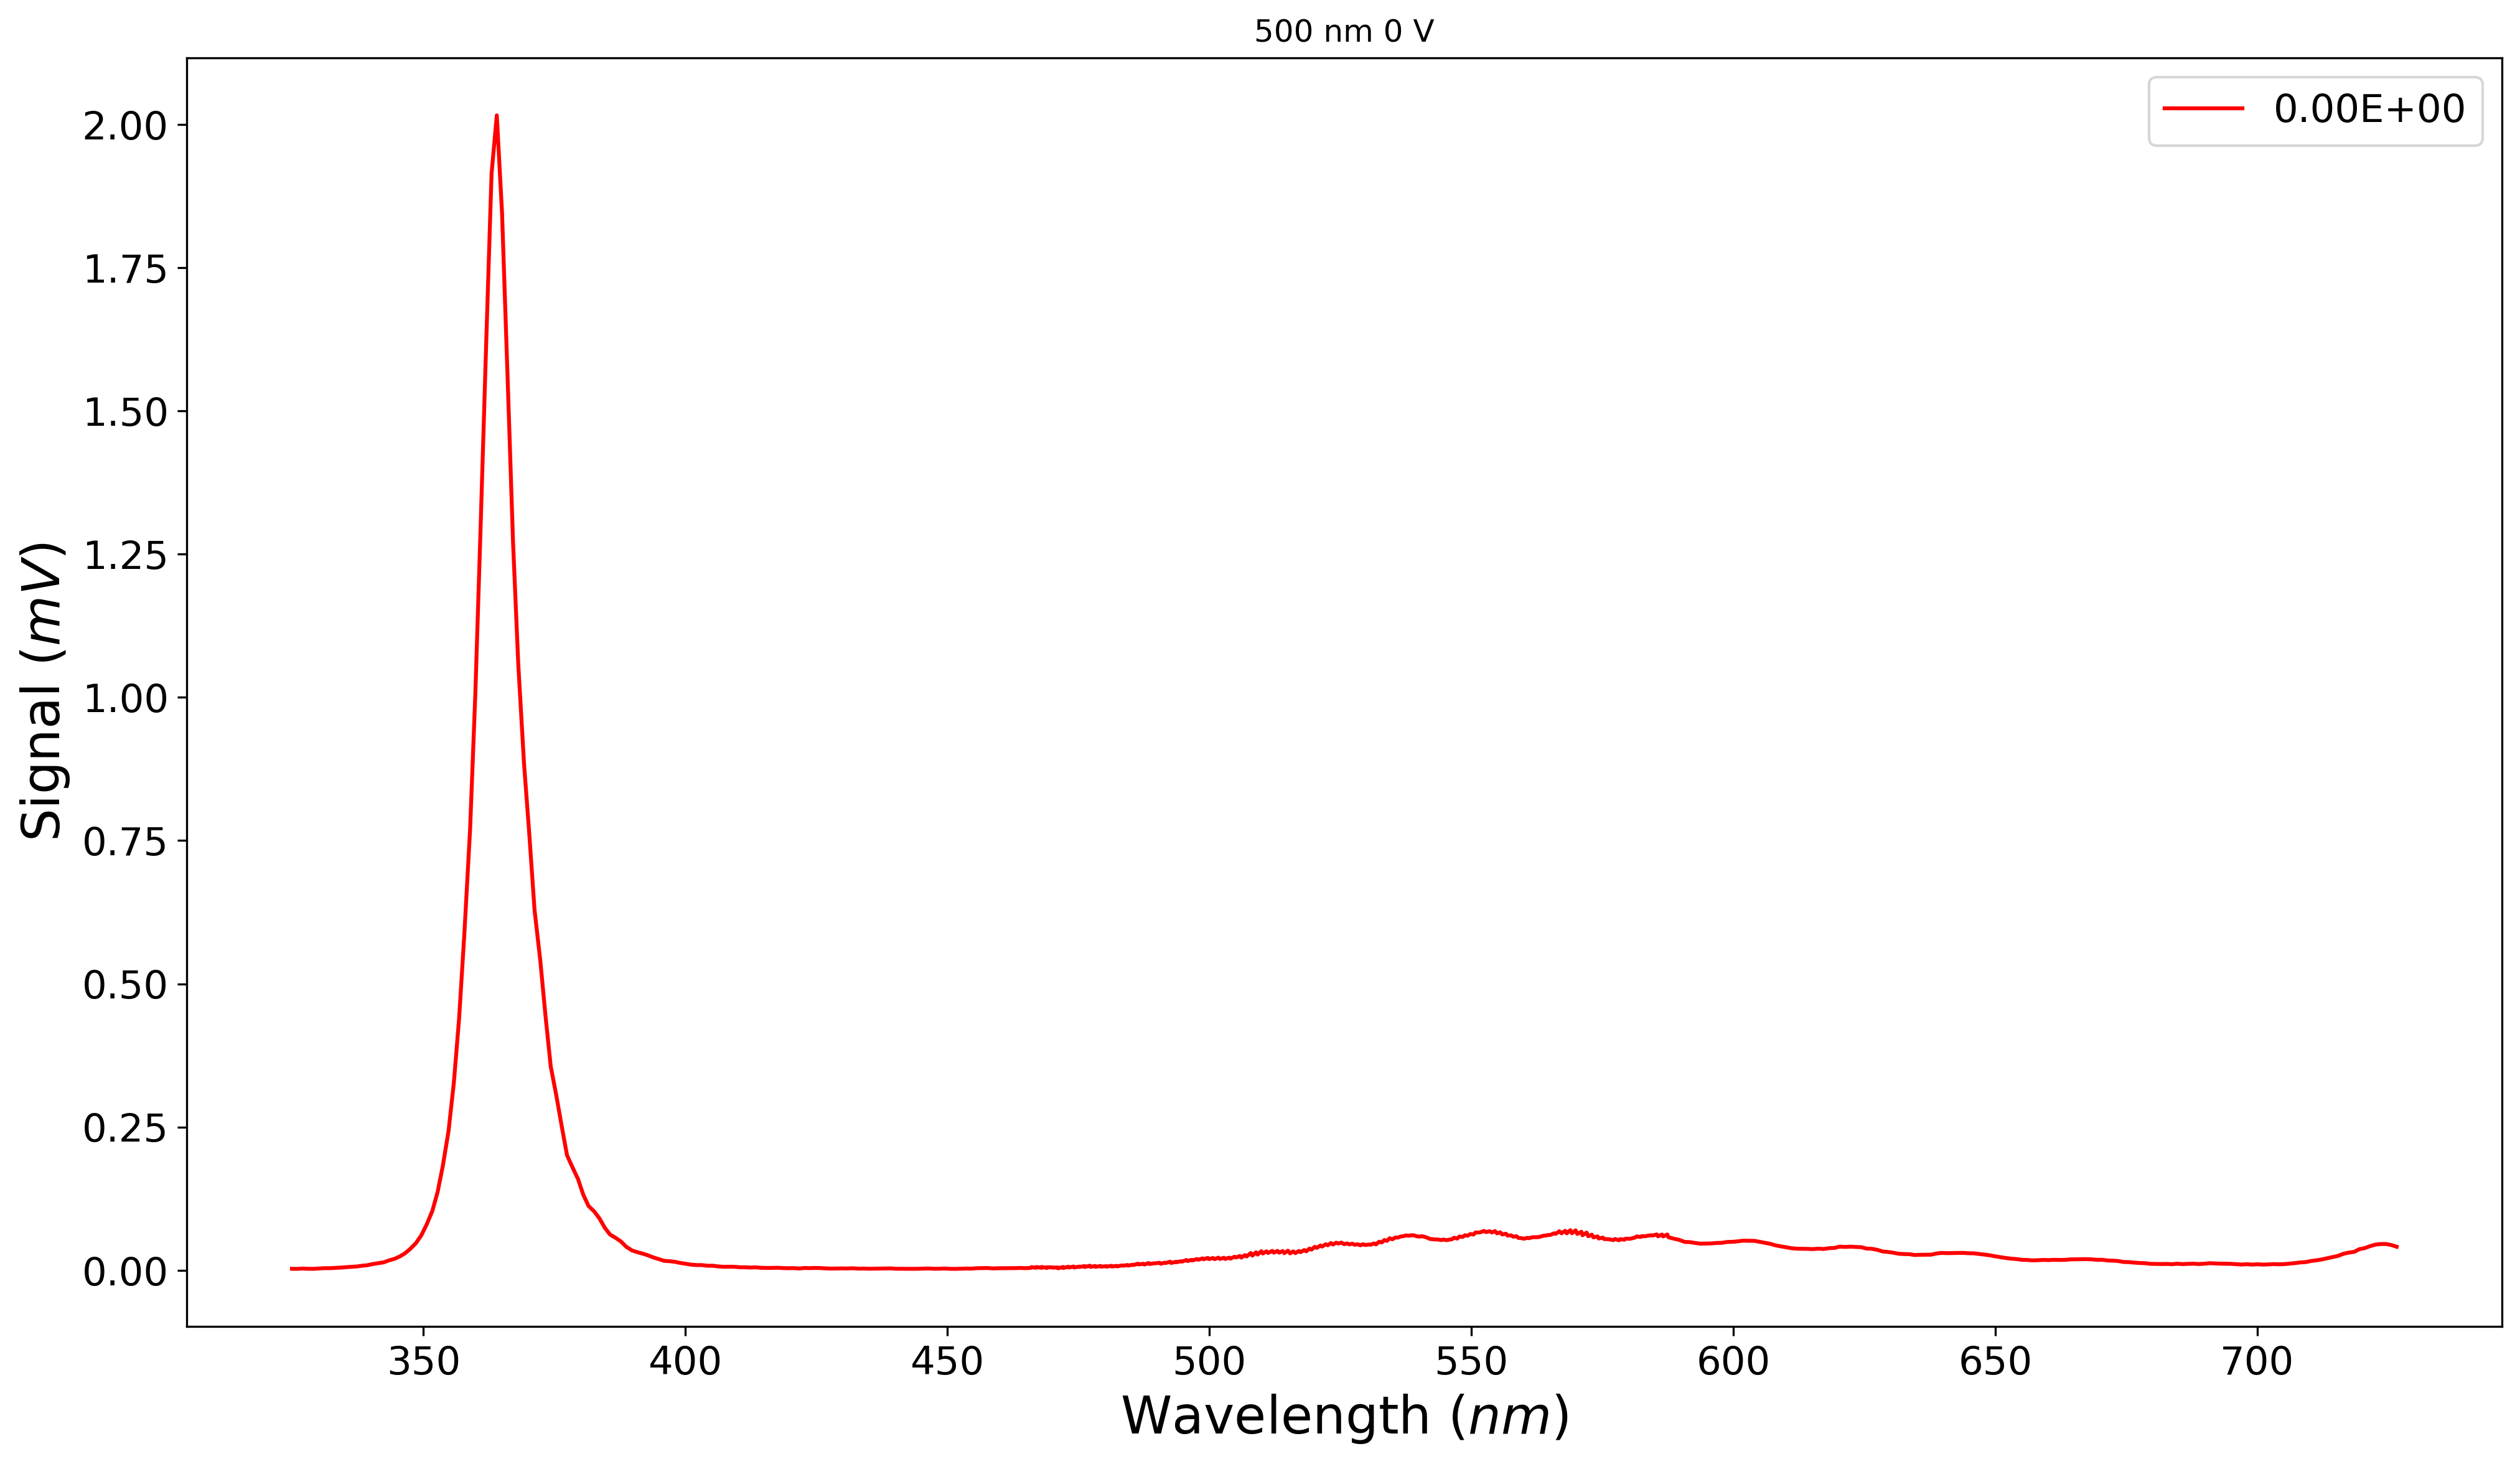

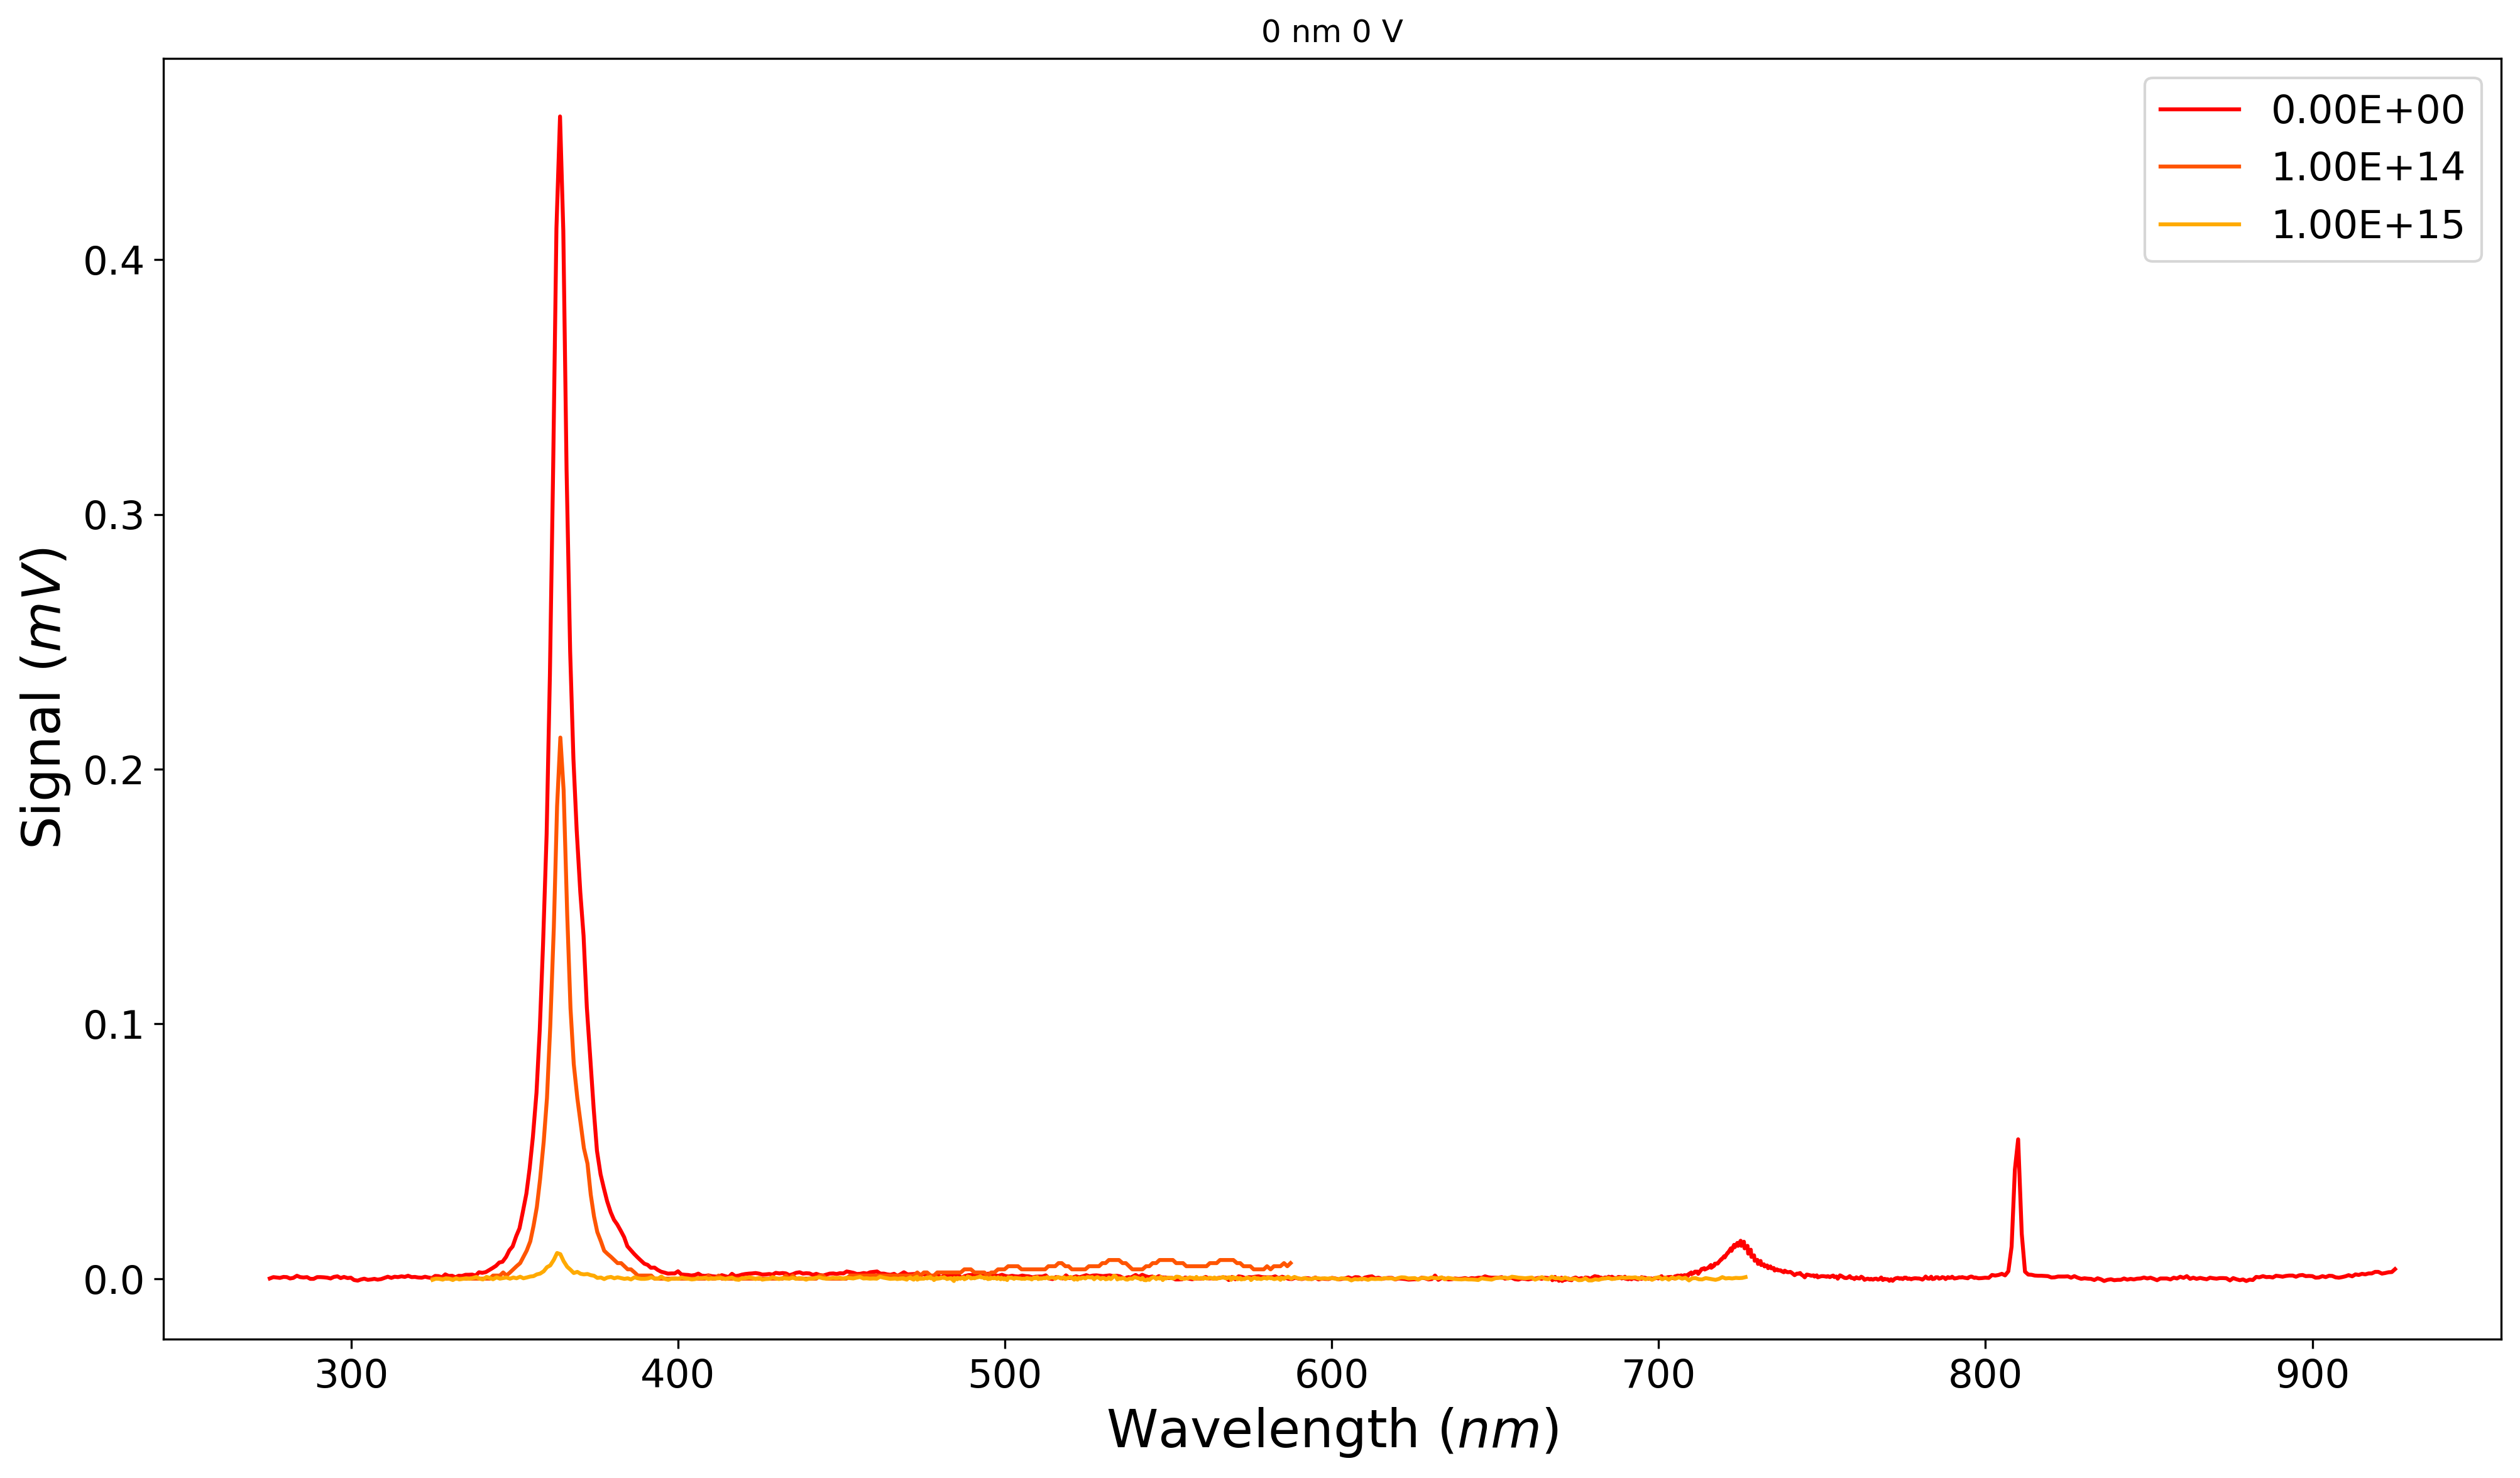

In [9]:
%matplotlib inline

fg_size = (16,9)
fg_dpi = 300
ax_fsize = 20
tick_fsize = 15
leg_fsize = 15

structure = {
    "Fluence": [0.0, 1e14, 1e15]
    
}

peak_values_df = pd.DataFrame(structure)
yellow_peak_values_df = pd.DataFrame(structure)

# iterate over columns
for structure in PL_spectra_df.columns:
    
    # skip Fluence column
    if structure == 'Fluence':
        continue
        
    # initialise some plot stuff
    fig = plt.figure(num = structure + " PL Spectra at 3 Fluence Levels", figsize = fg_size, dpi = fg_dpi)
    ax = fig.add_subplot(1,1,1)
    line_styles = ["-", ":"]
    
    index_counter = 0
    
    # iterate over entries in column
    for PL_spectra in PL_spectra_df[structure]:

        # handle found data
        if type(PL_spectra) == type(PL_spectra_df[structure][0]): # will always have at least a 0 exposed sample
            
            # do stuff
            wavelengths = np.array(PL_spectra.PL_df[PL_spectra.PL_df.columns[0]])
            signal = np.array(PL_spectra.PL_df[PL_spectra.PL_df.columns[1]])
            
            # find 500 nm and 600 nm indices
            for lam_idx in np.arange(len(wavelengths)):
                if wavelengths[lam_idx] > 500:
                    idx_500nm = lam_idx
                    break
            for lam_idx in np.arange(len(wavelengths)):
                if wavelengths[lam_idx] > 600:
                    idx_600nm = lam_idx
                    break
            
            # plot spectra
            cmap = plt.cm.get_cmap('autumn') # use any colormap you like
            
            df_index = index_counter
            
            col = cmap(df_index/len(PL_spectra_df))
            
            ax.plot(wavelengths, signal, linestyle = line_styles[0], color = col, label = f"{PL_spectra_df[structure][df_index].proton_fluence:.2E}" )
            
            # store peak values
            max_p = np.max(signal)
            max_p_yellow = np.max(signal[idx_500nm:idx_600nm])

            peak_values_df.loc[df_index,structure] = max_p
            
            yellow_peak_values_df.loc[df_index,structure] = max_p_yellow
            

             
        # handle nans
        elif np.isnan(PL_spectra):
            continue
        
        index_counter += 1
    ax.set_title(structure)
    ax.set_xlabel("Wavelength ($nm$)", fontsize=ax_fsize)
    ax.set_ylabel("Signal ($mV$)", fontsize=ax_fsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fsize)
    ax.tick_params(axis='both', which='minor', labelsize=tick_fsize)
    ax.legend(loc="best", fontsize=leg_fsize)
    #fig.savefig(structure+" PL.png",bbox_inches="tight")

### Peak Analysis

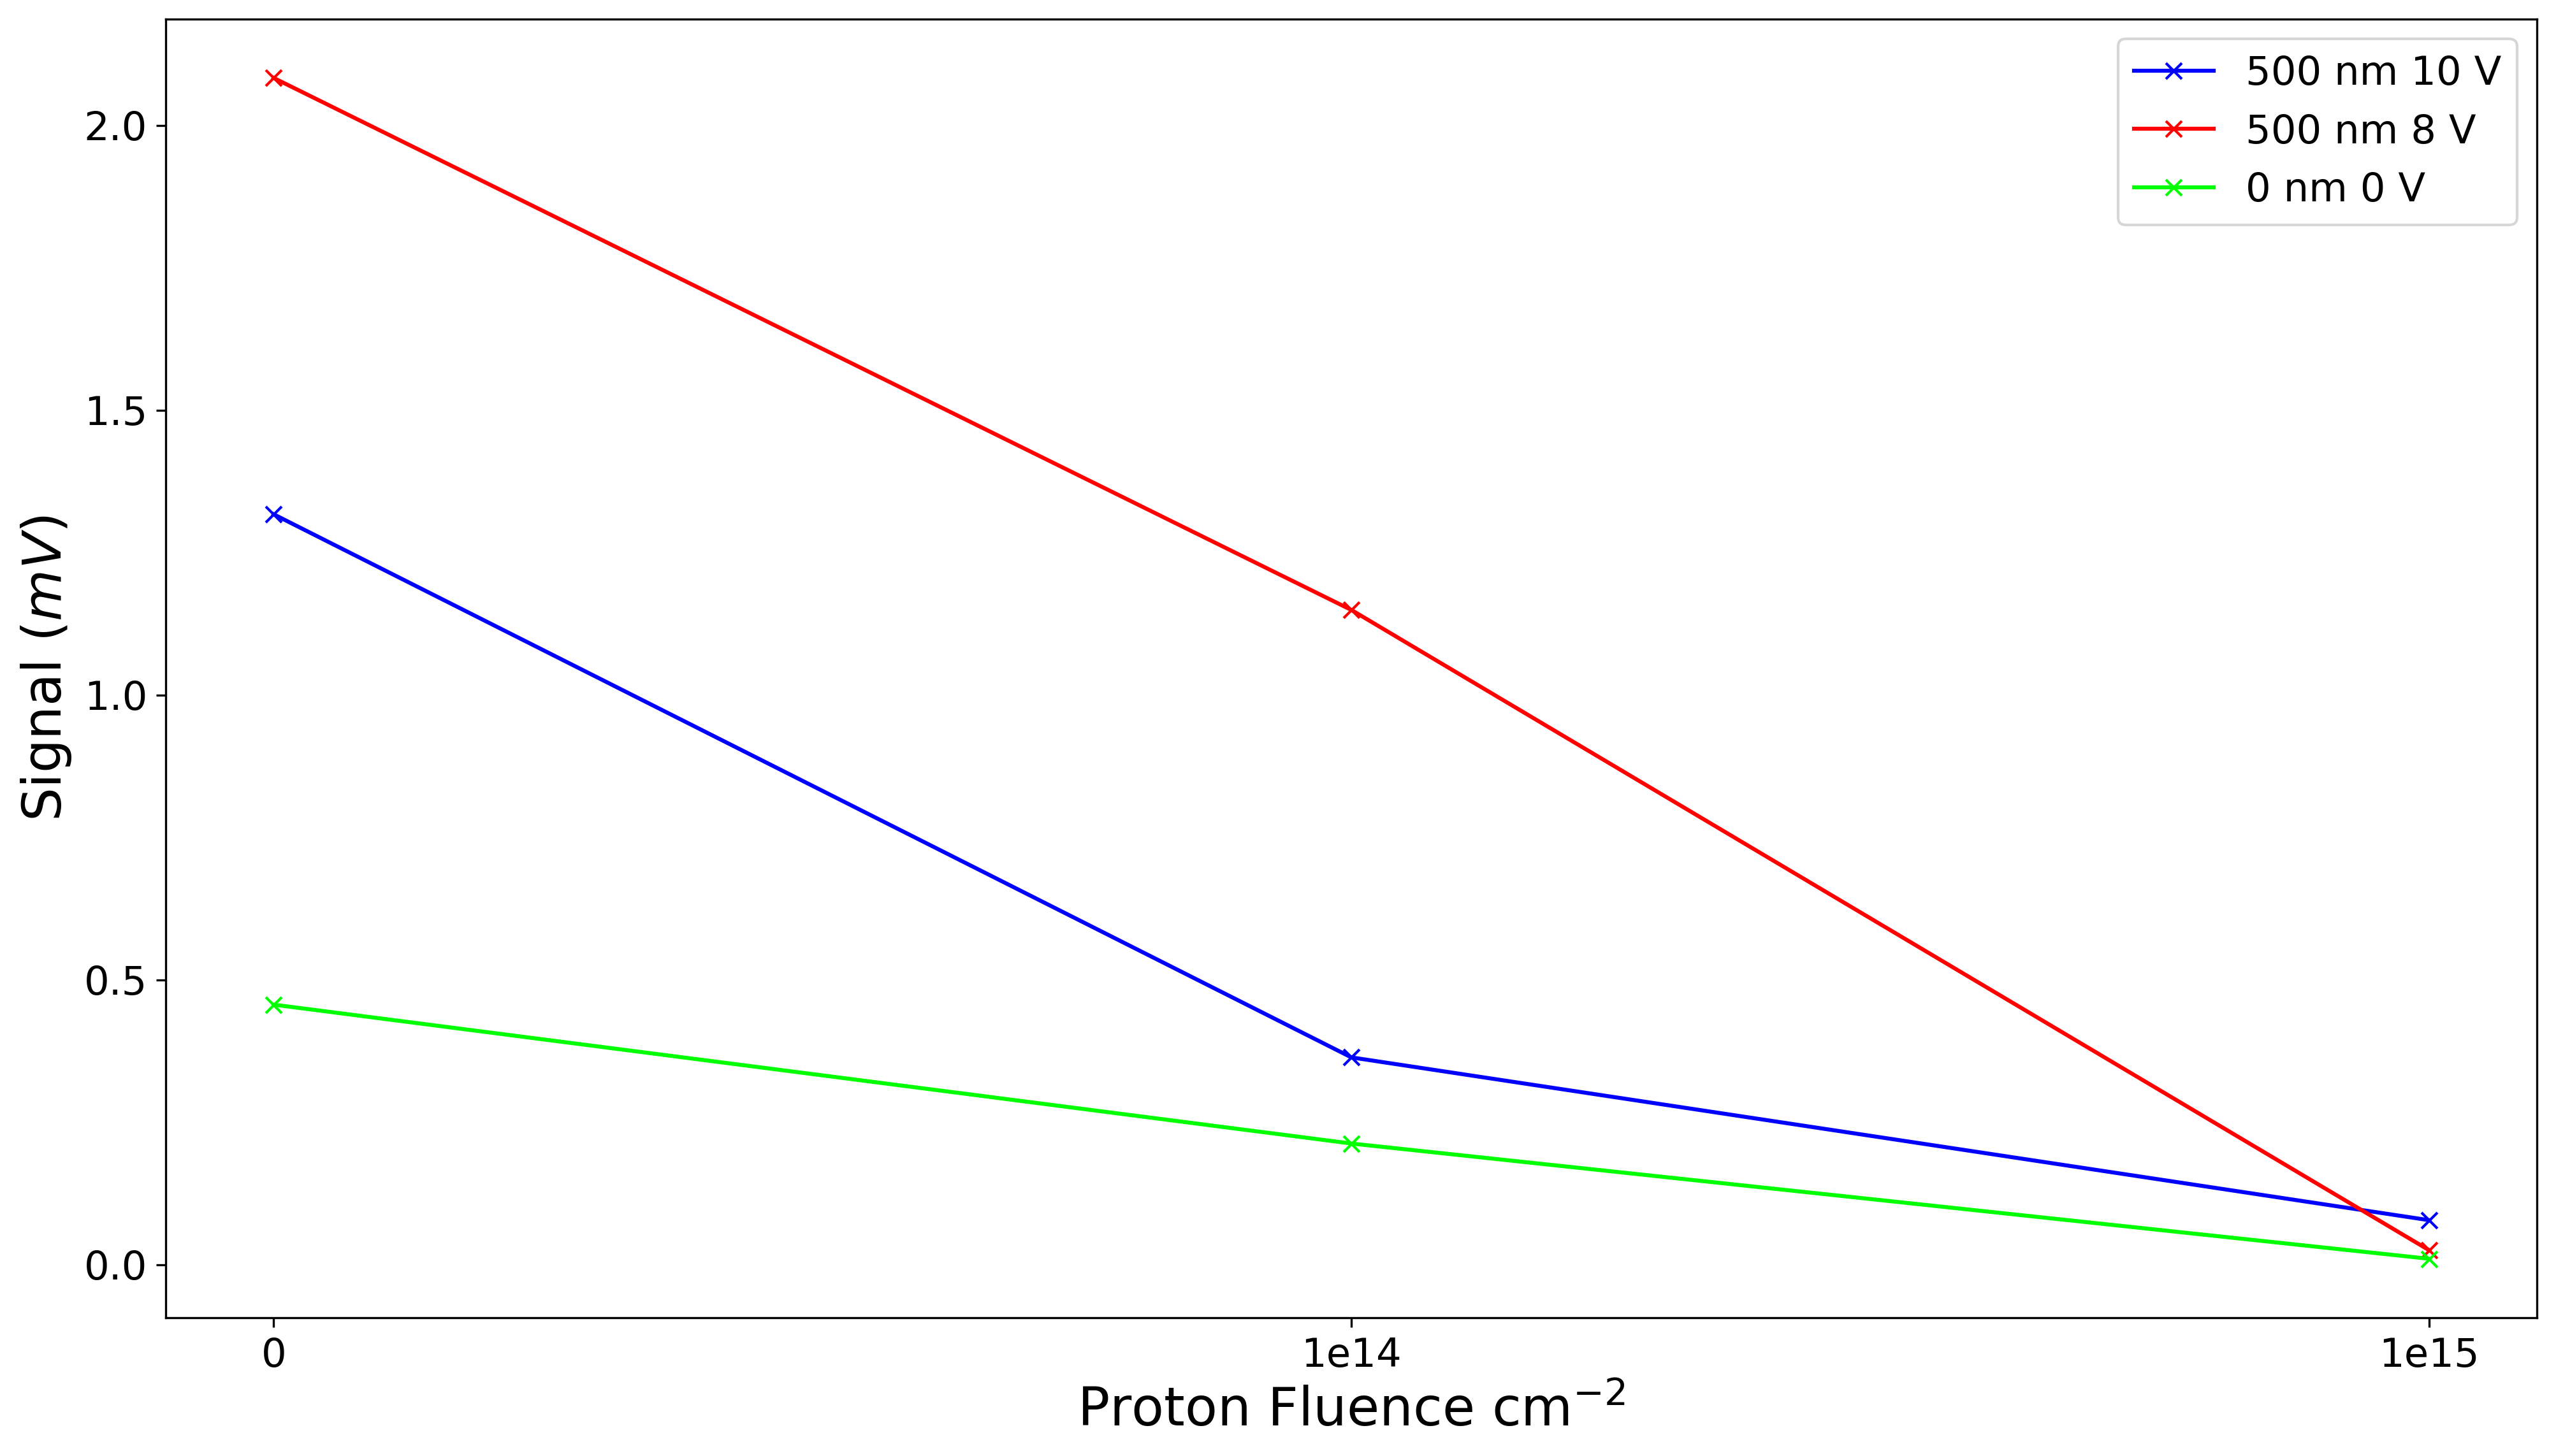

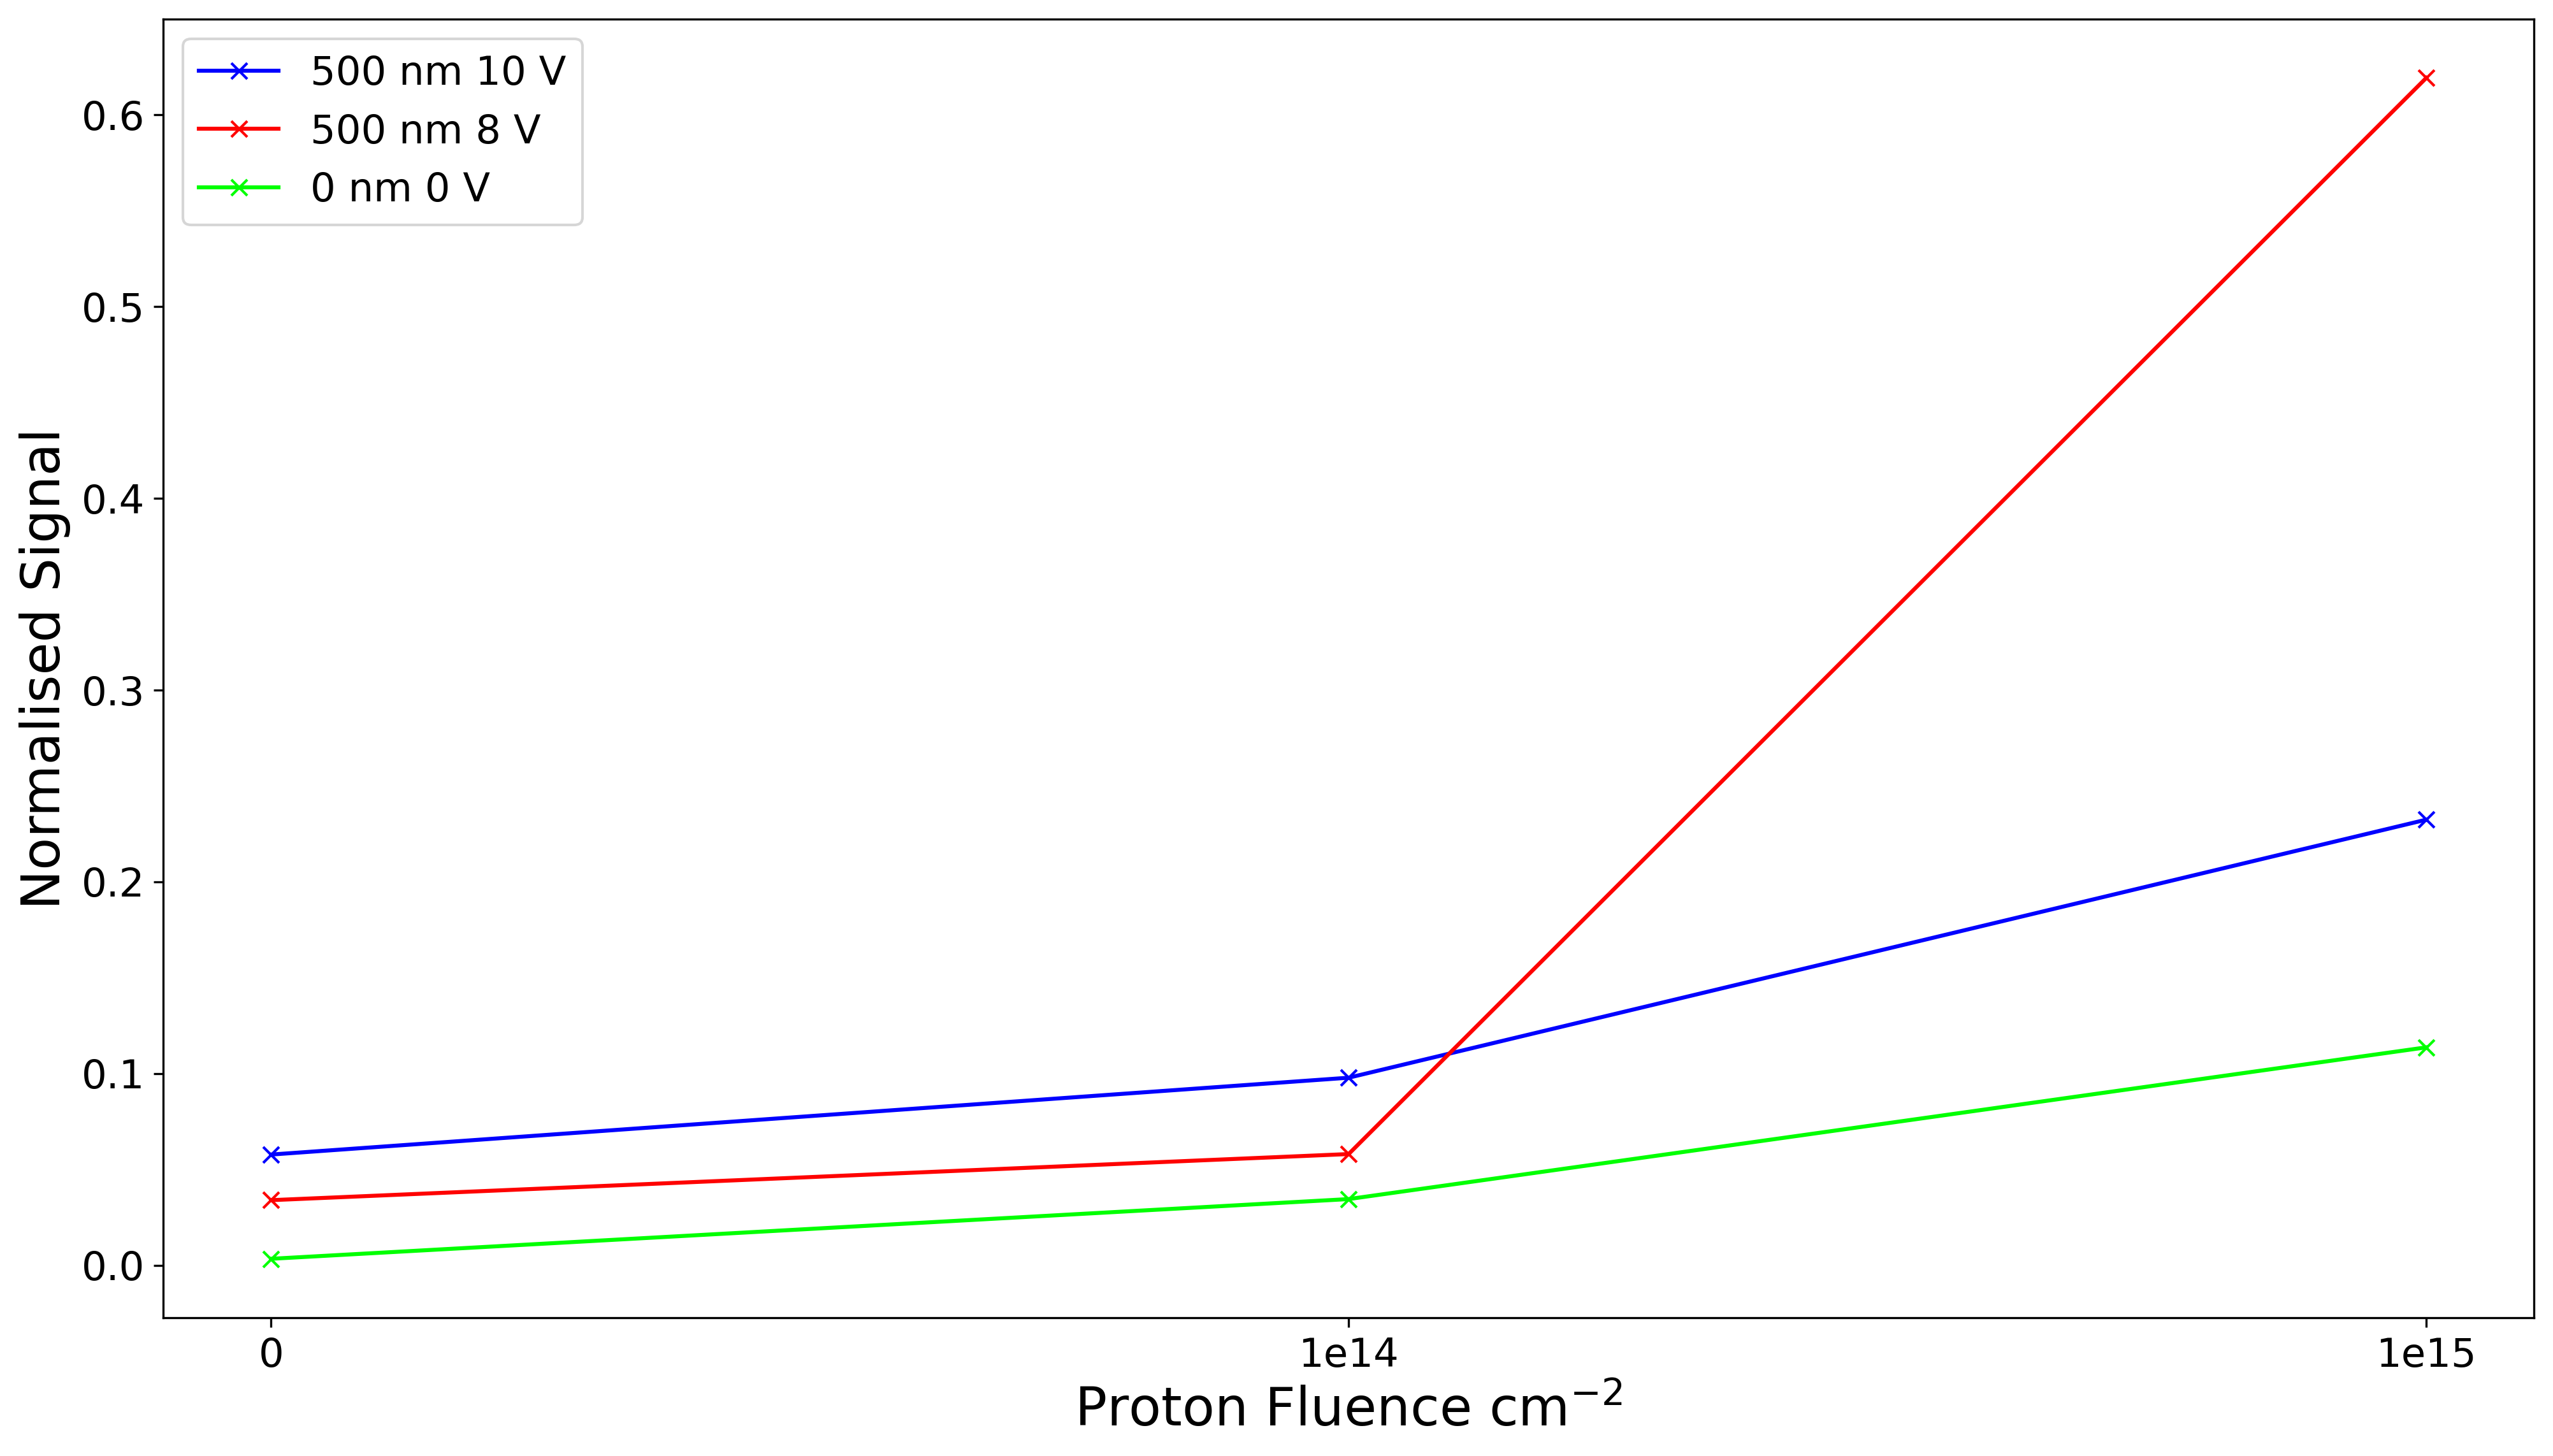

In [11]:
fg_size = (16,9)
fg_dpi = 300
ax_fsize = 20
tick_fsize = 15
leg_fsize = 15

# plot main peak absolute intensity

plt.figure("Bandgap Peak Signal vs Fluence", figsize=fg_size, dpi=fg_dpi)
plt.ylabel("Signal ($mV$)", fontsize=ax_fsize)
plt.xlabel("Proton Fluence cm$^{-2}$", fontsize=ax_fsize)

i=0
for material in yellow_peak_values_df.drop(["Fluence"], axis=1).columns:
    if True in np.array(np.isnan(peak_values_df[material])):
        continue
    # plot normalised by all data
    
    cmap = plt.cm.get_cmap('brg') # use any colormap you like
    

    col = cmap(2*i/(len(peak_values_df.drop("Fluence", axis=1).columns)))
    plt.plot(peak_values_df[material], label = material, linestyle="-", color=col, marker ="x")

    i +=1
plt.xticks([0,1,2],["0","1e14","1e15"], fontsize=tick_fsize)
plt.yticks(fontsize=tick_fsize)
plt.legend(fontsize=leg_fsize)
plt.savefig("PL Bandgap peak height.png", bbox_inches="tight")

# plot normalised to main bandgap height

plt.figure("Yellow Defect Peak Intensity Normalised by Bandgap Peak vs Fluence", figsize=fg_size, dpi=fg_dpi)
plt.ylabel("Normalised Signal", fontsize=ax_fsize)
plt.xlabel("Proton Fluence cm$^{-2}$", fontsize=ax_fsize)

i=0
for material in yellow_peak_values_df.drop(["Fluence"], axis=1).columns:
    if True in np.array(np.isnan(peak_values_df[material])):
        continue
    # plot normalised by all data
    
    cmap = plt.cm.get_cmap('brg') # use any colormap you like
    

    col = cmap(2*i/(len(peak_values_df.drop("Fluence", axis=1).columns)))
    plt.plot(yellow_peak_values_df[material]/peak_values_df[material], label = material, linestyle="-", color=col, marker ="x")

    i +=1
plt.xticks([0,1,2],["0","1e14","1e15"], fontsize=tick_fsize)
plt.yticks(fontsize=tick_fsize)
plt.legend(fontsize=leg_fsize)
#plt.savefig("PL yellow peak height.png", bbox_inches="tight")

## CL Class

In [12]:
class CL_data:
    """
    Class used to contain the data and some methods associated with a CL map.
    Assignment of several attributes relating to material sample are only assigned if the information is in the folder name and this is case sensitive e.g. 500NMHVLE.
    """
    def __init__(self, data_folder):
        self.folder_path = data_folder
        
        f_name = str(data_folder) # should come up with something better later probably but have made folder the name
        self.name = f_name[::-1][:f_name[::-1].index("\\")][::-1]
        
        """Further meta data"""
        file_to_open = data_folder / 'MicroscopeStatus.txt'

        ### Get values from MicroscopeStatus
        with open(file_to_open, encoding='windows-1252' ) as status :
            for line in status:
                if 'Resolution_X' in line:
                    nx = int(line[line.find(':')+1:-8])         #nx = pixel in x-direction
                    self.nx = nx
                if 'Resolution_Y' in line:
                    ny = int(line[line.find(':')+1:-8])         #ny = pixel in y-direction
                    self.ny=ny
                if 'Central wavelength:' in line:
                    self.centrelambda = float (line[line.find(':')+1:-3]) # nm
                if "Timestamp" in line:
                    self.timestamp = line[line.find(':')+1:]
                if "HYP Dwelltime" in line:
                    self.hyp_dwelltime = float(line[line.find(':')+1:-3]) # dwell time in ms
                if "Beam Energy" in line:
                    self.beam_energy = float(line[line.find(':')+1:-2])
                if "Aperture" in line:
                    self.aperture = line[line.find(':')+1:]
                if 'Attomic zoom' in line:
                    self.attomic_zoom = int(line[line.find(':')+1:]) 
        
        ### Meta data I haven't learnt to/can't extract properly yet 
        
        # beam_current units are nA
        if "1NA" in self.name:
            self.beam_current = 1.0 
        elif "10NA" in self.name:
            self.beam_current = 10.0 
        elif "1-5NA" in self.name:
            self.beam_current = np.nan
        else:
            self.beam_current = np.NaN
        
        # porous_thickness units are nm
        if "-T" in self.name:
            self.porous_thickness = 0.0 
        elif "500NM" in self.name:
            self.porous_thickness = 500.0 
        elif "200NM" in self.name:
            self.porous_thickness = 200.0
        elif "100NM" in self.name:
            self.porous_thickness = 100.0
        else:
            self.porous_thickness = np.NaN
        
        # proton fluence is in units of cm^-2
        if "NE" in self.name or "T0" in self.name:
            self.proton_fluence = 0.0
        if "LE" in self.name or "T1" in self.name:
            self.proton_fluence = 1e14
        if "HE" in self.name or "T2" in self.name:
            self.proton_fluence = 1e15

        # nominal voltage of etch different from measured
        if "NV" in self.name or "-T" in self.name:
            self.etch_volt = 0
        if "LV" in self.name:
            self.etch_volt = 8
        if "HV" in self.name:
            self.etch_volt = 10

        """Create hyperspy object to contain CL data"""
        s = CL_1D_signal(data_folder)  # warning can only plot after wavelength shift finished
        self.CL_map = s
        ### useful to have wavelength more easily accessable by attribute
        self.wavelengths = (np.arange(s.data.shape[2])*s.axes_manager[2].scale) + s.axes_manager[2].offset 

        self.pixel_size_x = s.axes_manager[0].scale
        self.pixel_size_y = s.axes_manager[1].scale
        self.image_size_x = self.pixel_size_x*self.nx 
        self.image_size_y = self.pixel_size_y*self.ny 
        
        """Extract SE image - made try in case file name changes again"""
        try:
            Filename = "Live_Scan_"+str(nx)+"_"+str(ny)+"-SE.png"
            Live_SE_Filepath = data_folder / Filename
            SE = hs.load(Live_SE_Filepath)
            self.SE = SE
        except:
            self.SE = np.NaN
            
    def plot_over_SE(self):
        return self.CL_map.plot(navigator = self.SE, autoscale = "v")
    
    def remove_spikes(self, lower_lam = 350, upper_lam = 365):
        """
        Supresses random spikes in the data by removing spikes greater than the maximum found within a wavelength range set in the parameters.
        Originally replaced with nans but awkward to work with so have replaced with 0s.
        Note may be losing data if applied carelessly and 0s should be processed afterwards.
        Directly modifies CL_data data cube when called.
        """
        # find wavelength indices
        wavelengths = self.wavelengths
        for wavelength_index in np.arange(len(wavelengths)):
            if wavelengths[wavelength_index] > lower_lam:
                lower_lam_index = wavelength_index
                break
        for wavelength_index in np.arange(len(wavelengths)):
            if wavelengths[wavelength_index] > upper_lam:
                upper_lam_index = wavelength_index
                break

        data_shape = self.CL_map.data.shape
        for row_index in np.arange(data_shape[0]):
            for col_index in np.arange(data_shape[1]):
                # now at pixel level
                # find bandgap peak and use to find higher values elsewhere
                bandgap_peak = np.max(self.CL_map.data[row_index][col_index][lower_lam_index:upper_lam_index])
                for lam_index in np.arange(data_shape[2]):
                    if self.CL_map.data[row_index][col_index][lam_index] > bandgap_peak and (lam_index<lower_lam_index or lam_index>=upper_lam_index):
                        self.CL_map.data[row_index][col_index][lam_index] = 0

    def remove_background(self, lower_lam=250, upper_lam=320):
        """
        Removes background by averaging values between wavelength range. Ignores 0 values which are usually present from spike removal.
        """
        
        # find wavelength indices
        wavelengths = self.wavelengths
        for wavelength_index in np.arange(len(wavelengths)):
            if wavelengths[wavelength_index] > lower_lam:
                lower_lam_index = wavelength_index
                break
        for wavelength_index in np.arange(len(wavelengths)):
            if wavelengths[wavelength_index] > upper_lam:
                upper_lam_index = wavelength_index
                break


        data_shape = self.CL_map.data.shape
        for row_index in np.arange(data_shape[0]):
            for col_index in np.arange(data_shape[1]):
                # now at pixel level
                # find average discounting the 0 values
                spectra_sum = 0
                items_num = 0
                for val in self.CL_map.data[row_index][col_index][lower_lam_index:upper_lam_index]:
                    if val != 0:
                        spectra_sum += val
                        items_num += 1
                average = spectra_sum/items_num
                # subtract average from wavelength counts if not 0 (and so not a removed spike)
                for lam_index in np.arange(data_shape[2]):
                    if self.CL_map.data[row_index][col_index][lam_index] != 0:
                        self.CL_map.data[row_index][col_index][lam_index] -= average 

    def interpolate_0(self):
        """
        Should work ok if one-off spikes. Haven't fully implemented in the end as seeing what data looks like first.
        Have so far decided not to use.
        """
        data_shape = self.CL_map.data.shape
        for row_index in np.arange(data_shape[0]):
            for col_index in np.arange(data_shape[1]):
                for lam_index in np.arange(data_shape[2]):
                    if CL_data.CL_map.data[row_index][col_index][lam_index] == 0:
                        pass
                        #CL_data.CL_map.data[row_index][col_index][lam_index] = 0.5(CL_data.CL_map.data[row_index][col_index][lam_index-10]+CL_data.CL_map.data[row_index][col_index][lam_index+10])

## Test CL code

In [443]:
folder = Path("C:/Users/es758/OneDrive - University of Cambridge/NanoDTC/Mini 2/CL/CL Session 2 and 3/CL Maps")

subfolder = get_subfolders(folder)[6]
CL_test = CL_data(subfolder)
CL_test.remove_spikes()
CL_test.remove_background()
CL_test.name

# CL_data_list = [CL_data(data_folder) for data_folder in get_subfolders(folder) if (data_folder not in skipped_data_path_list)]
# print("done")

  0%|          | 0/16384 [00:00<?, ?it/s]

'HYP-HYP-500NMLVHE-3KV-1NA-25NM-500NM-2-001'

## CL Mean Spectra

### Data Extraction

Extract data and make necessary corrections.

In [13]:
# Assign folder location
folder = Path("C:/Users/es758/OneDrive - University of Cambridge/NanoDTC/Mini 2/CL/CL Session 2 and 3/Maps for Mean Spectra")


# Choose any folders to be skipped
skipped_data = [
    "HYP-HYP-500NMHVLE-3KV-1NA-25NM-500NM-1",
    "HYP-HYP-500NMLVLE-3KV-1NA-25NM-500NM-2",
    "HYP-HYP-500NMLVNE-3KV-1NA-25NM-500NM-2"
]
skipped_data_path_list = [folder/skipped for skipped in skipped_data]

# Extract data as CL_data objects
CL_data_list_mean = [CL_data(data_folder) for data_folder in get_subfolders(folder) if (data_folder not in skipped_data_path_list)]

print("Scans all used the same dwell time so no need for correction")

# Remove spikes and background
for CL_data_entry in CL_data_list_mean:
    CL_data_entry.remove_spikes()
    CL_data_entry.remove_background()

print("Done")

  0%|          | 0/4096 [00:00<?, ?it/s]

  0%|          | 0/4096 [00:00<?, ?it/s]

  0%|          | 0/4096 [00:00<?, ?it/s]

  0%|          | 0/4096 [00:00<?, ?it/s]

  0%|          | 0/4096 [00:00<?, ?it/s]

  0%|          | 0/4096 [00:00<?, ?it/s]

  0%|          | 0/4096 [00:00<?, ?it/s]

  0%|          | 0/4096 [00:00<?, ?it/s]

  0%|          | 0/4096 [00:00<?, ?it/s]

  0%|          | 0/4096 [00:00<?, ?it/s]

Scans all used the same dwell time so no need for correction
Done


Sort data in pandas df.

In [14]:
structure = {
    "Fluence": [0.0, 1e14, 1e15]
    
}

wv_spectra_df = pd.DataFrame(structure)
for scan in CL_data_list_mean:
    wv_spectra_df.loc[wv_spectra_df.index[wv_spectra_df["Fluence"]==scan.proton_fluence][0],str(int(scan.porous_thickness)) + " nm " + str(scan.etch_volt)+ " V"] = scan
    
wv_spectra_df

Fluence                                      500 nm 10 V  \
0  0.000000e+00  <__main__.CL_data object at 0x000002B49CBBD2B0>   
1  1.000000e+14  <__main__.CL_data object at 0x000002B49CD73790>   
2  1.000000e+15  <__main__.CL_data object at 0x000002B49CF469A0>   

                                        500 nm 8 V  \
0  <__main__.CL_data object at 0x000002B48A4D6E80>   
1  <__main__.CL_data object at 0x000002B4961C7CA0>   
2  <__main__.CL_data object at 0x000002B49BA8DC70>   

                                        500 nm 0 V  \
0  <__main__.CL_data object at 0x000002B49CCCACD0>   
1                                              NaN   
2                                              NaN   

                                          0 nm 0 V  
0  <__main__.CL_data object at 0x000002B4883BC640>  
1  <__main__.CL_data object at 0x000002B49B9DDBE0>  
2  <__main__.CL_data object at 0x000002B49CB72D60>

Extract mean spectra.

In [15]:
# new data frames to hold results
mean_spectra_df = wv_spectra_df.copy()
mean_spectra_df = mean_spectra_df.astype("object")

structure = {
    "Fluence": [0.0, 1e14, 1e15]
    
}

peak_values_df = pd.DataFrame(structure)
std_error_values_df = pd.DataFrame(structure)
yellow_peak_values_df = pd.DataFrame(structure)
y_std_error_values_df = pd.DataFrame(structure)

# iterate over columns
for structure in wv_spectra_df.columns:
    
    # skip Fluence column
    if structure == 'Fluence':
        continue
    
    # iterate over entries in column
    for sample in wv_spectra_df[structure]:

        # handle found data
        if type(sample) == type(wv_spectra_df[structure][0]): # will always have at least a 0 exposed sample
            
            mean_spectra = sample.CL_map.mean((0,1))
            
            # store in df
            mean_spectra_df.at[wv_spectra_df.index[wv_spectra_df["Fluence"]==sample.proton_fluence][0],str(int(sample.porous_thickness)) + " nm " + str(sample.etch_volt)+ " V"] = mean_spectra.data
            
            # find peak values and store
            peak_vals = []
            yellow_peak_vals = []
            
            sample_shape = sample.CL_map.data.shape
            for y in np.arange(sample_shape[0]):
                for x in np.arange(sample_shape[1]):
                    peak_val = np.max(sample.CL_map.data[y][x])
                    peak_vals.append(peak_val)
                    yellow_peak_val = np.max(sample.CL_map.data[y][x][496:687]) # these indices work out so far
                    yellow_peak_vals.append(yellow_peak_val)
                    
            peak_vals = np.array(peak_vals)
            yellow_peak_vals = np.array(yellow_peak_vals)
            
            peak_values_df.at[wv_spectra_df.index[wv_spectra_df["Fluence"]==sample.proton_fluence][0],str(int(sample.porous_thickness)) + " nm " + str(sample.etch_volt)+ " V"] = np.mean(peak_vals)
            yellow_peak_values_df.at[wv_spectra_df.index[wv_spectra_df["Fluence"]==sample.proton_fluence][0],str(int(sample.porous_thickness)) + " nm " + str(sample.etch_volt)+ " V"] = np.mean(yellow_peak_vals)
            std_error_values_df.at[wv_spectra_df.index[wv_spectra_df["Fluence"]==sample.proton_fluence][0],str(int(sample.porous_thickness)) + " nm " + str(sample.etch_volt)+ " V"] = np.std(peak_vals)/(np.sqrt(sample_shape[0]*sample_shape[1]))
            y_std_error_values_df.at[wv_spectra_df.index[wv_spectra_df["Fluence"]==sample.proton_fluence][0],str(int(sample.porous_thickness)) + " nm " + str(sample.etch_volt)+ " V"] = np.std(yellow_peak_vals)/(np.sqrt(sample_shape[0]*sample_shape[1]))  
            

             
        # handle nans
        elif np.isnan(sample):
            continue

mean_spectra_df




Fluence                                        500 nm 10 V  \
0                 0.0  [-0.23460771961115487, -0.22916431149403393, -...   
1   100000000000000.0  [-0.17071087161741663, -0.16403582441199865, -...   
2  1000000000000000.0  [-0.16584457674013273, -0.16610707173634798, -...   

                                          500 nm 8 V  \
0  [-0.18917383842635577, -0.16787352076004808, -...   
1  [-0.19119432954480942, -0.17210488564397652, -...   
2  [-0.15944383123173375, -0.1410911077064062, -0...   

                                          500 nm 0 V  \
0  [-0.23226215925346735, -0.2380525762926268, -0...   
1                                                NaN   
2                                                NaN   

                                            0 nm 0 V  
0  [-0.16681987578944407, -0.14993087943127759, -...  
1  [-0.15261256506472154, -0.1648436933487136, -0...  
2  [-0.1581865125529598, -0.13219218543890007, -0...

### Mean Spectra

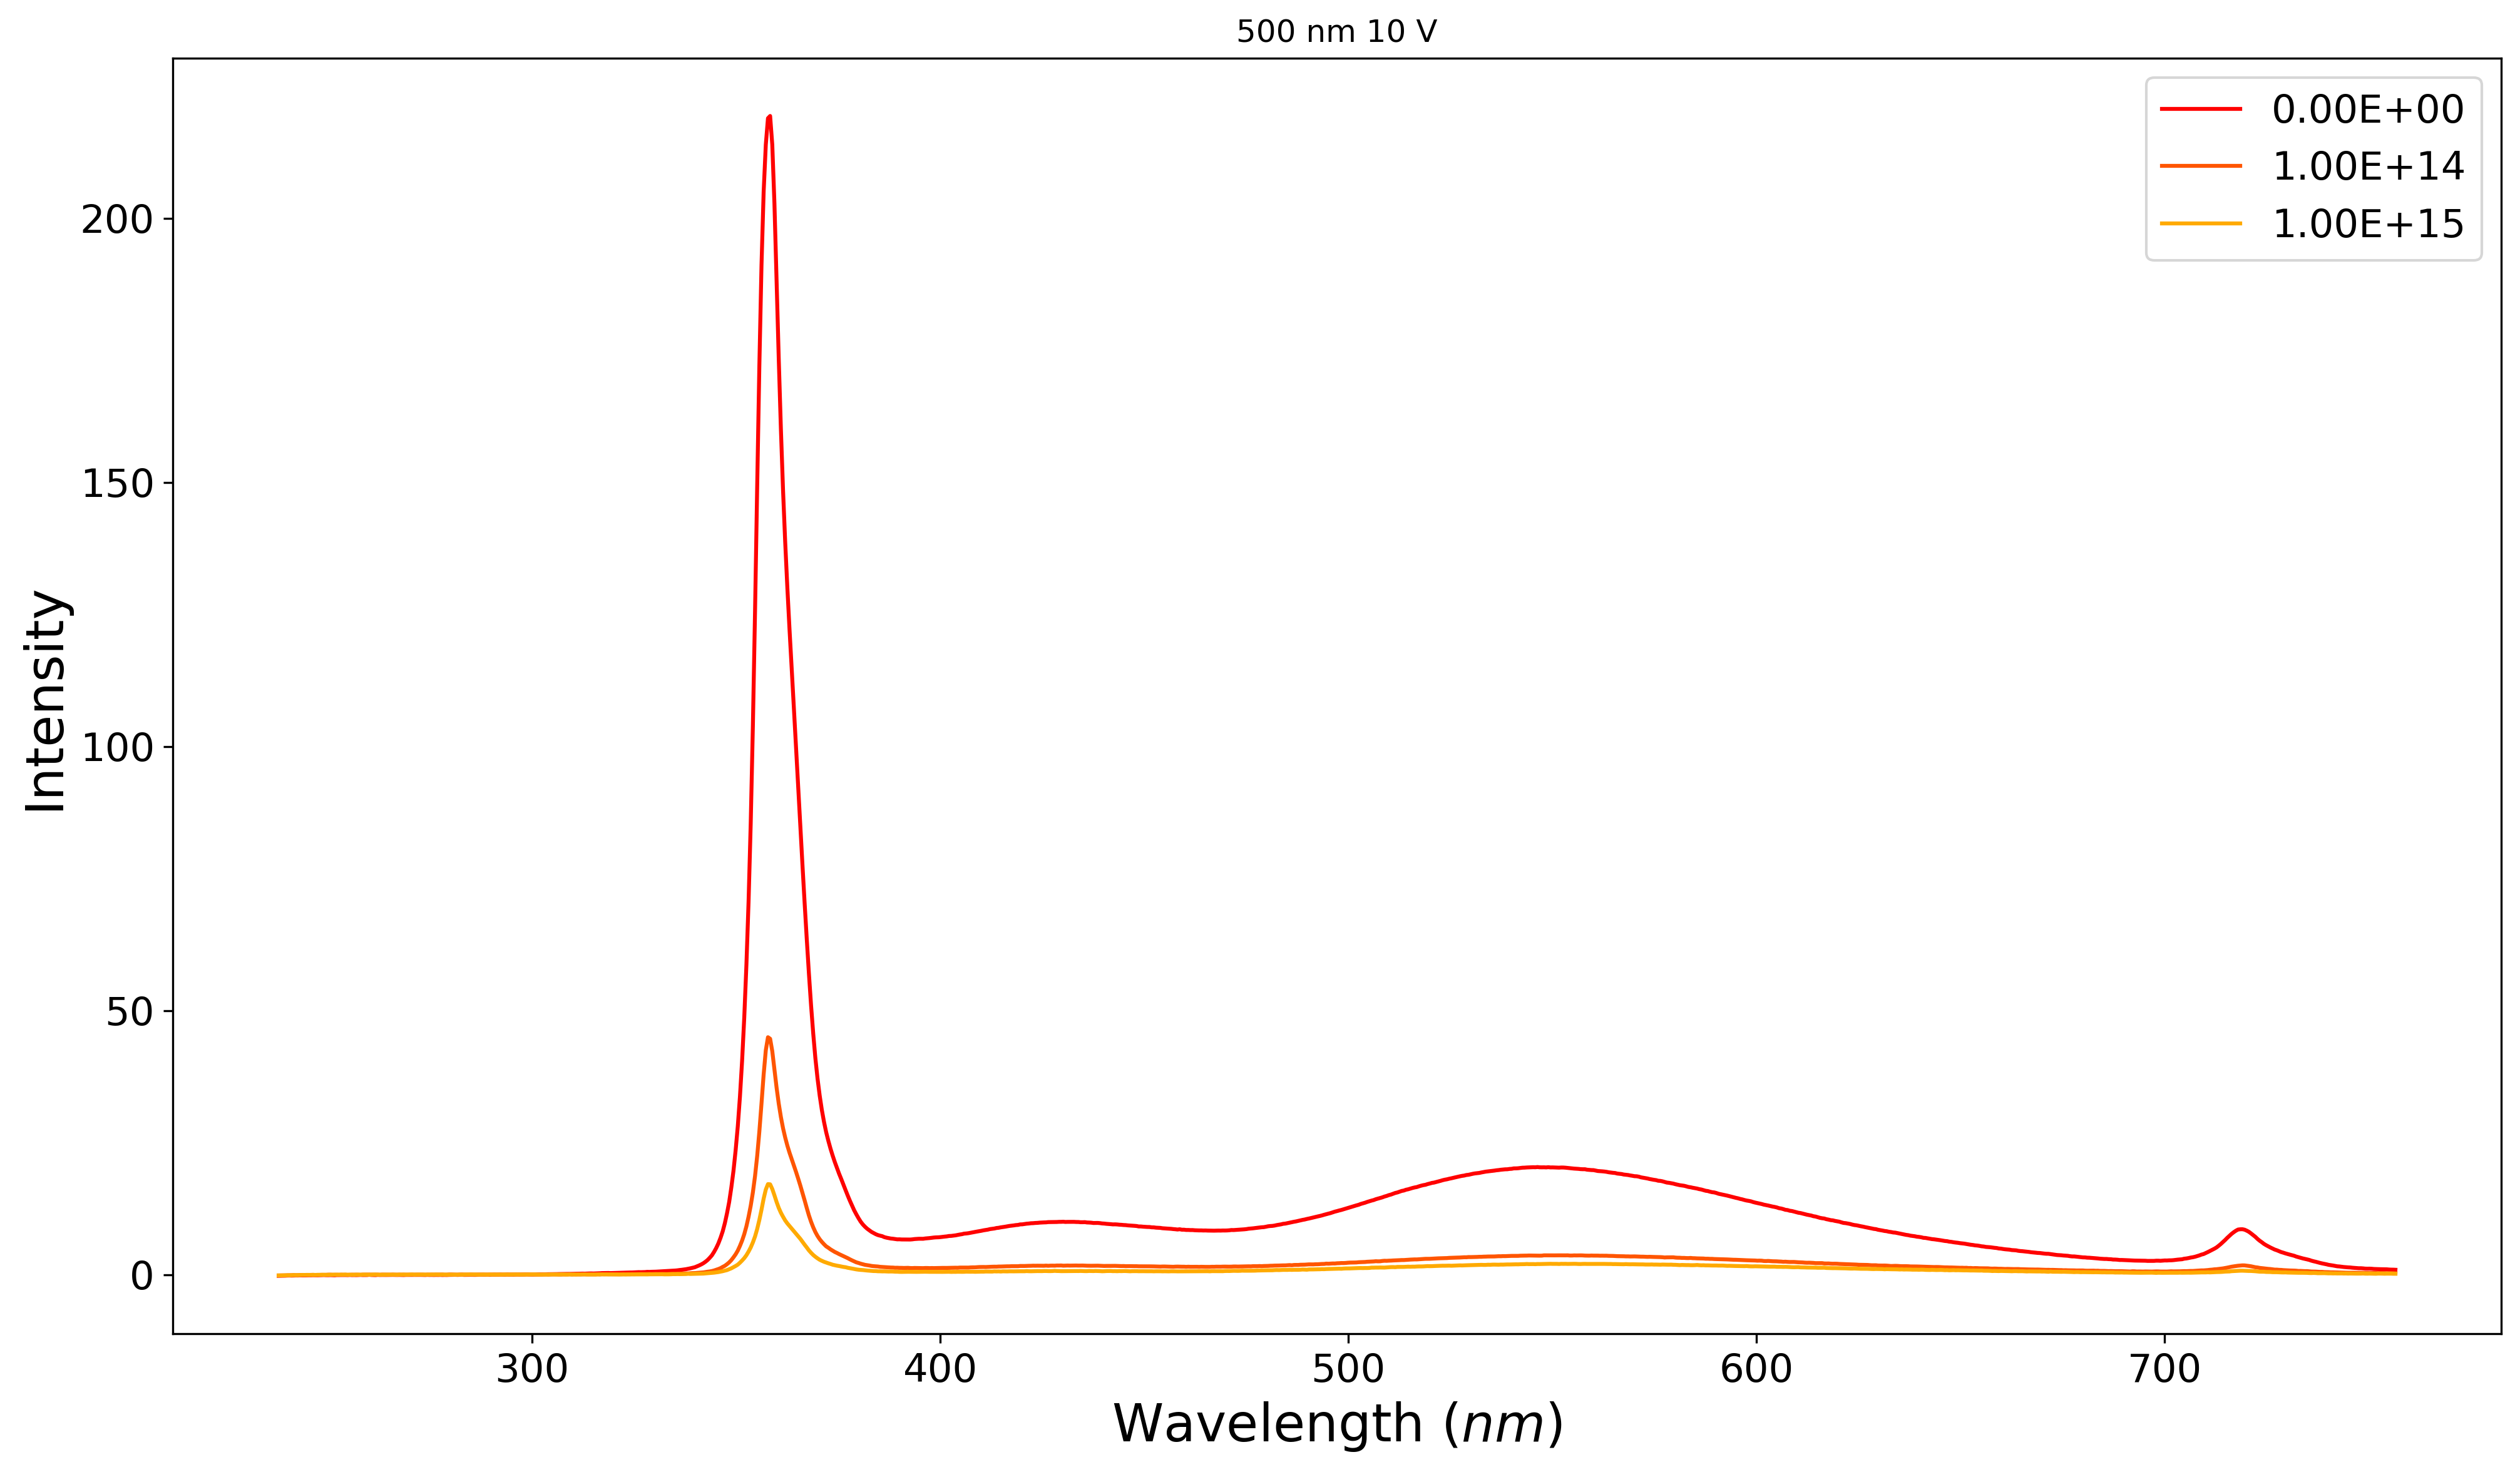

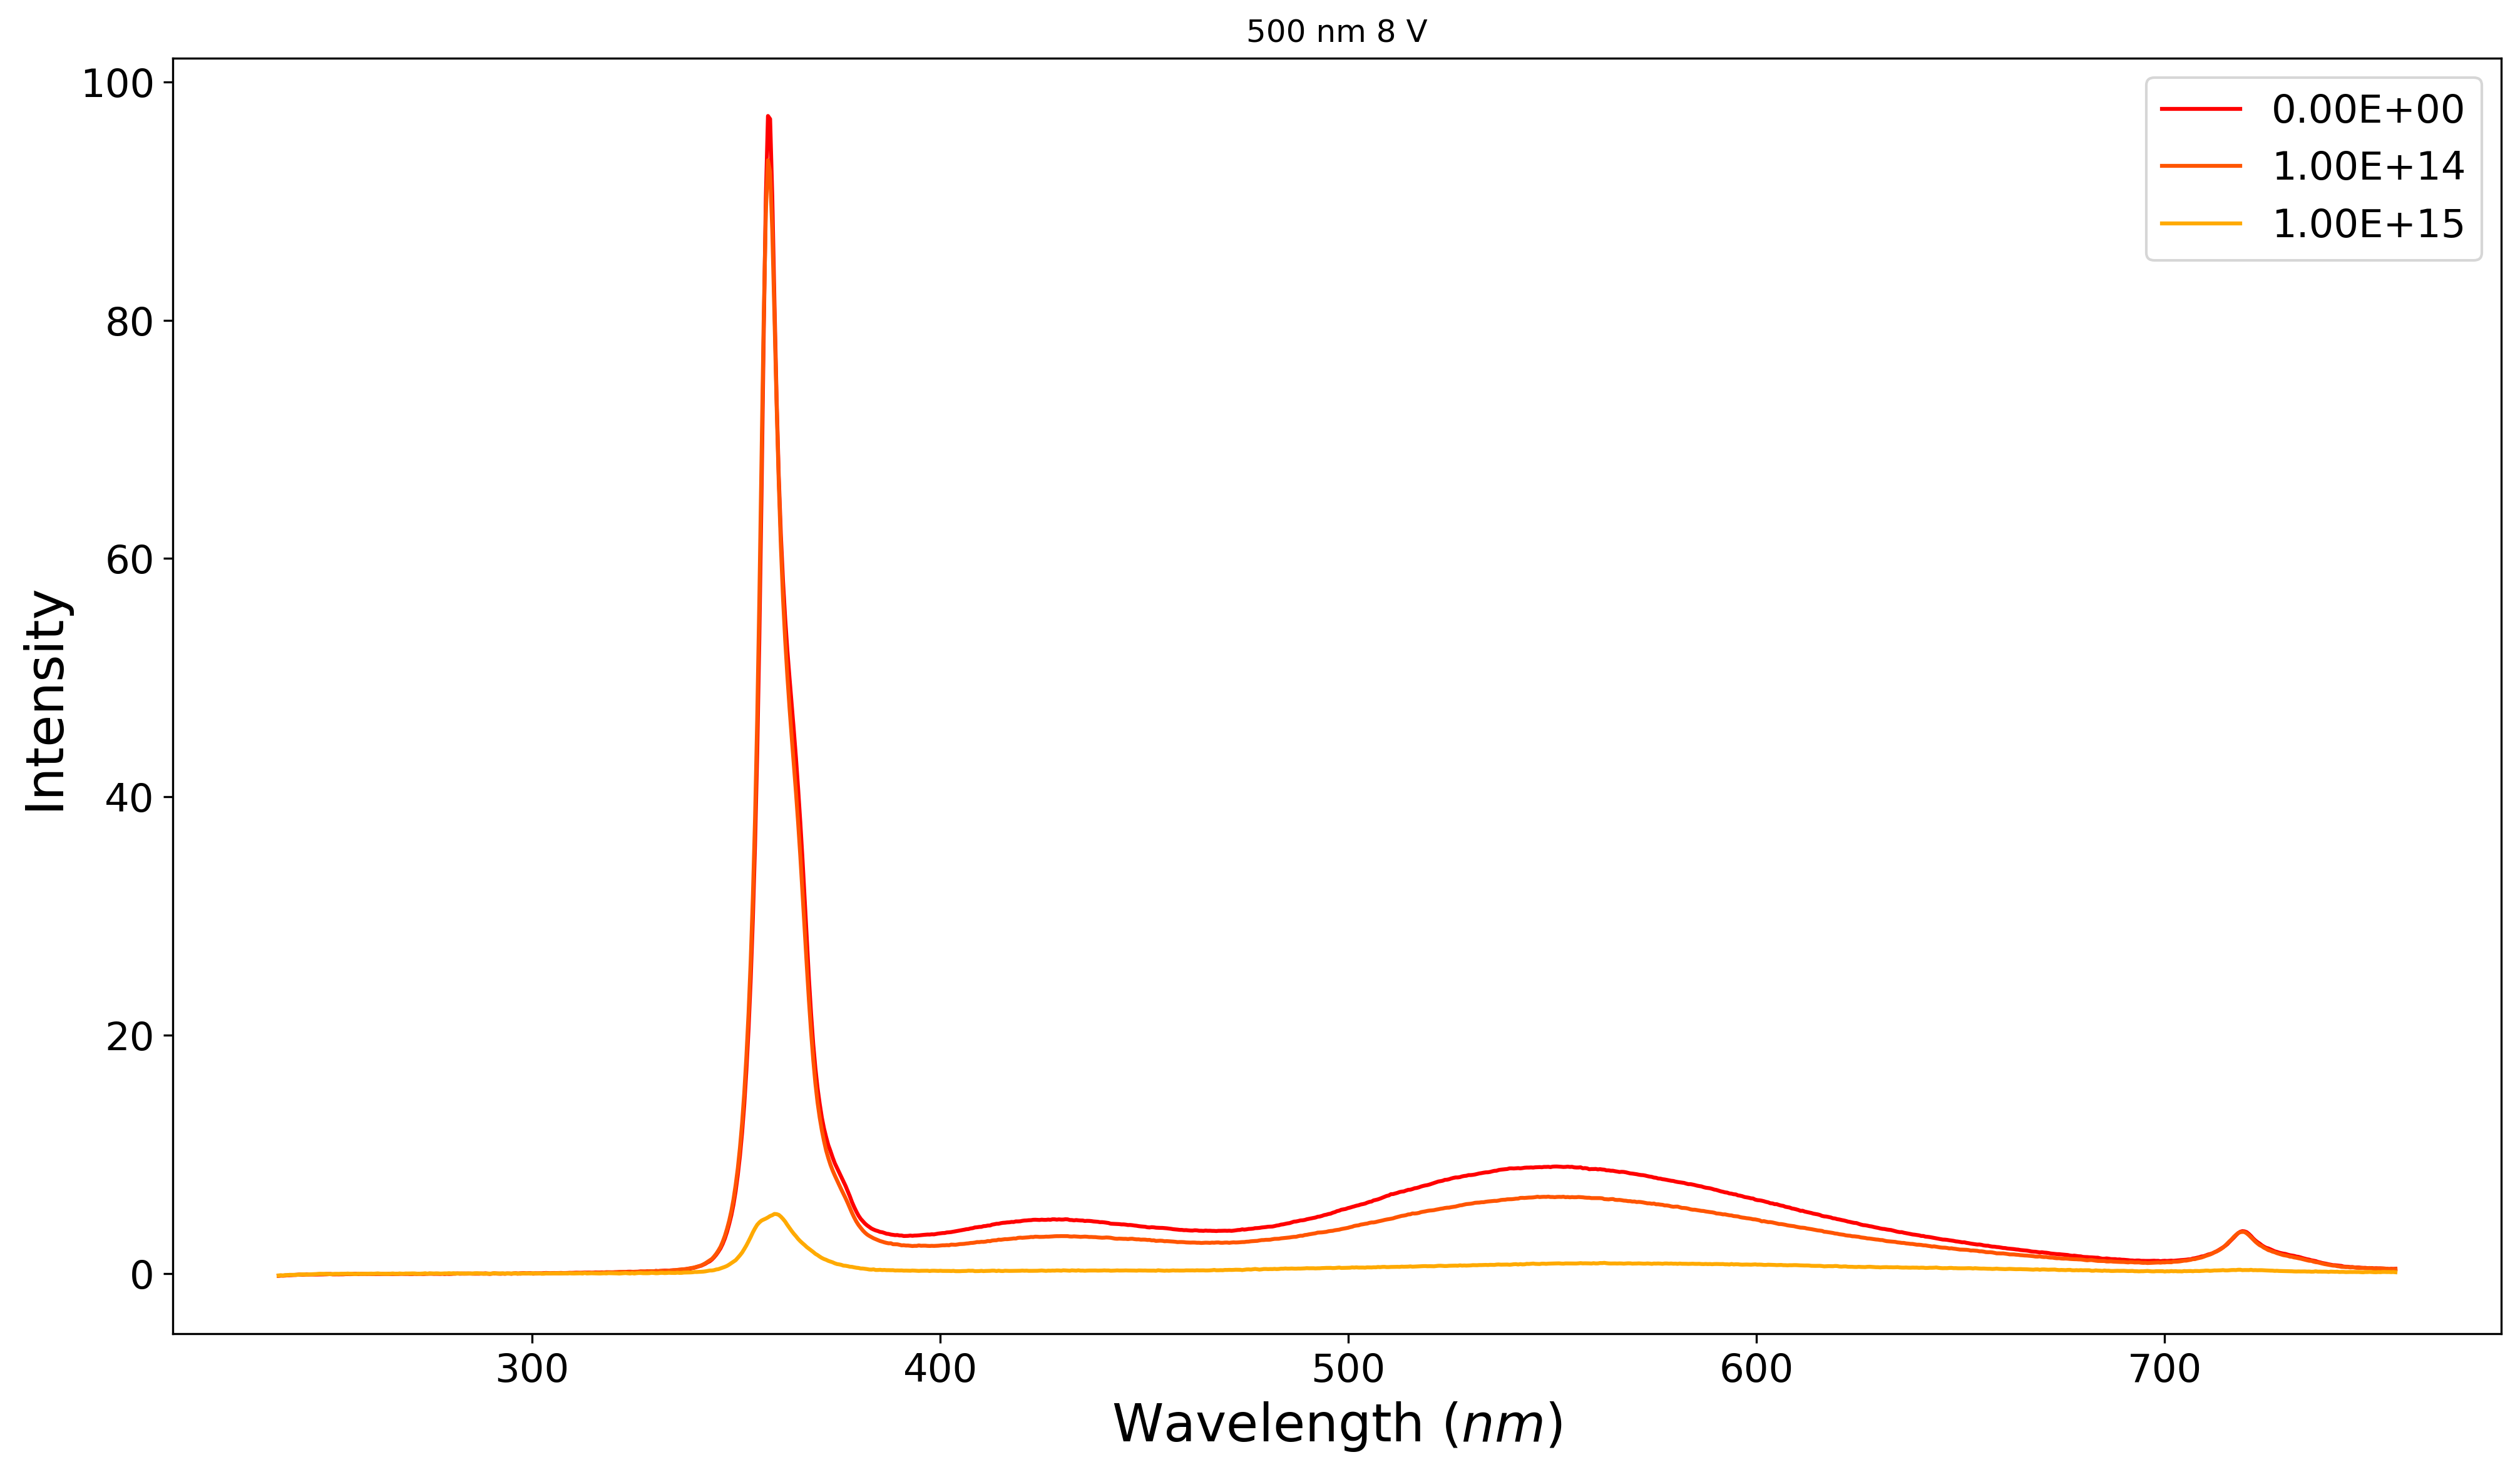

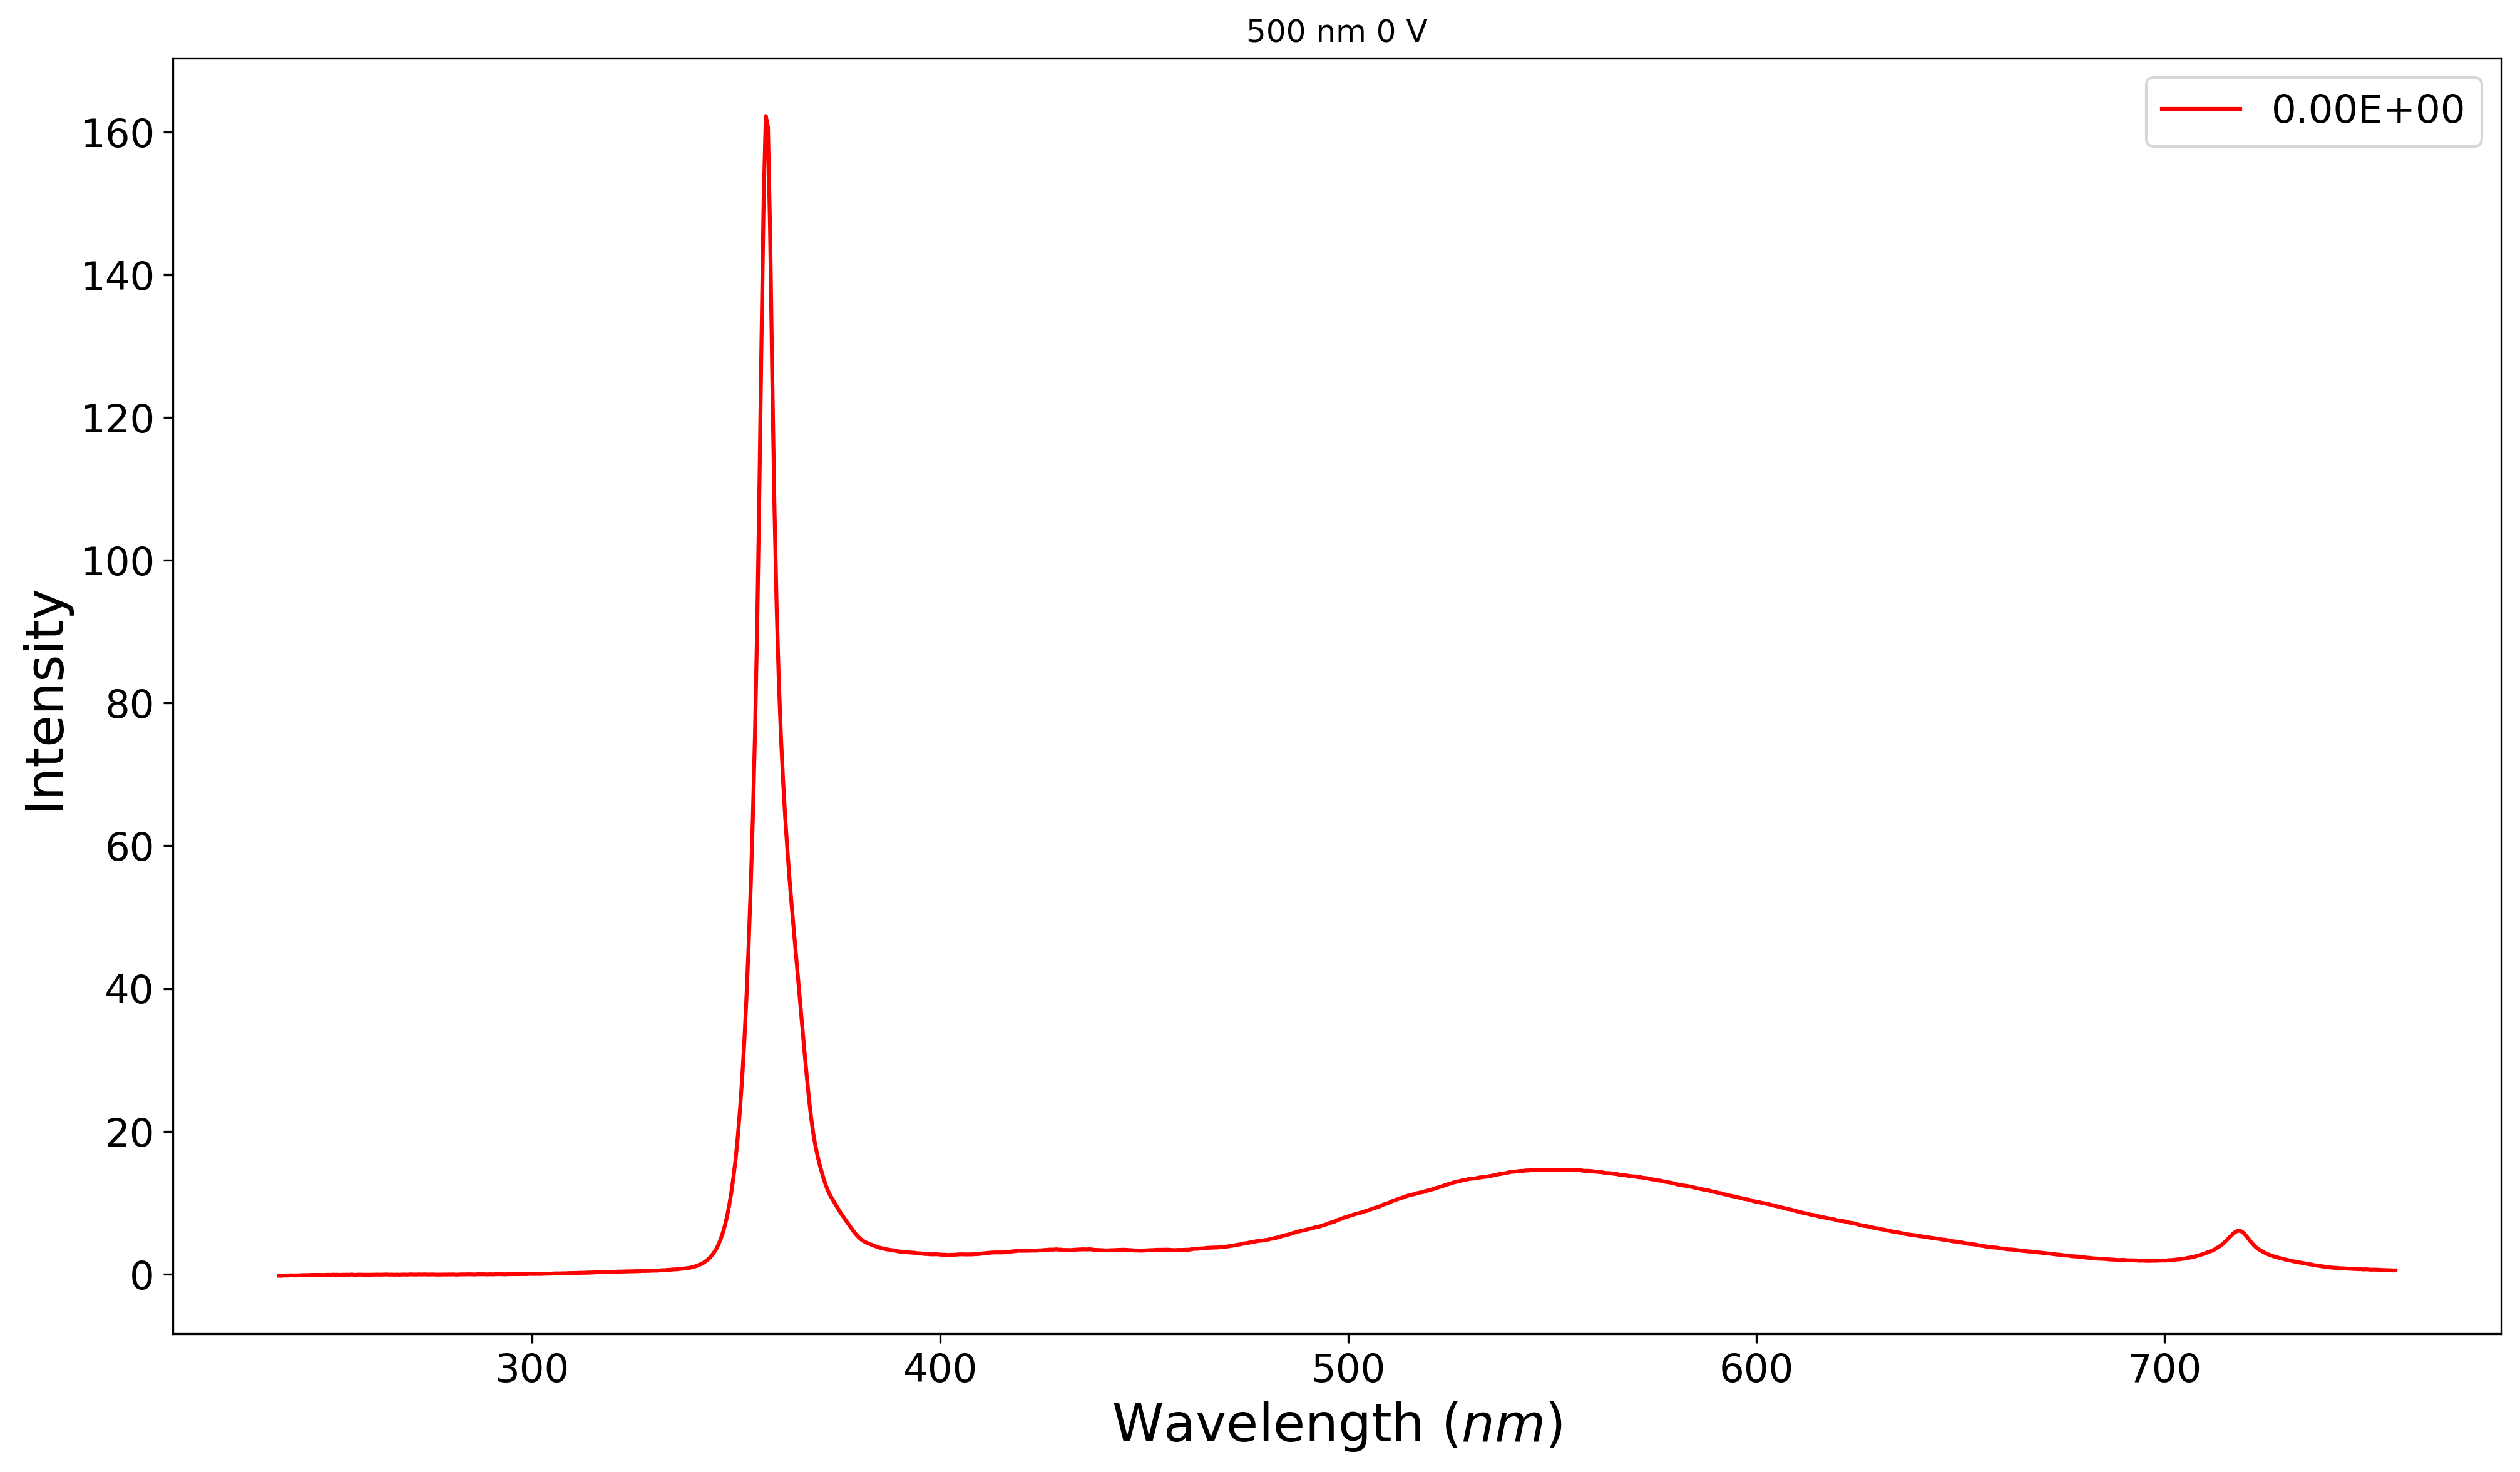

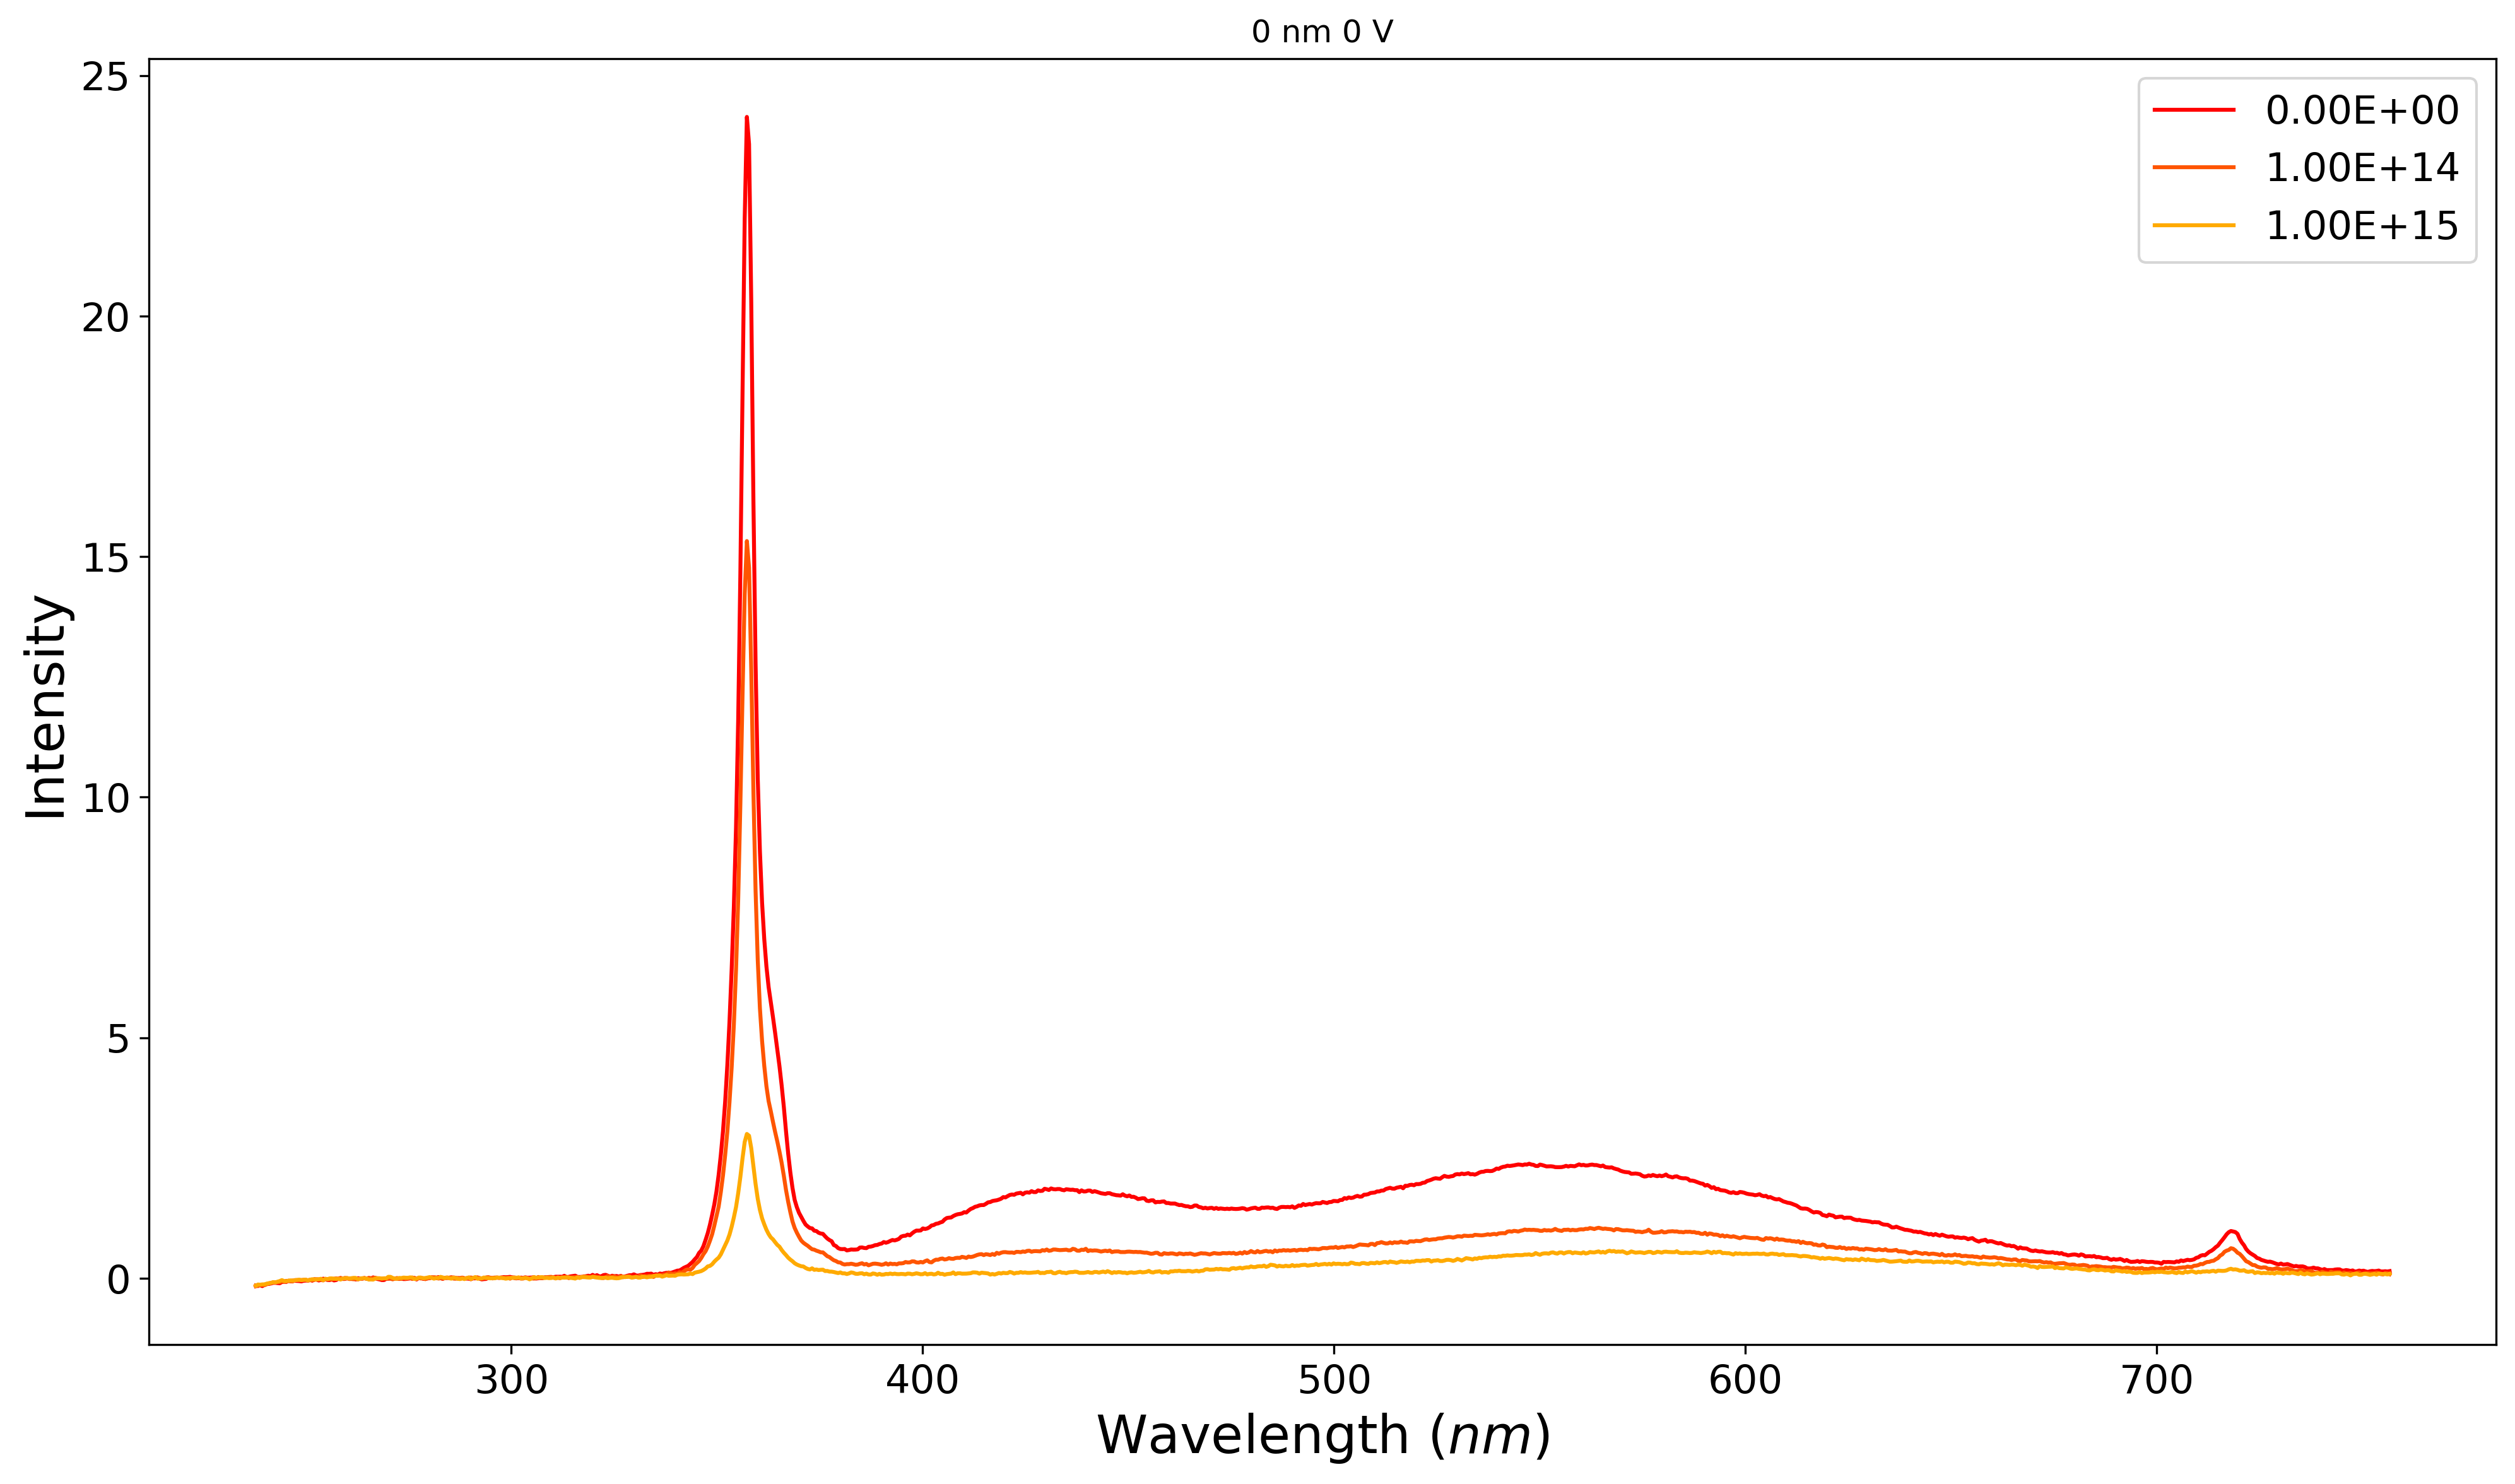

In [17]:
%matplotlib inline

fg_size = (16,9)
fg_dpi = 300
ax_fsize = 20
tick_fsize = 15
leg_fsize = 15

# structure = {
#     "Fluence": [0.0, 1e14, 1e15]
    
# }

# peak_values_df = pd.DataFrame(structure)
# yellow_peak_values_df = pd.DataFrame(structure)

# iterate over columns
for structure in mean_spectra_df.columns:
    
    # skip Fluence column
    if structure == 'Fluence':
        continue
        
    # initialise some plot stuff
    fig = plt.figure(num = structure + " Mean Spectra at 3 Fluence Levels", figsize=fg_size, dpi=fg_dpi)
    ax = fig.add_subplot(1,1,1)
    line_styles = ["-", ":"]
    
    index_counter = 0
    
    # iterate over entries in column
    for spectra in mean_spectra_df[structure]:

        # handle found data
        if type(spectra) == type(mean_spectra_df[structure][0]): # will always have at least a 0 exposed sample
            
            # do stuff
            
            # plot spectra
            cmap = plt.cm.get_cmap('autumn') # use any colormap you like
            
            df_index = index_counter
            
            col = cmap(df_index/len(mean_spectra_df))
            
            ax.plot(wv_spectra_df[structure][df_index].wavelengths, spectra, linestyle = line_styles[0], color = col, label = f"{wv_spectra_df[structure][df_index].proton_fluence:.2E}" )
            
            # store peak values
#             max_p = np.max(spectra)
#             max_p_yellow = np.max(spectra[496:687])

#             peak_values_df.loc[df_index,structure] = max_p
            
#             yellow_peak_values_df.loc[df_index,structure] = max_p_yellow
            

             
        # handle nans
        elif np.isnan(spectra):
            continue
        
        index_counter += 1

    ax.set_title(structure)    
    ax.set_xlabel("Wavelength ($nm$)", fontsize=ax_fsize)
    ax.set_ylabel("Intensity", fontsize=ax_fsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fsize)
    ax.tick_params(axis='both', which='minor', labelsize=tick_fsize)
    ax.legend(loc="best", fontsize=leg_fsize)
    #fig.savefig(structure+" CL map.png",bbox_inches="tight")

### Peak Analysis

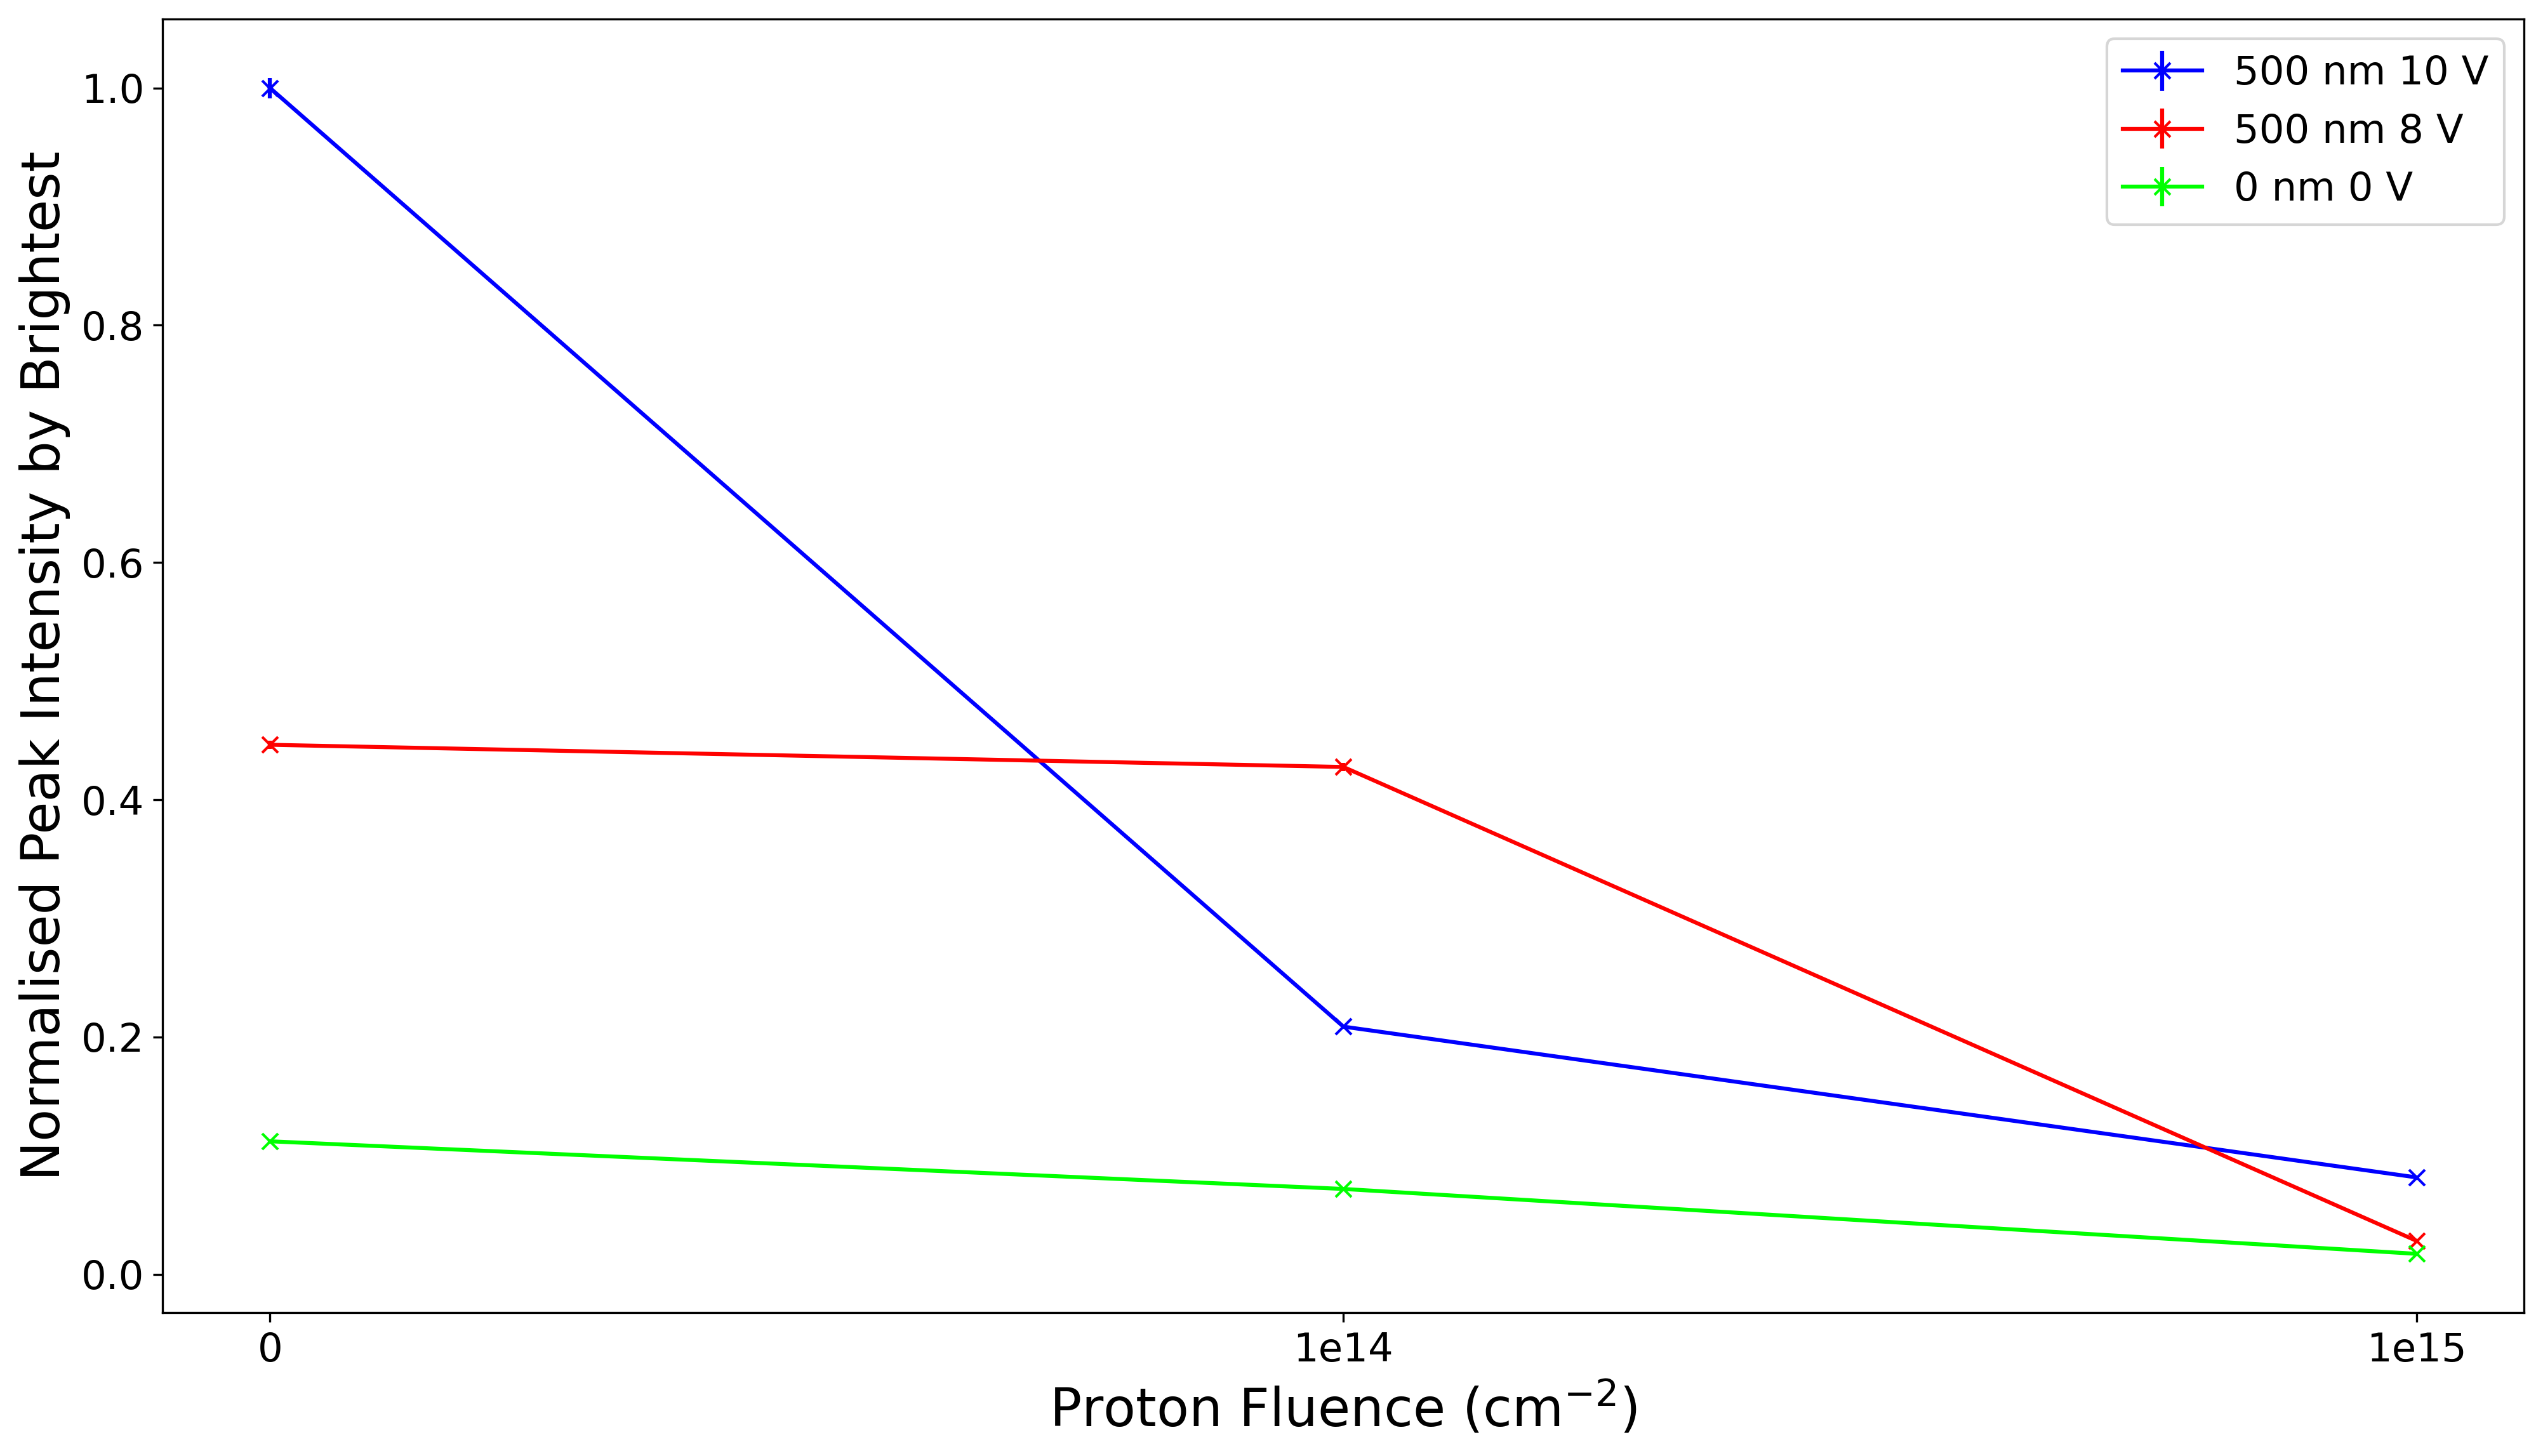

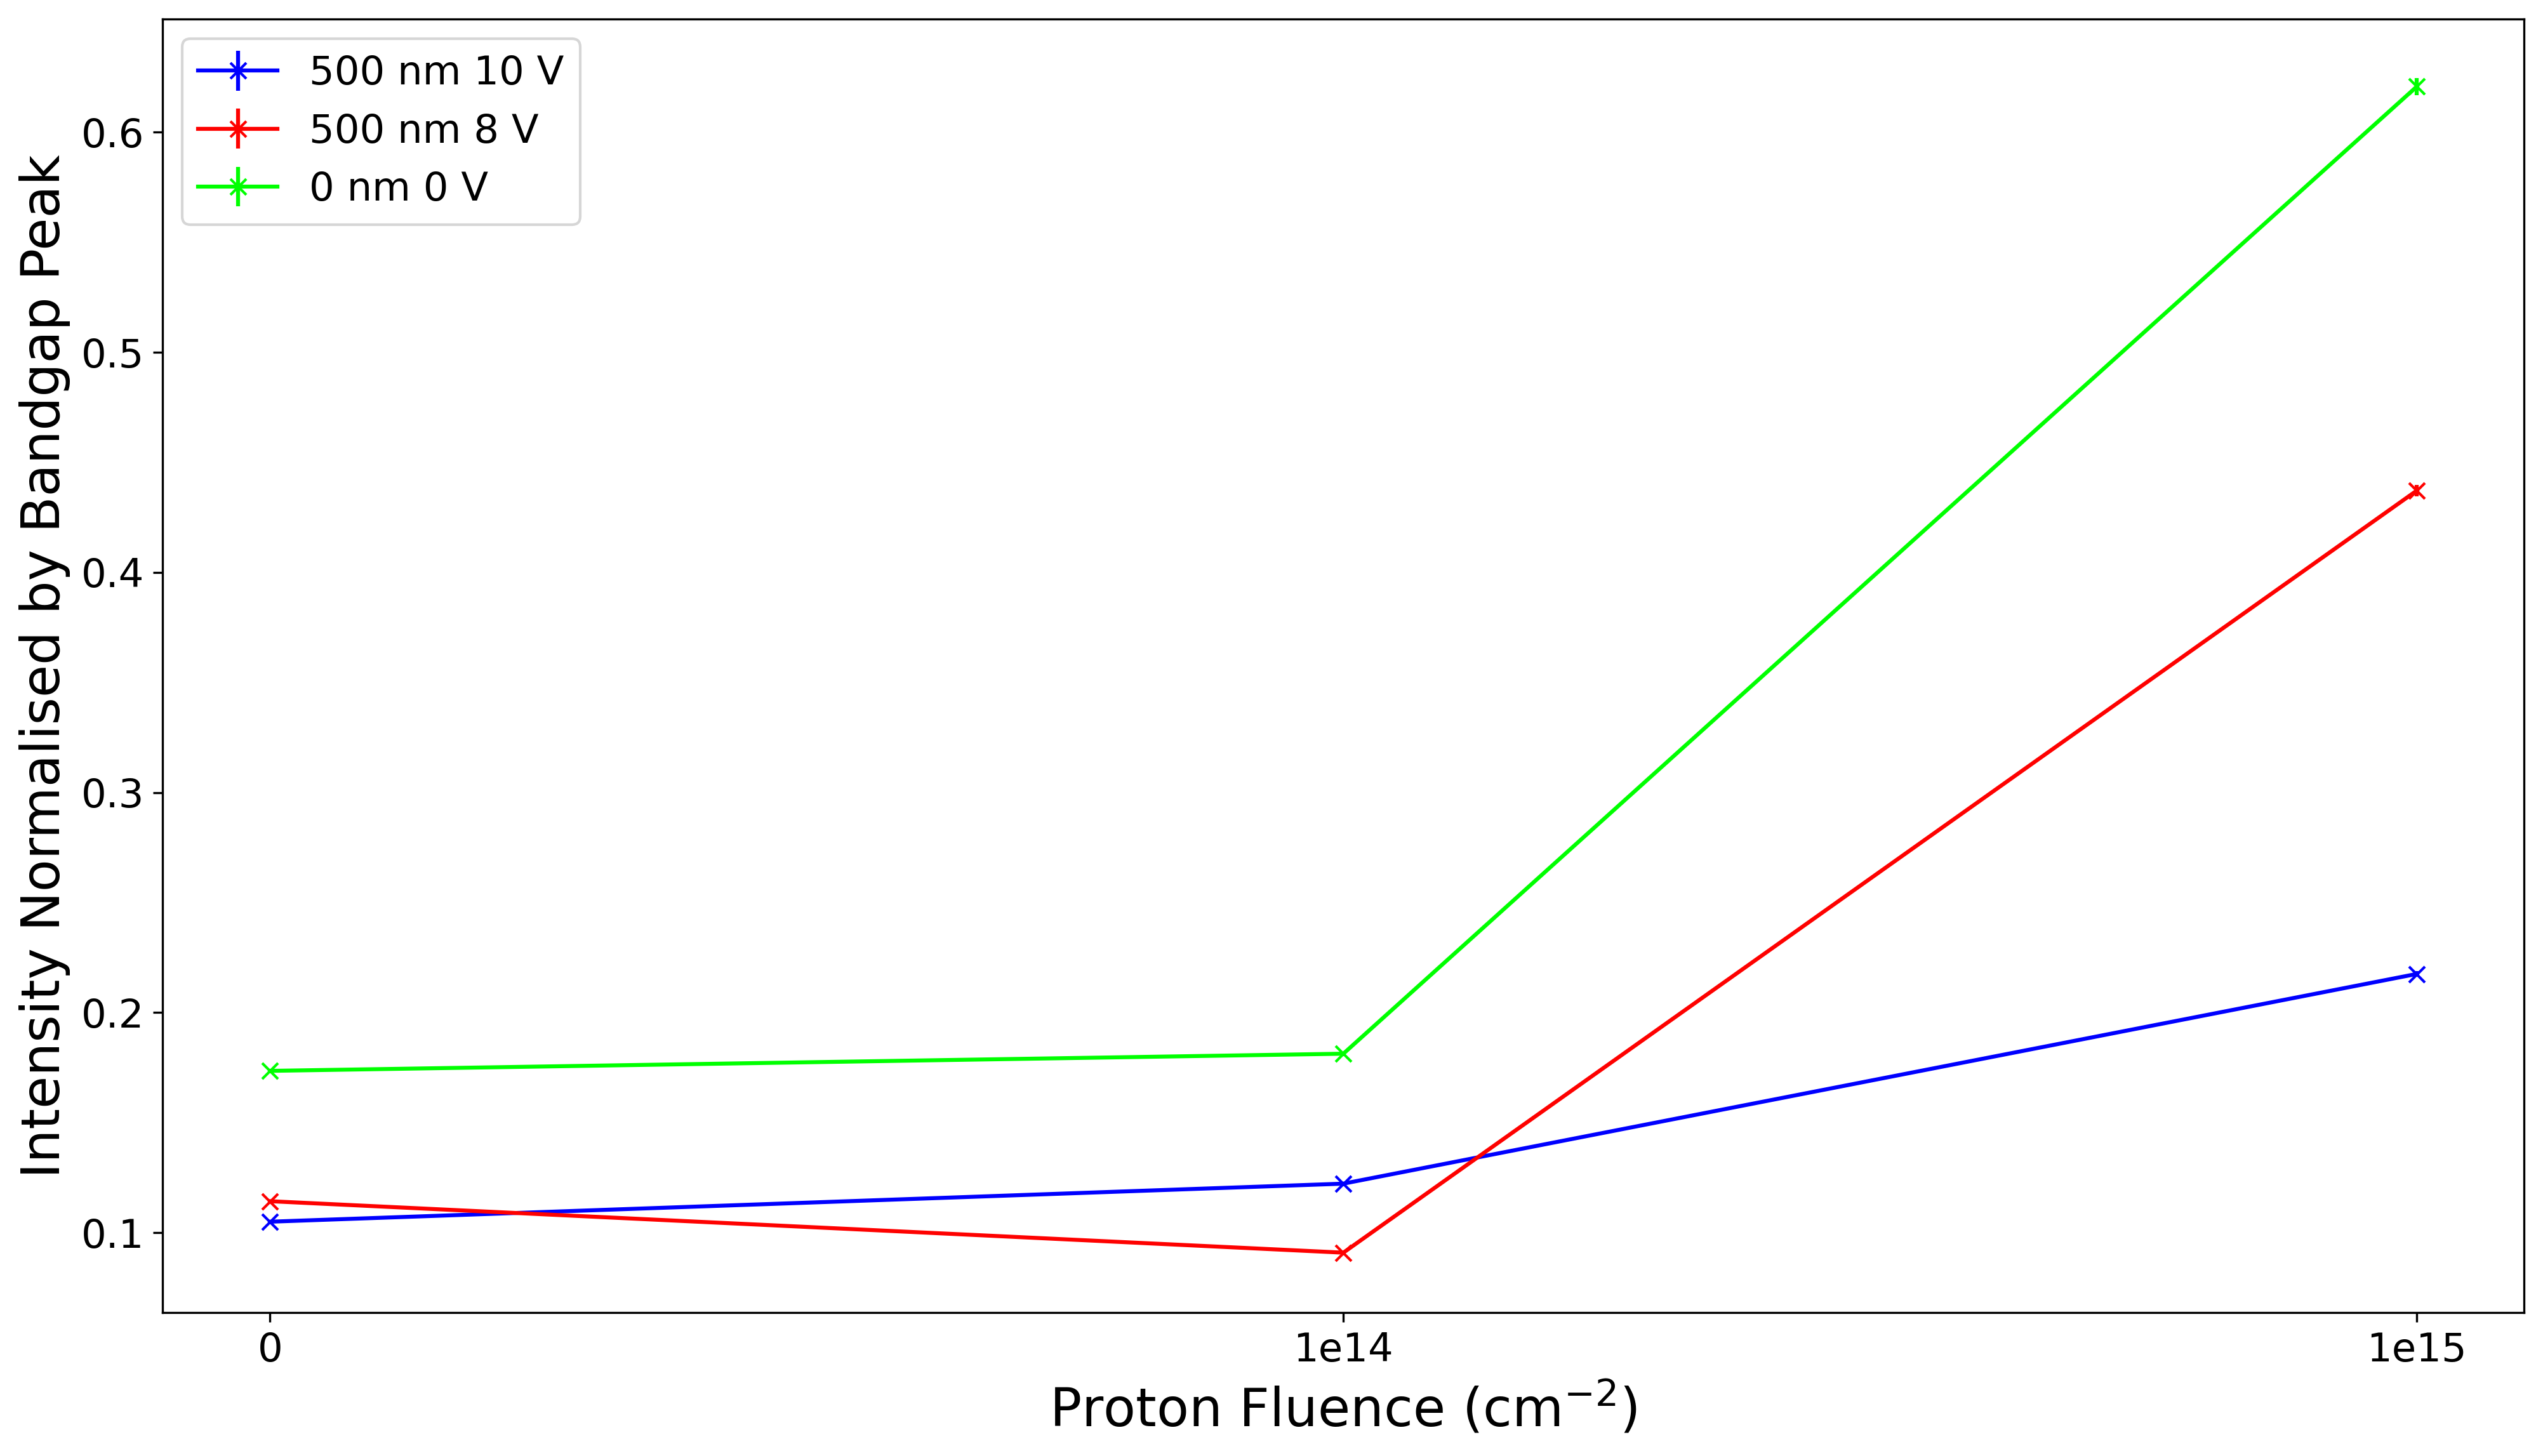

In [20]:

%matplotlib inline

fg_size = (16,9)
fg_dpi = 300
ax_fsize = 20
tick_fsize = 15
leg_fsize = 15

# plot normalised to main bandgap height

cmap = plt.cm.get_cmap('brg') # use any colormap you like
plt.figure(figsize=fg_size, dpi=fg_dpi)
plt.ylabel("Normalised Peak Intensity by Brightest", fontsize=ax_fsize)
plt.xlabel("Proton Fluence (cm$^{-2}$)", fontsize=ax_fsize)
i=0
for material in peak_values_df.drop(["Fluence"], axis=1).columns:
    if True in np.array(np.isnan(peak_values_df[material])):
        continue
    # plot normalised by all data
    
    # find max index assuming in no exposure
    max_idx = 0
    max_col = peak_values_df.idxmax(axis = 1, skipna = True)[max_idx]
    #print(peak_values_df.drop(["Fluence"], axis=1).max()[0]==peak_values_df[max_col][max_idx])
    
    norm_peak_vals = peak_values_df[material]/peak_values_df[max_col][max_idx]
    std_error = norm_peak_vals * ((std_error_values_df[material]/peak_values_df[material])+(std_error_values_df[max_col][max_idx]/peak_values_df[max_col][max_idx]))
    
    col = cmap(i/(len(peak_values_df.drop("Fluence", axis=1).columns)))
    plt.errorbar([0,1,2],norm_peak_vals, yerr=std_error, label = material, linestyle="-", color=col, marker ="x")

    i +=2
plt.xticks([0,1,2],["0","1e14","1e15"], fontsize = tick_fsize)
plt.yticks(fontsize = tick_fsize)
plt.legend(fontsize = leg_fsize, loc="best")
#plt.savefig("Normalised yellow peak intensity by bandgap peak.png", bbox_inches='tight')

cmap = plt.cm.get_cmap('brg') # use any colormap you like
plt.figure(figsize=fg_size, dpi=fg_dpi)
plt.ylabel("Intensity Normalised by Bandgap Peak", fontsize=ax_fsize)
plt.xlabel("Proton Fluence (cm$^{-2}$)", fontsize=ax_fsize)
i=0
for material in peak_values_df.drop(["Fluence"], axis=1).columns:
    if True in np.array(np.isnan(peak_values_df[material])):
        continue
    # plot normalised by all data
    
    norm_peak_vals = yellow_peak_values_df[material]/peak_values_df[material]
    std_error = norm_peak_vals * ((y_std_error_values_df[material]/yellow_peak_values_df[material])+(std_error_values_df[material]/peak_values_df[material]))
    

    col = cmap(i/(len(peak_values_df.drop("Fluence", axis=1).columns)))
    plt.errorbar([0,1,2],norm_peak_vals, yerr=std_error, label = material, linestyle="-", color=col, marker ="x")
    i+=2

plt.xticks([0,1,2],["0","1e14","1e15"], fontsize = tick_fsize)
plt.yticks(fontsize = tick_fsize)
plt.legend(fontsize = leg_fsize, loc="best")
#plt.savefig("Normalised yellow peak intensity by bandgap peak.png", bbox_inches='tight')

## Segmented CL Maps

### Data Extraction

Extract data and make necessary corrections.

In [21]:
# Assign folder location
folder = Path("C:/Users/es758/OneDrive - University of Cambridge/NanoDTC/Mini 2/CL/CL Session 2 and 3/CL Maps")

# Choose any folders to be skipped
skipped_data = [
    "HYP-HYP-T1-3KV-1NA-25NM-500NM-3",
    "HYP-HYP-500NMHVNE-3KV-1NA-25NM-500NM-2",
    "HYP-HYP-500NMHVNE-3KV-1NA-25NM-500NM-3",
    "HYP-HYP-500NMHVLE-3KV-1NA-25NM-500NM-3"
]
skipped_data_path_list = [folder/skipped for skipped in skipped_data]

# Extract data as CL_data objects
CL_40_list=[]
for subfolder in get_subfolders(folder):
    if subfolder not in skipped_data_path_list:
        CL_40 = CL_data(subfolder)
        print(CL_40.name, CL_40.hyp_dwelltime, CL_40.attomic_zoom)
        
        # adjust absolute intensity for different dwelltimes
        if CL_40.hyp_dwelltime < 100.000001:
            CL_40.CL_map.data *= CL_40.hyp_dwelltime/100.000001
            print("Note counts increased by a factor of: ", CL_40.hyp_dwelltime/100.000001)
        CL_40_list.append(CL_40)
        

# Remove spikes and background
for CL_data_entry in CL_40_list:
    CL_data_entry.remove_spikes()
    CL_data_entry.remove_background()

print("Done")

  0%|          | 0/16384 [00:00<?, ?it/s]

HYP-500NMHVHE-3KV-1NA-25UM-500NM-1 100.000001 40


  0%|          | 0/16384 [00:00<?, ?it/s]

HYP-500NMHVLE-3KV-1NA-25UM-500NM-1 100.000001 40


  0%|          | 0/16384 [00:00<?, ?it/s]

HYP-500NMHVNE-3KV-1NA-25UM-500NM-1 100.000001 40


  0%|          | 0/16384 [00:00<?, ?it/s]

HYP-HYP-500NMLVHE-3KV-1NA-25NM-500NM-2-001 100.000001 40


  0%|          | 0/16384 [00:00<?, ?it/s]

HYP-HYP-500NMLVLE-3KV-1NA-25NM-500NM-4 100.000001 40


  0%|          | 0/16384 [00:00<?, ?it/s]

HYP-HYP-500NMLVNE-3KV-1NA-25NM-500NM-3 100.000001 40


  0%|          | 0/16384 [00:00<?, ?it/s]

HYP-HYP-500NMNVNE-3KV-1NA-25NM-500NM-2 21.269999 40
Note counts increased by a factor of:  0.21269998787300012


  0%|          | 0/16384 [00:00<?, ?it/s]

HYP-HYP-T0-3KV-1NA-25NM-500NM-2 50.000001 40
Note counts increased by a factor of:  0.500000005


  0%|          | 0/16384 [00:00<?, ?it/s]

HYP-HYP-T1-3KV-1NA-25NM-500NM-2 50.000001 40
Note counts increased by a factor of:  0.500000005


  0%|          | 0/16384 [00:00<?, ?it/s]

HYP-T2-3KV-1NA-25UM-500NM-1 100.000001 40
Done


Sort data into pandas df.

In [22]:
structure = {
    "Fluence": [0.0, 1e14, 1e15]
    
}

map_spectra_df = pd.DataFrame(structure)
for scan in CL_40_list:
    map_spectra_df.loc[map_spectra_df.index[map_spectra_df["Fluence"]==scan.proton_fluence][0],str(int(scan.porous_thickness)) + " nm " + str(scan.etch_volt)+ " V"] = scan
    
map_spectra_df

Fluence                                      500 nm 10 V  \
0  0.000000e+00  <__main__.CL_data object at 0x000002B49B4A00A0>   
1  1.000000e+14  <__main__.CL_data object at 0x000002B4966C3190>   
2  1.000000e+15  <__main__.CL_data object at 0x000002B49CD57190>   

                                        500 nm 8 V  \
0  <__main__.CL_data object at 0x000002B4967D87C0>   
1  <__main__.CL_data object at 0x000002B49BA01430>   
2  <__main__.CL_data object at 0x000002B49D3BE160>   

                                        500 nm 0 V  \
0  <__main__.CL_data object at 0x000002B499412400>   
1                                              NaN   
2                                              NaN   

                                          0 nm 0 V  
0  <__main__.CL_data object at 0x000002B49B8F6D00>  
1  <__main__.CL_data object at 0x000002B4993ADB20>  
2  <__main__.CL_data object at 0x000002B49B86E0D0>

Functions to actually segment images and find average spectra.

In [23]:
def segment_by_porosity(CL_data_object, GaN_lam_index = 245, GaN_threshold = 0.34, np_lam_index = 270, np_threshold = 0.39):
    
    # Define GaN mask (inverse of dislocation mask)
    base = CL_data_object.CL_map.data[:,:,GaN_lam_index].copy()
    base_1d = base.flatten()
    idx_1d = base_1d.argsort()
    criteria_val = base_1d[idx_1d[-5]]
    GaN_mask = np.where(base>criteria_val*GaN_threshold, True, False)
    
    # Define non-porous mask
    base = CL_data_object.CL_map.data[:,:,np_lam_index].copy()
    if CL_data_object.etch_volt != 0:
        NP_mask = np.where(base>(np.max(base)*np_threshold), True, False)
        # Define porous mask from what's left
        P_mask = GaN_mask*np.invert(NP_mask)
    else:
        # NP is just GaN
        NP_mask = GaN_mask
        # No porous material for no etching
        P_mask = bool_arr = np.zeros(base.shape, dtype=bool)
    
    return GaN_mask, NP_mask, P_mask

def average_spectra_by_mask(mask, CL_data_object):
    # initialise sum of spectra and counter of pixels where mask is True
    sum_of_spectra = np.zeros(CL_data_object.CL_map.data.shape[2])
    mask_true_counter = 0
    # for each row
    for row in np.arange(mask.shape[0]):
        # for each col
        for col in np.arange(mask.shape[1]):
            # now at pixel level
            # add to sum if mask is True
            if mask[row][col] == True:
                sum_of_spectra += CL_data_object.CL_map.data[row][col]
                mask_true_counter += 1
    # Form average spectra
    average_spectra = sum_of_spectra/mask_true_counter
    return average_spectra

def find_peak_and_std_error(mask, CL_data_object, idx_lower = 0, idx_upper = -1):
    # initialise sum of spectra and counter of pixels where mask is True
    peak_list = []
    true_counter = 0
    # for each row
    for row in np.arange(mask.shape[0]):
        # for each col
        for col in np.arange(mask.shape[1]):
            # now at pixel level
            # add to sum if mask is True
            if mask[row][col] == True:
                peak = np.max(CL_data_object.CL_map.data[row][col][idx_lower:idx_upper])
                peak_list.append(peak)
                true_counter += 1
    # Form average spectra
    average_peak = np.mean(peak_list)
    peak_std_error = np.std(peak_list)/np.sqrt(true_counter)
    return average_peak, peak_std_error

### Segmentation Testing

Tweaking of segementation settings to data.

In [491]:
%matplotlib qt
CL_40_list[3].CL_map.T.plot()

HYP-HYP-500NMLVHE-3KV-1NA-25NM-500NM-2-001


(-0.5, 127.5, 127.5, -0.5)

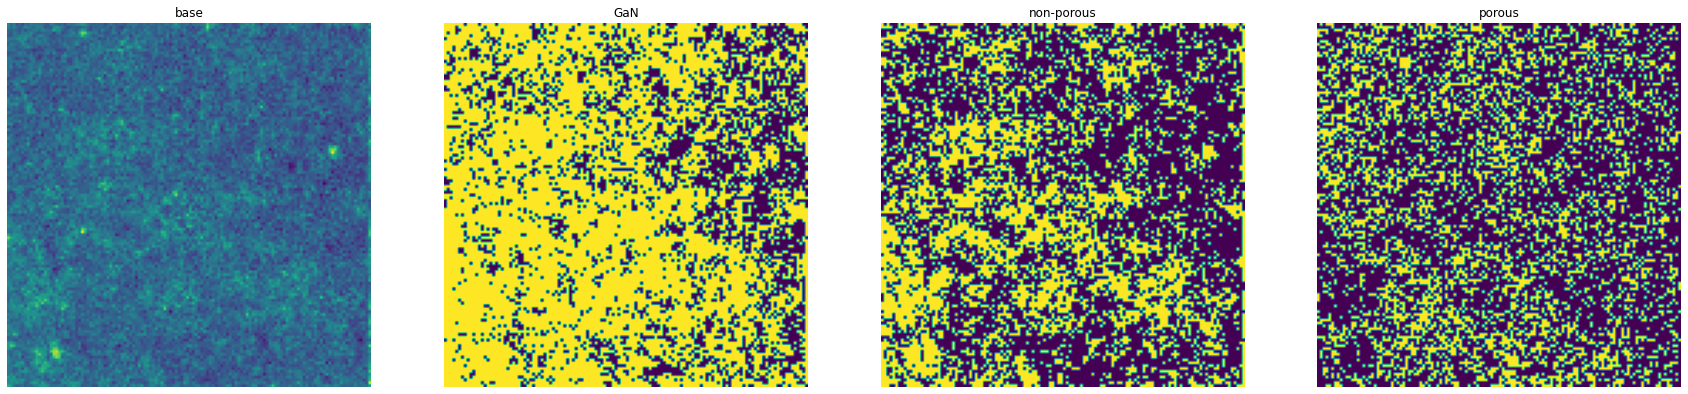

In [433]:
%matplotlib inline
i=3
print(CL_40_list[i].name)
GaN_mask, NP_mask, P_mask = segment_by_porosity(CL_40_list[i], GaN_lam_index=250, GaN_threshold=0.32,np_lam_index=256, np_threshold=0.37)
# Plot segmentation results
fig, axarr = plt.subplots(1,4, figsize=(30,30))
axarr[0].imshow(CL_40_list[i].CL_map.data[:,:,256])
axarr[0].set_title("base")
axarr[0].axis("off")
axarr[1].imshow(GaN_mask)
axarr[1].set_title("GaN")
axarr[1].axis("off")
axarr[2].imshow(NP_mask)
axarr[2].set_title("non-porous")
axarr[2].axis("off")
axarr[3].imshow(P_mask)
axarr[3].set_title("porous")
axarr[3].axis("off")
#fig.suptitle(CL_40.name)

Text(0.5, 0.98, 'HYP-HYP-500NMLVHE-3KV-1NA-25NM-500NM-2-001')

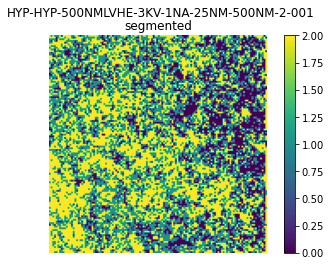

In [437]:
%matplotlib inline
i=3
GaN_mask, NP_mask, P_mask = segment_by_porosity(CL_40_list[i], GaN_lam_index=250, GaN_threshold=0.32,np_lam_index=256, np_threshold=0.37)
NP_mask = np.where(NP_mask == True, 2*np.ones(NP_mask.shape), np.zeros(NP_mask.shape))
P_mask = np.where(P_mask == True, np.ones(P_mask.shape), np.zeros(P_mask.shape))
# Plot segmentation results
fig, axarr = plt.subplots(1,1)
im1 = axarr.imshow(P_mask+NP_mask, cmap="viridis")
bar1=plt.colorbar(im1)
axarr.set_title("segmented")
axarr.axis("off")
fig.suptitle(CL_40_list[i].name)

### Segment and Analyse Data Sets

Apply segmentation to data and extract average spectra and the average peak values (separate operations in case of shifts in peak wavelength).

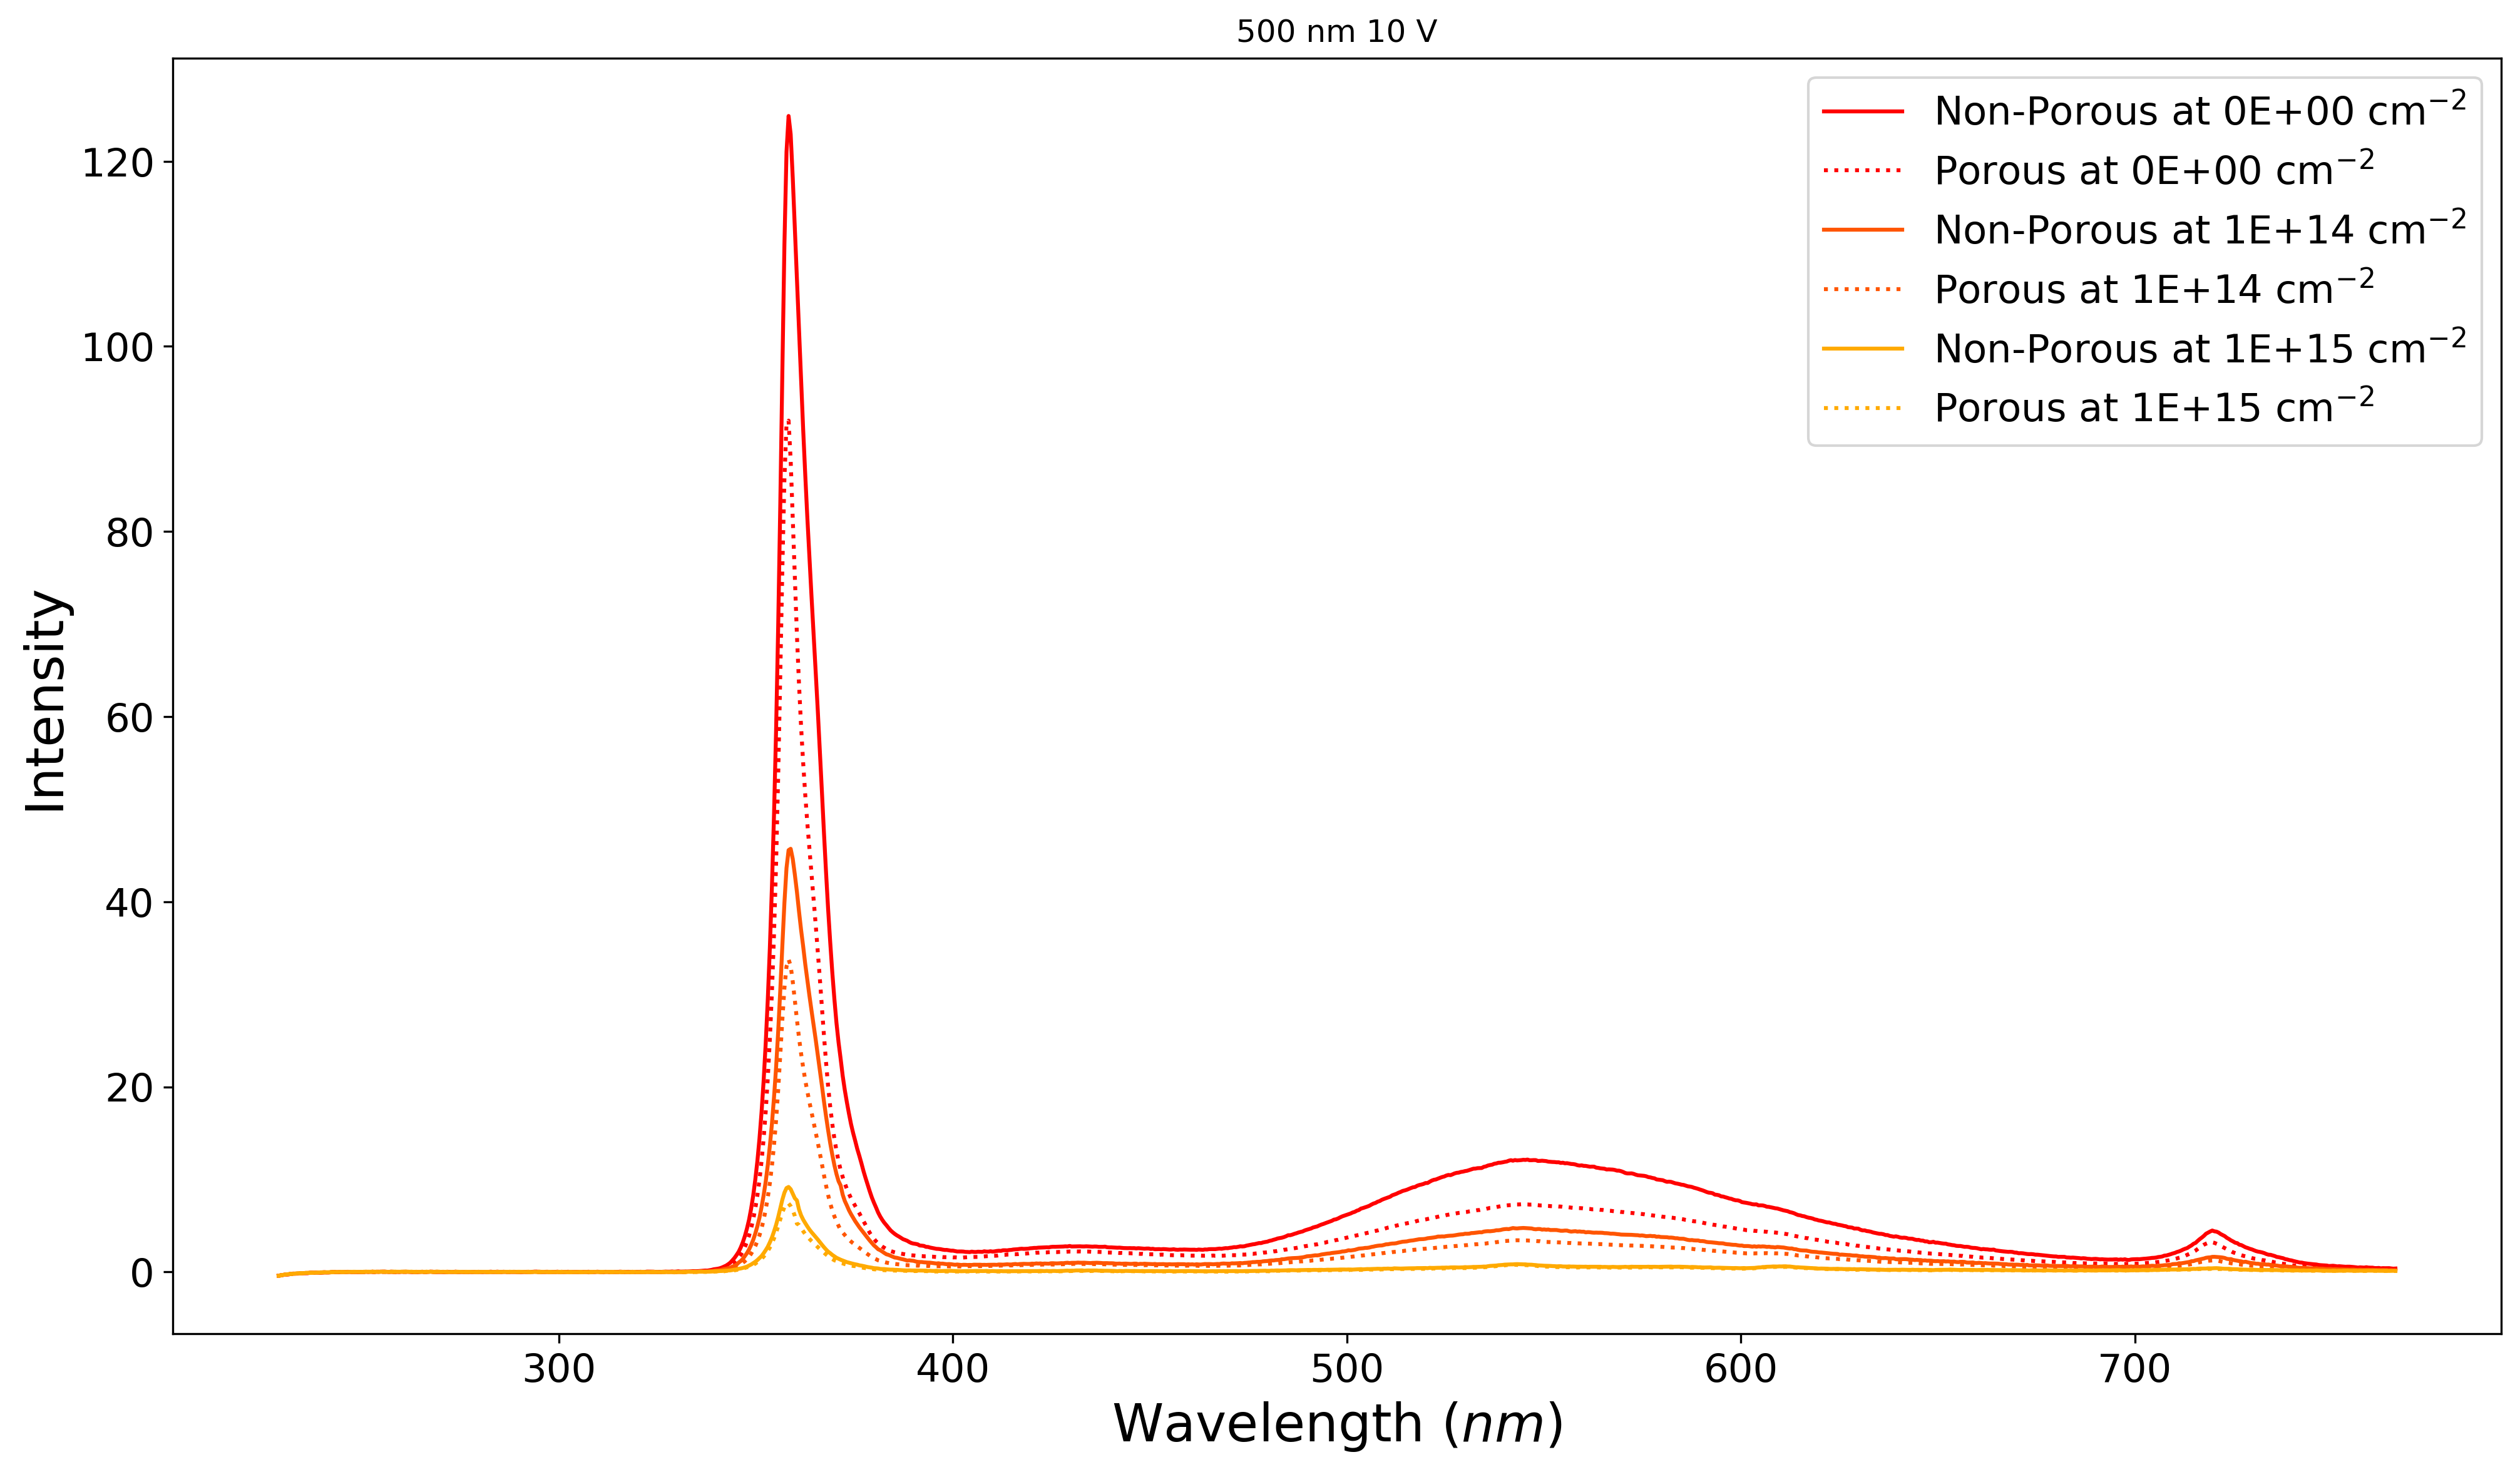

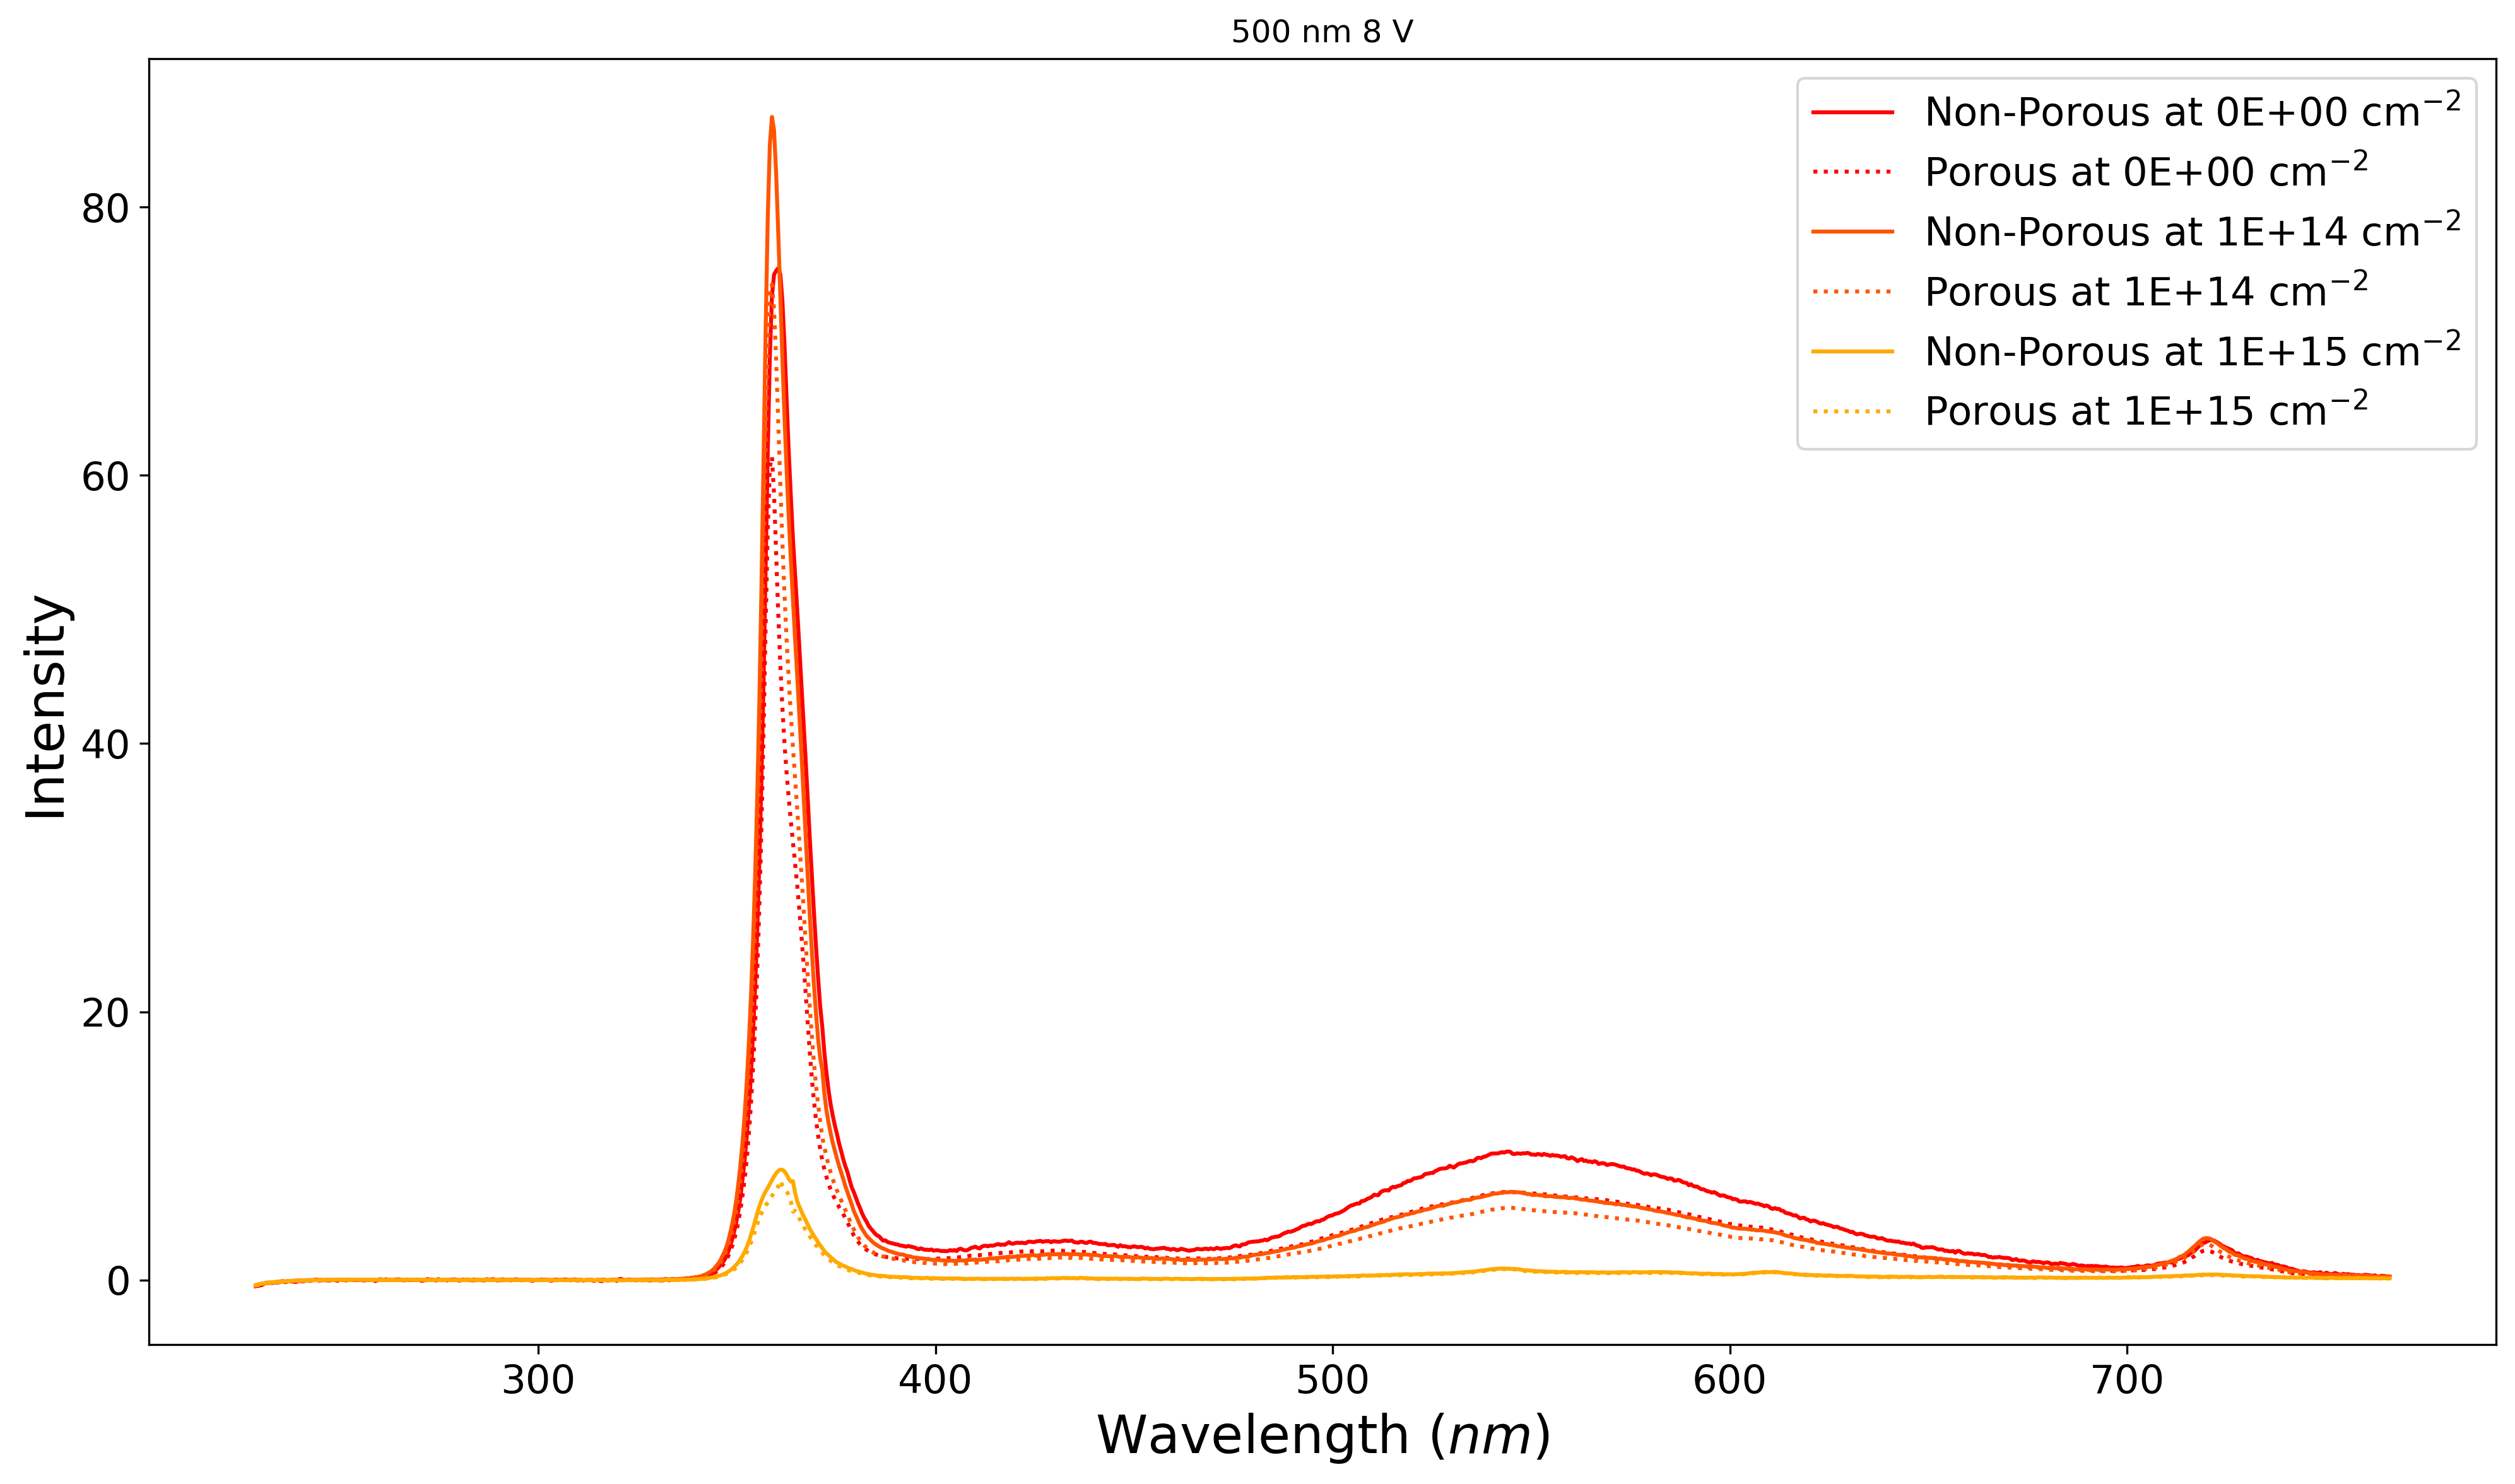

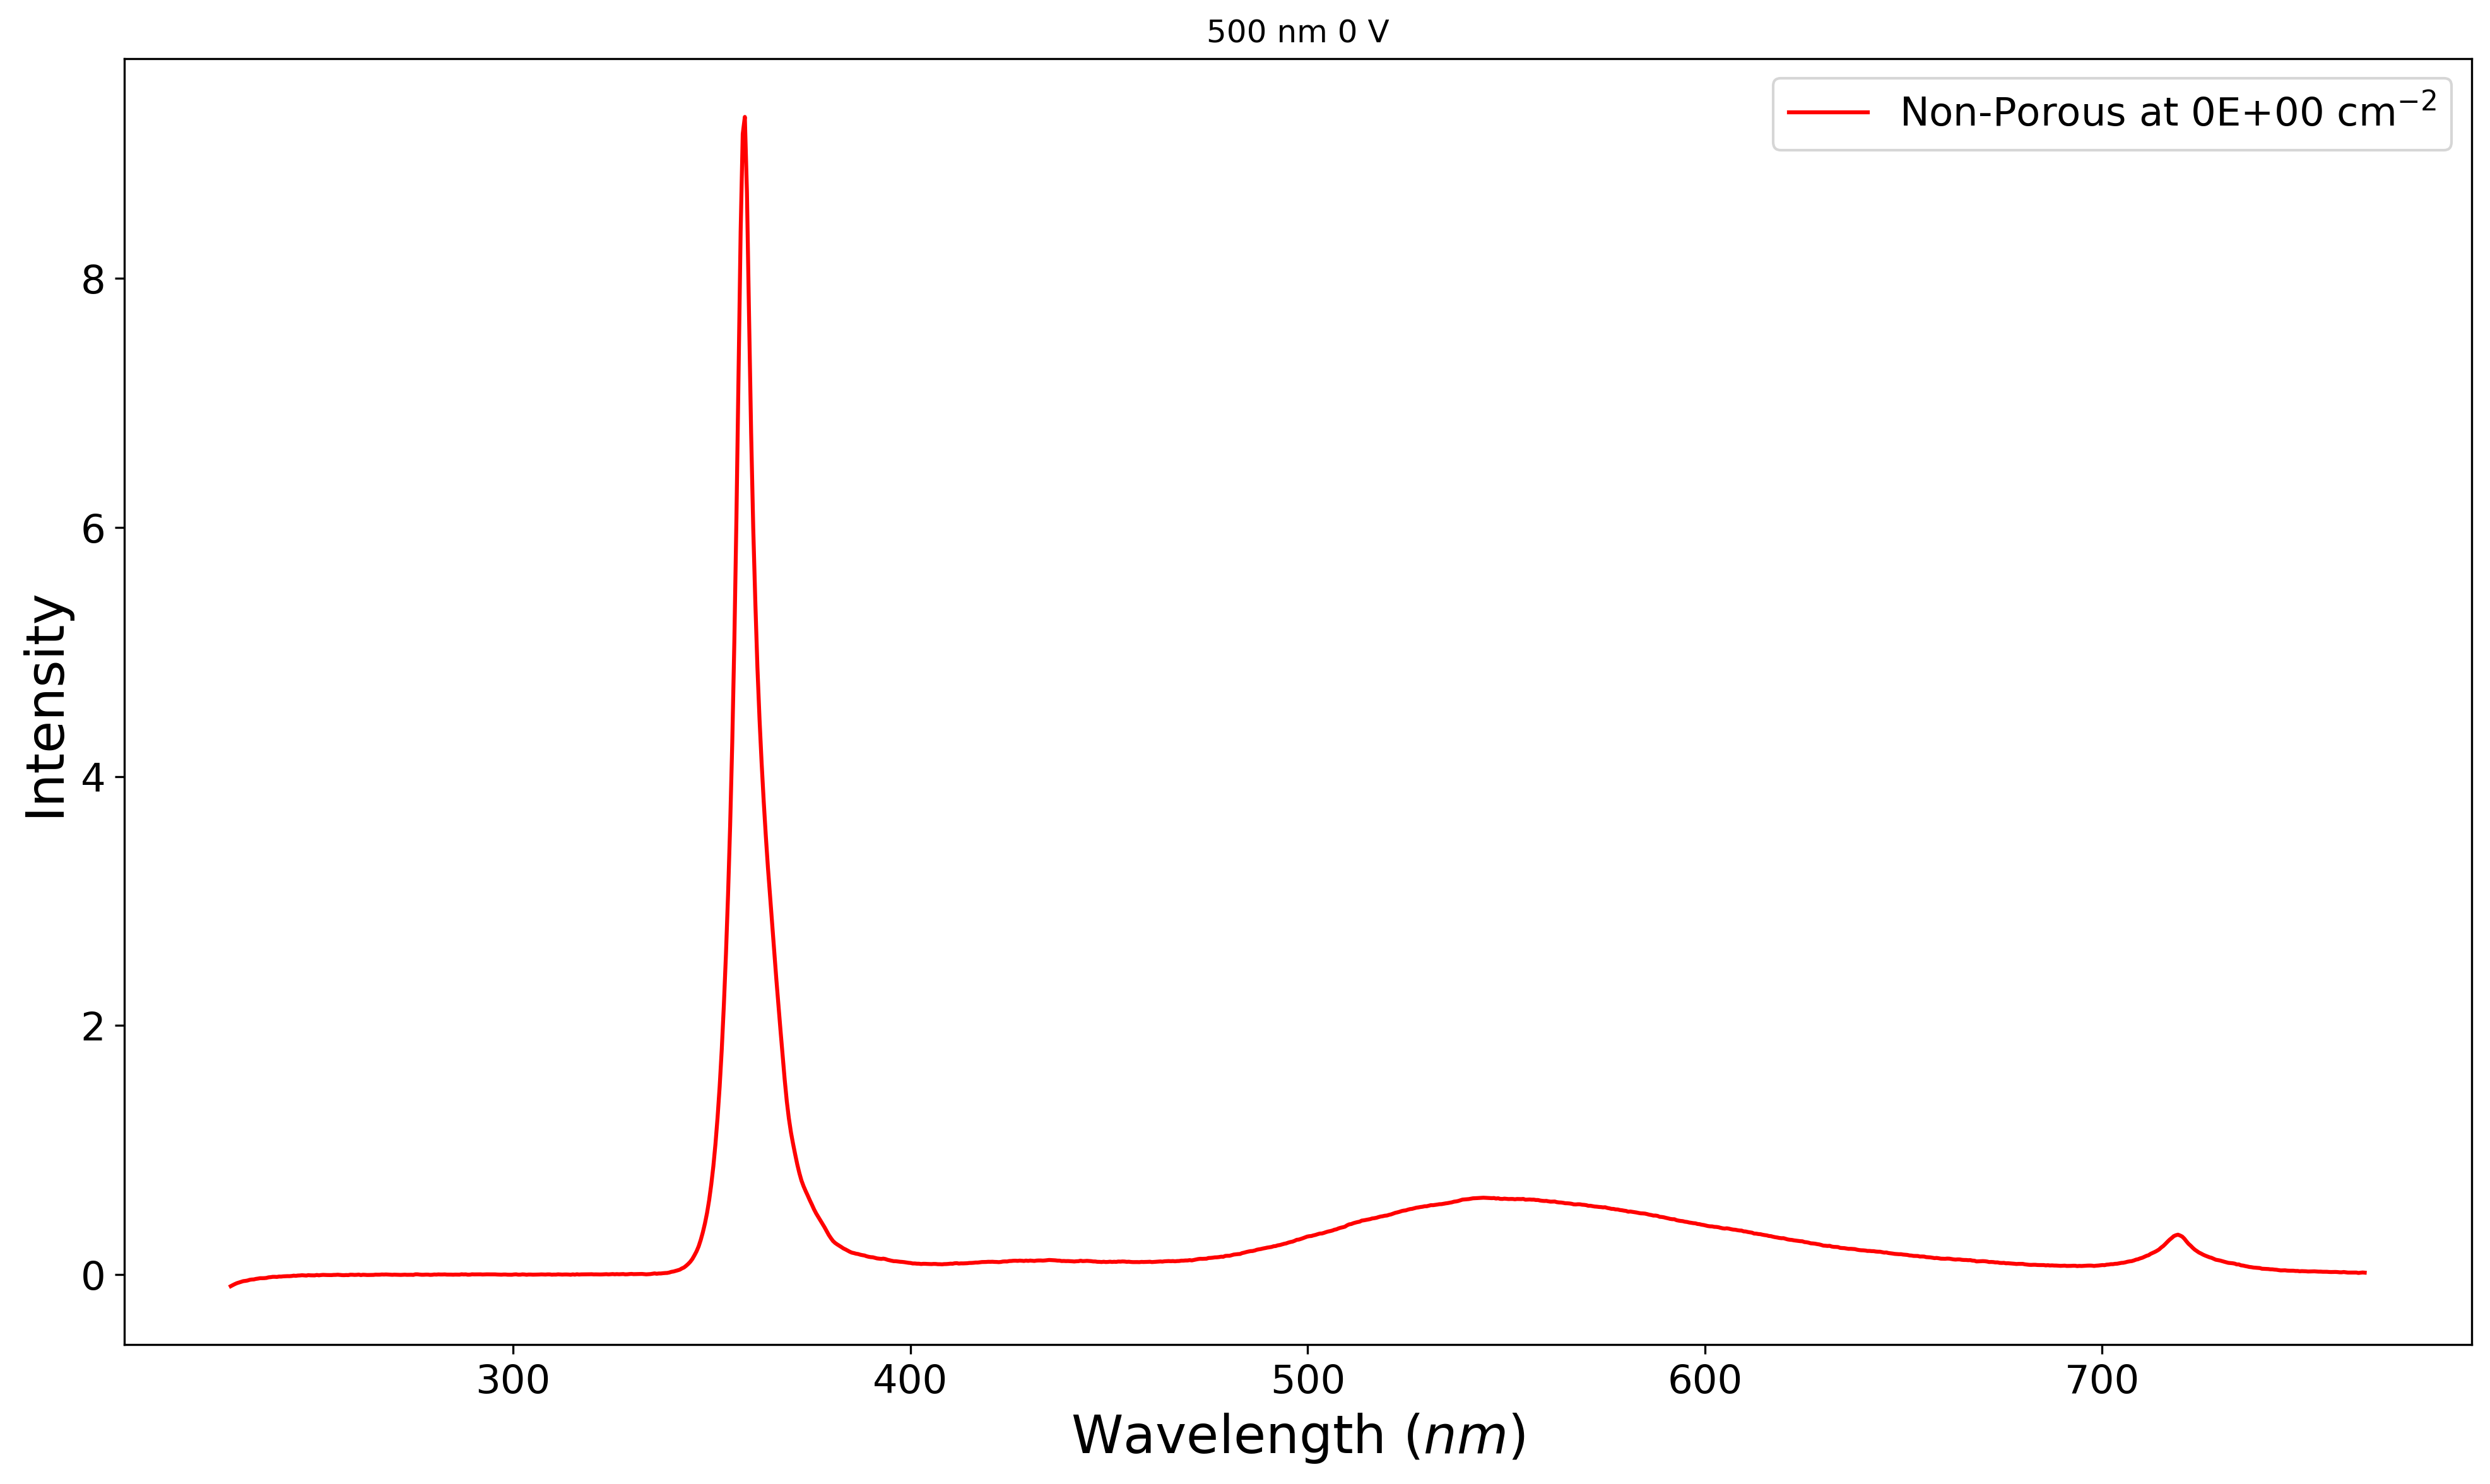

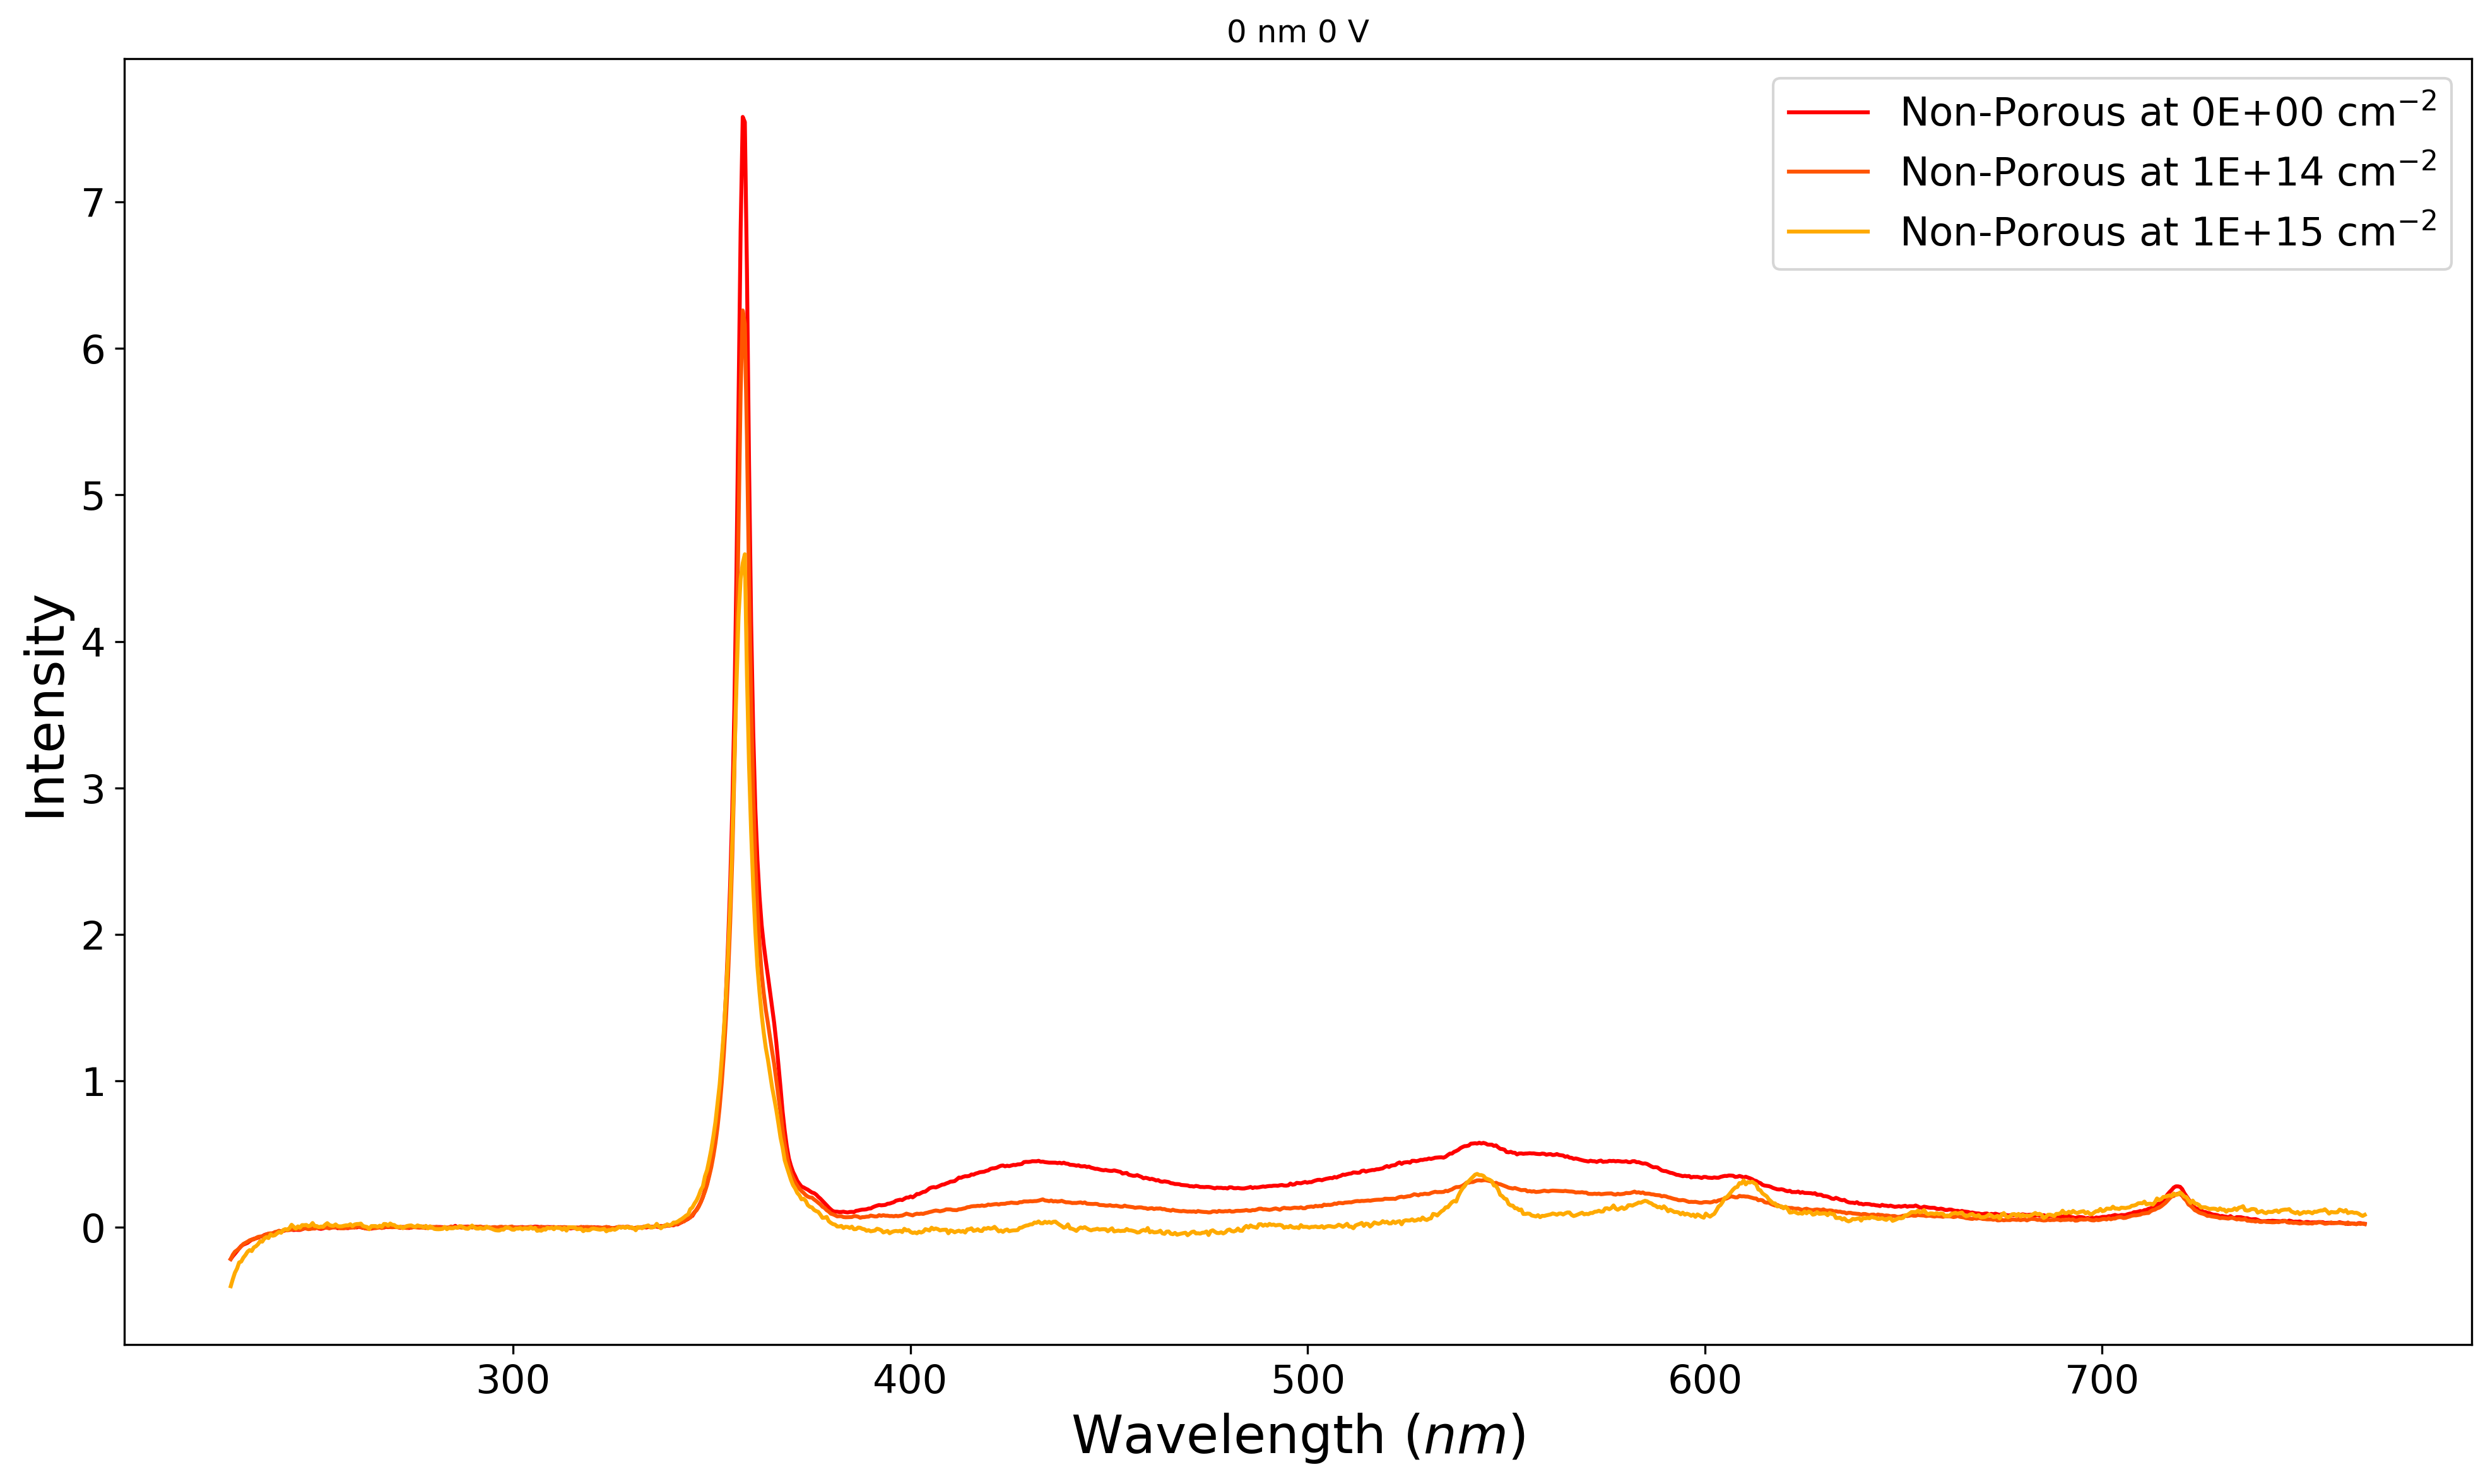

In [24]:
%matplotlib inline

fg_size = (16,9)
fg_dpi = 300
ax_fsize = 20
tick_fsize = 15
leg_fsize = 15

# new data frames to hold results
structure = {
    "Fluence": [0.0, 1e14, 1e15]
    
}
peak_values_df = pd.DataFrame(structure)
std_error_values_df = pd.DataFrame(structure)
yellow_peak_values_df = pd.DataFrame(structure)
y_std_error_values_df = pd.DataFrame(structure)

mask_array = []

# iterate over columns
for structure in map_spectra_df.columns:
    
    # skip Fluence column
    if structure == 'Fluence':
        continue
        
    # initialise some plot stuff
    fig = plt.figure(structure, figsize=fg_size, dpi = fg_dpi)
    ax = fig.add_subplot(1,1,1)
    line_styles = ["-", ":"]
    
    # iterate over entries in column
    for sample in map_spectra_df[structure]:
        
        
        
        # handle found data
        if type(sample) == type(map_spectra_df[structure][0]): # will always have at least a 0 exposed sample
            
            # find masks
            GaN_mask, NP_mask, P_mask = segment_by_porosity(sample)
            
            # Special tailoring of settings for certain samples
            if sample.proton_fluence == 1e15 and sample.etch_volt == 10:
                GaN_mask, NP_mask, P_mask = segment_by_porosity(sample, GaN_lam_index=249, GaN_threshold=0.25,np_lam_index=249, np_threshold=0.43)
            elif sample.proton_fluence == 1e15 and sample.etch_volt == 8:
                GaN_mask, NP_mask, P_mask = segment_by_porosity(sample, GaN_lam_index=250, GaN_threshold=0.32,np_lam_index=256, np_threshold=0.37)
            elif sample.proton_fluence == 0 and sample.etch_volt == 10:
                GaN_mask, NP_mask, P_mask = segment_by_porosity(sample, GaN_lam_index=245, GaN_threshold=0.28,np_lam_index=270, np_threshold=0.28)
                
                
            # store segmented images
            mask_array.append([sample, GaN_mask, NP_mask, P_mask])
            
            # find average spectra
            non_porous_average = average_spectra_by_mask(NP_mask, sample)
            if sample.etch_volt != 0:
                porous_average = average_spectra_by_mask(P_mask, sample)
            else:
                porous_average = np.empty(non_porous_average.shape)#np.nan
                porous_average[:] = np.nan
            
            # find peak values old
            # max_np = np.max(non_porous_average)
            # max_p = np.max(porous_average)
            # max_np_yellow = np.max(non_porous_average[513:703])
            # max_p_yellow = np.max(porous_average[513:703])
            
            # new peak and std error estimate
            max_np, np_std_error = find_peak_and_std_error(NP_mask, sample)
            max_np_yellow, y_np_std_error = find_peak_and_std_error(NP_mask, sample, idx_lower=513, idx_upper=703)
            if sample.etch_volt != 0:
                max_p, p_std_error = find_peak_and_std_error(P_mask, sample)
                max_p_yellow, y_p_std_error = find_peak_and_std_error(P_mask, sample, idx_lower=513, idx_upper=703)
            else:
                max_p, p_std_error = np.nan, np.nan
                max_p_yellow, y_p_std_error = np.nan, np.nan
            
            
            
            # store std error in df
            std_error_values_df.loc[map_spectra_df.index[map_spectra_df["Fluence"]==sample.proton_fluence][0],str(int(sample.porous_thickness)) + " nm " + str(sample.etch_volt)+ " V Non-Porous"] = np_std_error
            std_error_values_df.loc[map_spectra_df.index[map_spectra_df["Fluence"]==sample.proton_fluence][0],str(int(sample.porous_thickness)) + " nm " + str(sample.etch_volt)+ " V Porous"] = p_std_error
            y_std_error_values_df.loc[map_spectra_df.index[map_spectra_df["Fluence"]==sample.proton_fluence][0],str(int(sample.porous_thickness)) + " nm " + str(sample.etch_volt)+ " V Non-Porous"] = y_np_std_error
            y_std_error_values_df.loc[map_spectra_df.index[map_spectra_df["Fluence"]==sample.proton_fluence][0],str(int(sample.porous_thickness)) + " nm " + str(sample.etch_volt)+ " V Porous"] = y_p_std_error
            
            
            # store peaks in df
            peak_values_df.loc[map_spectra_df.index[map_spectra_df["Fluence"]==sample.proton_fluence][0],str(int(sample.porous_thickness)) + " nm " + str(sample.etch_volt)+ " V Non-Porous"] = max_np
            peak_values_df.loc[map_spectra_df.index[map_spectra_df["Fluence"]==sample.proton_fluence][0],str(int(sample.porous_thickness)) + " nm " + str(sample.etch_volt)+ " V Porous"] = max_p
            
            yellow_peak_values_df.loc[map_spectra_df.index[map_spectra_df["Fluence"]==sample.proton_fluence][0],str(int(sample.porous_thickness)) + " nm " + str(sample.etch_volt)+ " V Non-Porous"] = max_np_yellow
            yellow_peak_values_df.loc[map_spectra_df.index[map_spectra_df["Fluence"]==sample.proton_fluence][0],str(int(sample.porous_thickness)) + " nm " + str(sample.etch_volt)+ " V Porous"] = max_p_yellow
            
            # plot spectra
            
            cmap = plt.cm.get_cmap('autumn') # use any colormap you like
            df_index = map_spectra_df.index[map_spectra_df["Fluence"]==sample.proton_fluence][0]
            col = cmap(df_index/len(map_spectra_df))
            
            ax.plot(sample.wavelengths,non_porous_average, linestyle = line_styles[0], color = col, label ="Non-Porous at " f"{sample.proton_fluence:.0E}" + " cm$^{-2}$" )
            
            # plot porous if it exists for structure
            if sample.etch_volt != 0:
                ax.plot(sample.wavelengths, porous_average, linestyle = line_styles[1], color = col, label = "Porous at " f"{sample.proton_fluence:.0E}" + " cm$^{-2}$")
            

             
        # handle nans
        elif np.isnan(sample):
            continue
    ax.set_title(structure)    
    ax.set_xlabel("Wavelength ($nm$)", fontsize=ax_fsize)
    ax.set_ylabel("Intensity", fontsize=ax_fsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fsize)
    ax.tick_params(axis='both', which='minor', labelsize=tick_fsize)
    ax.legend(loc="best", fontsize=leg_fsize)
    #fig.savefig(structure+" CL map.png",bbox_inches="tight")

Check what you think of segmentation of all images

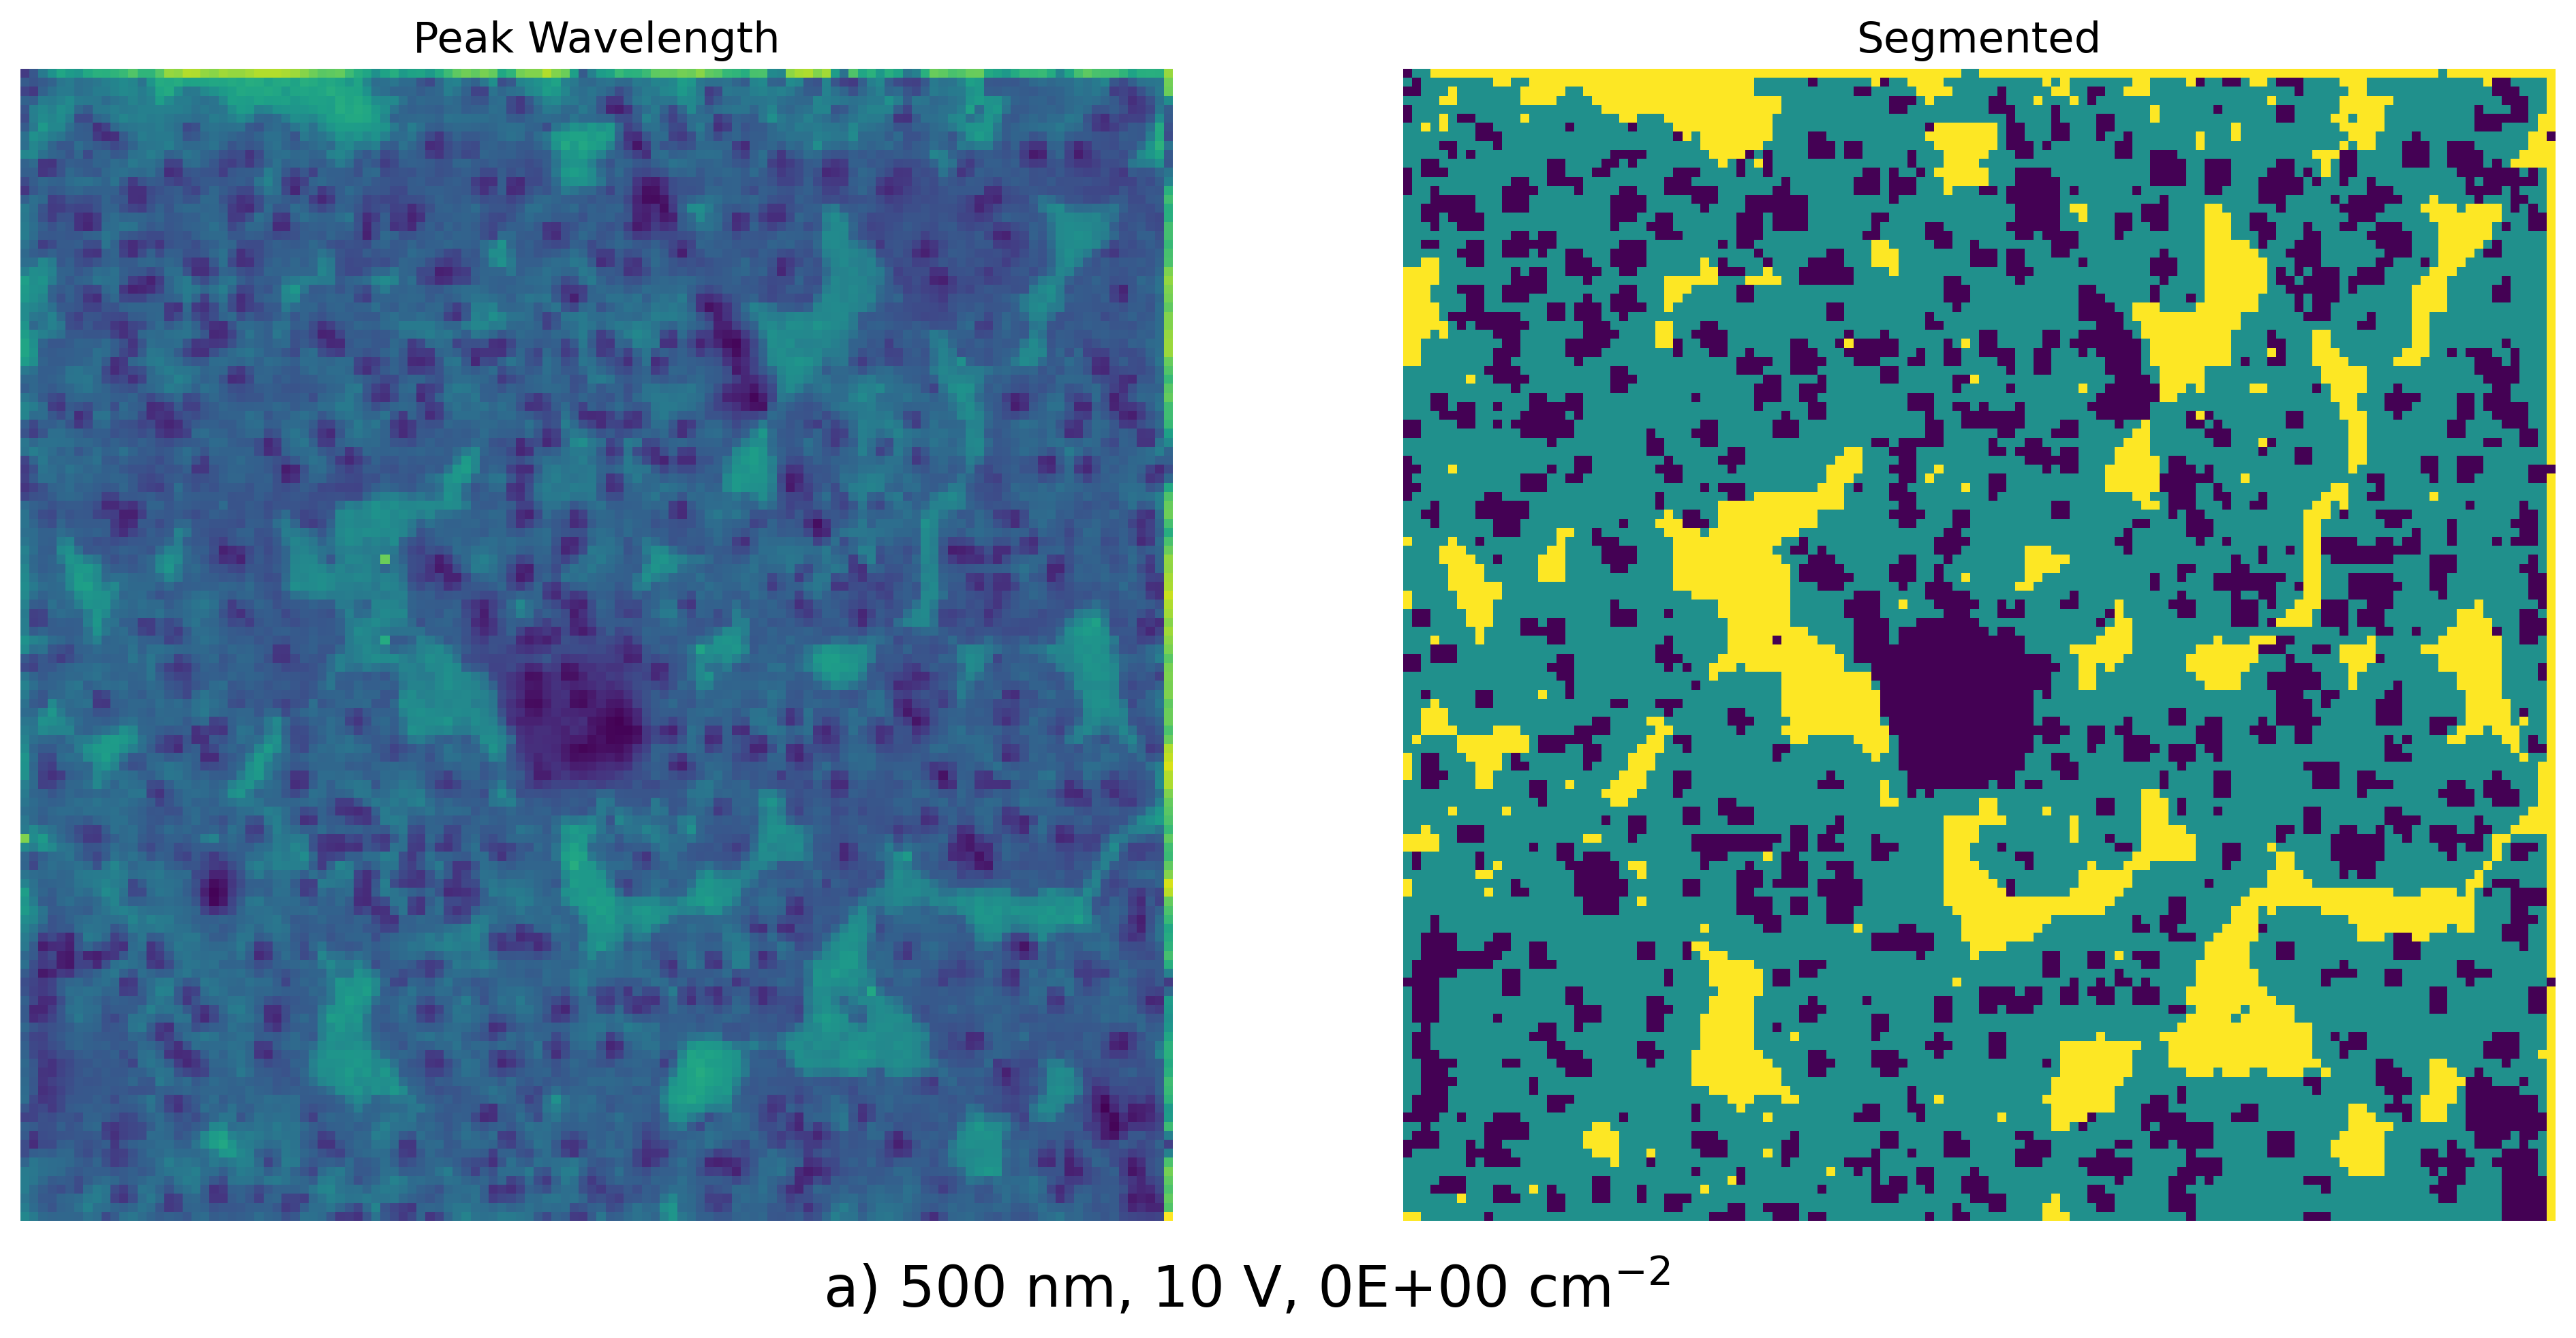

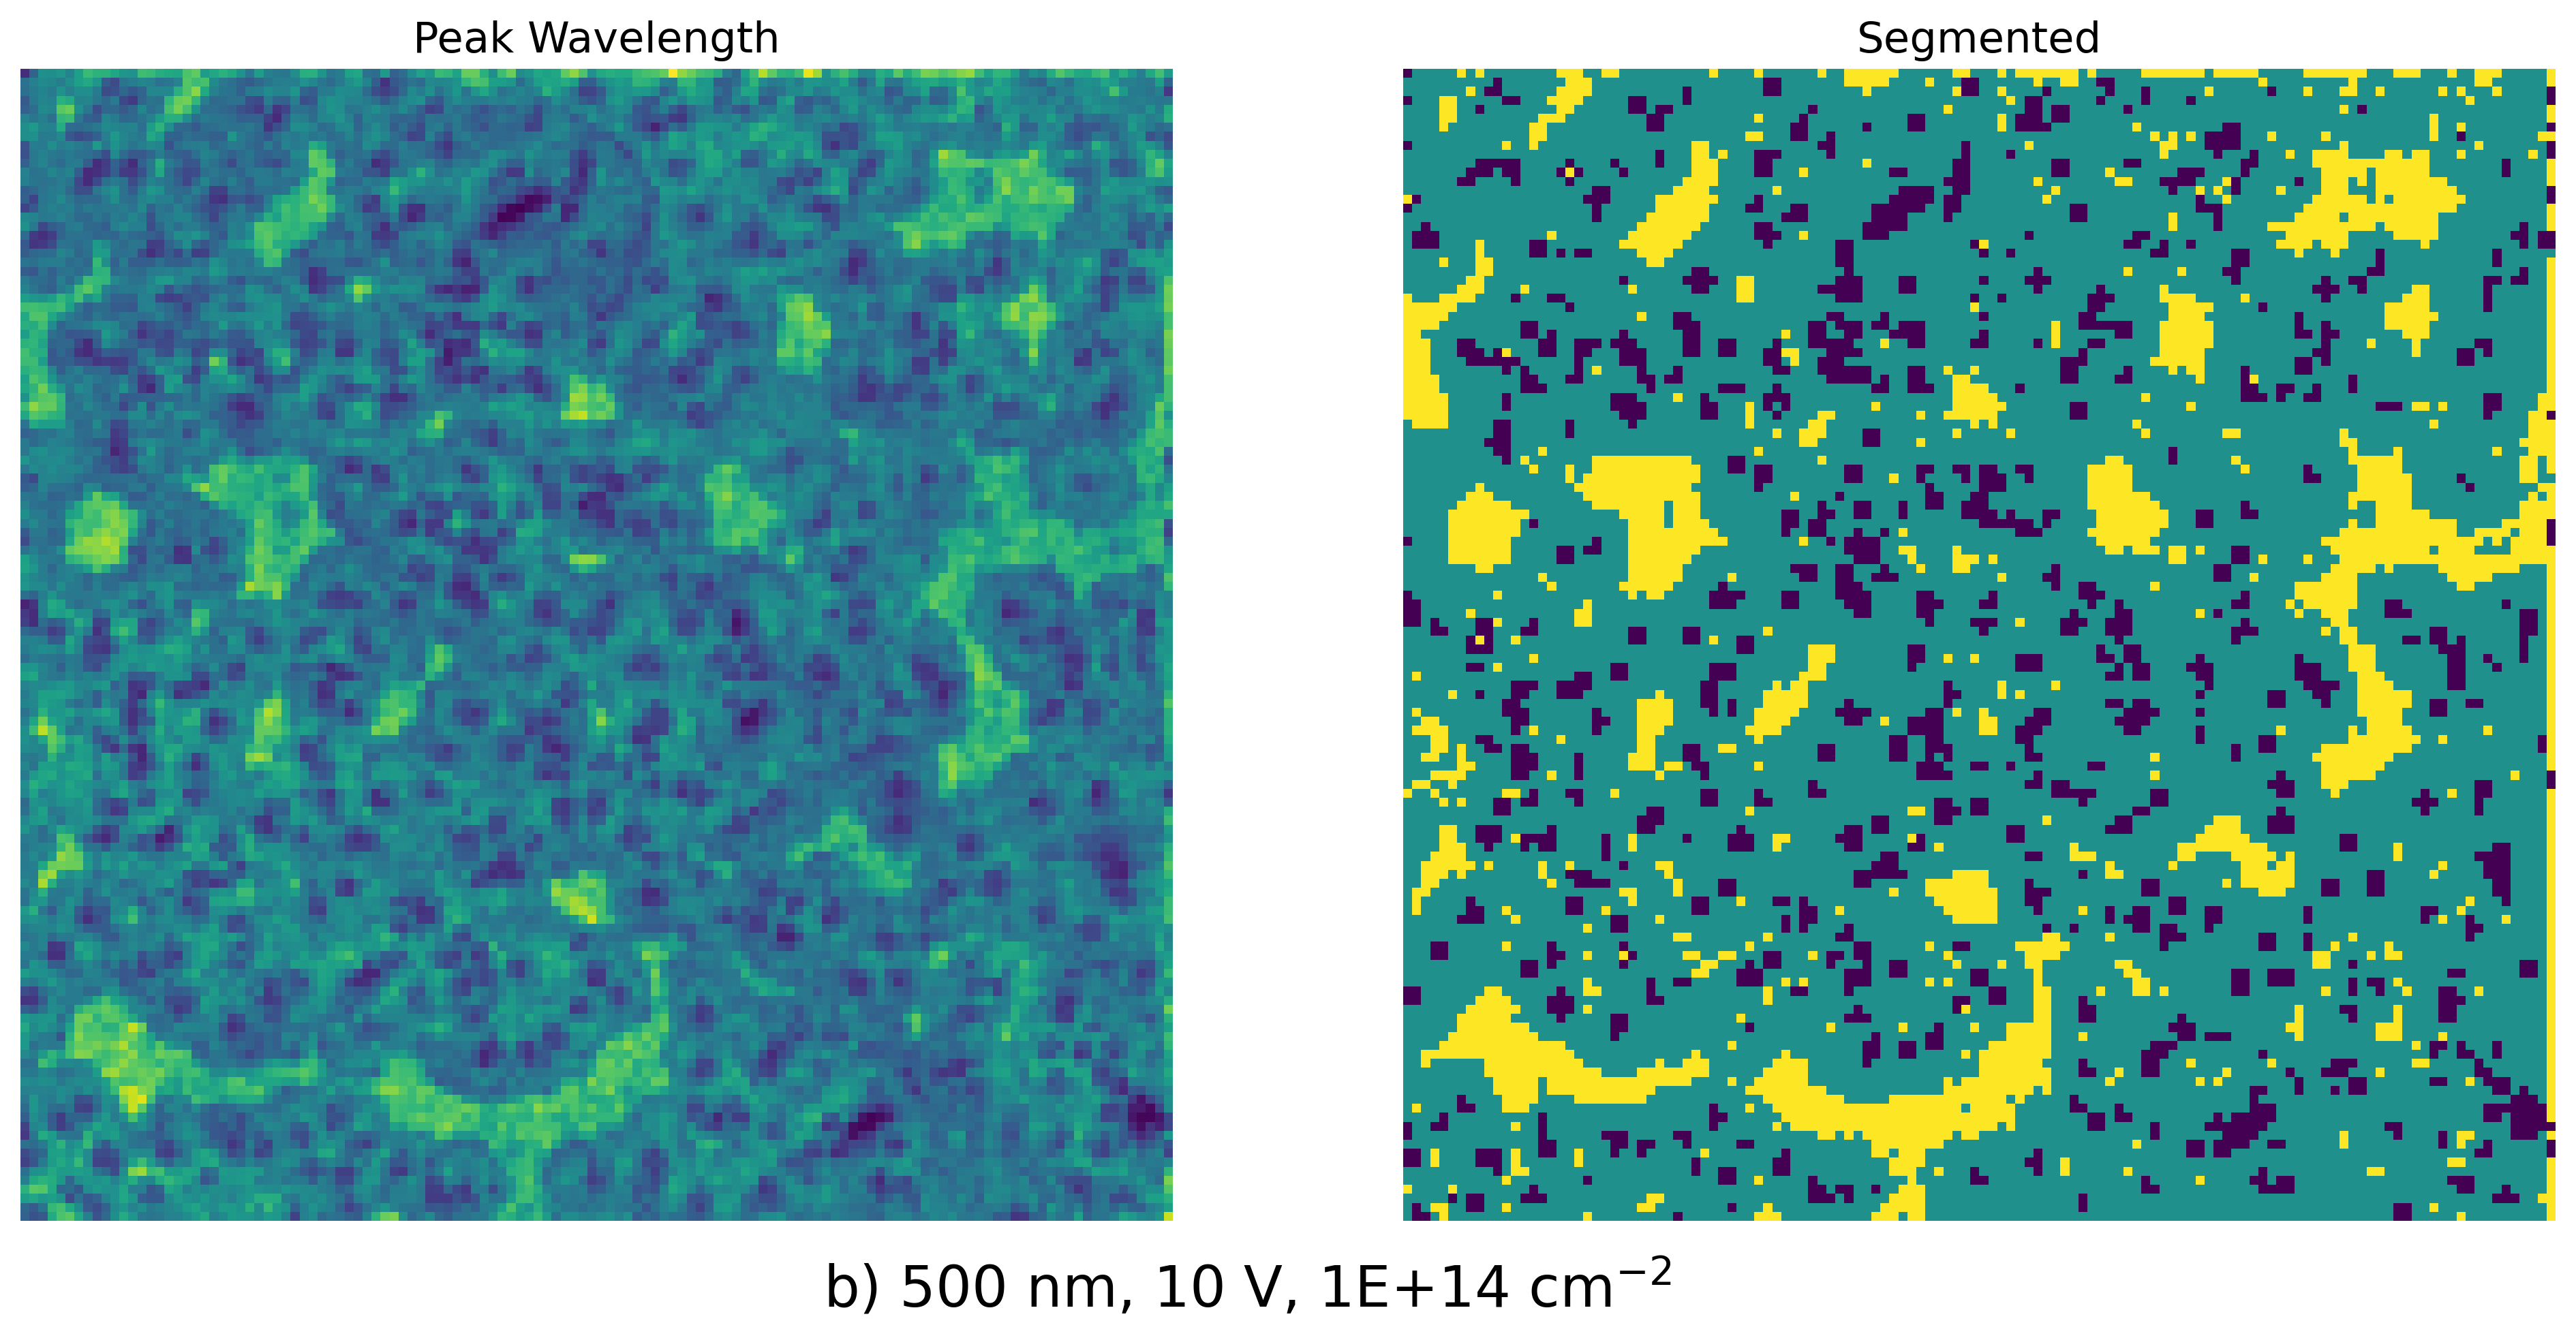

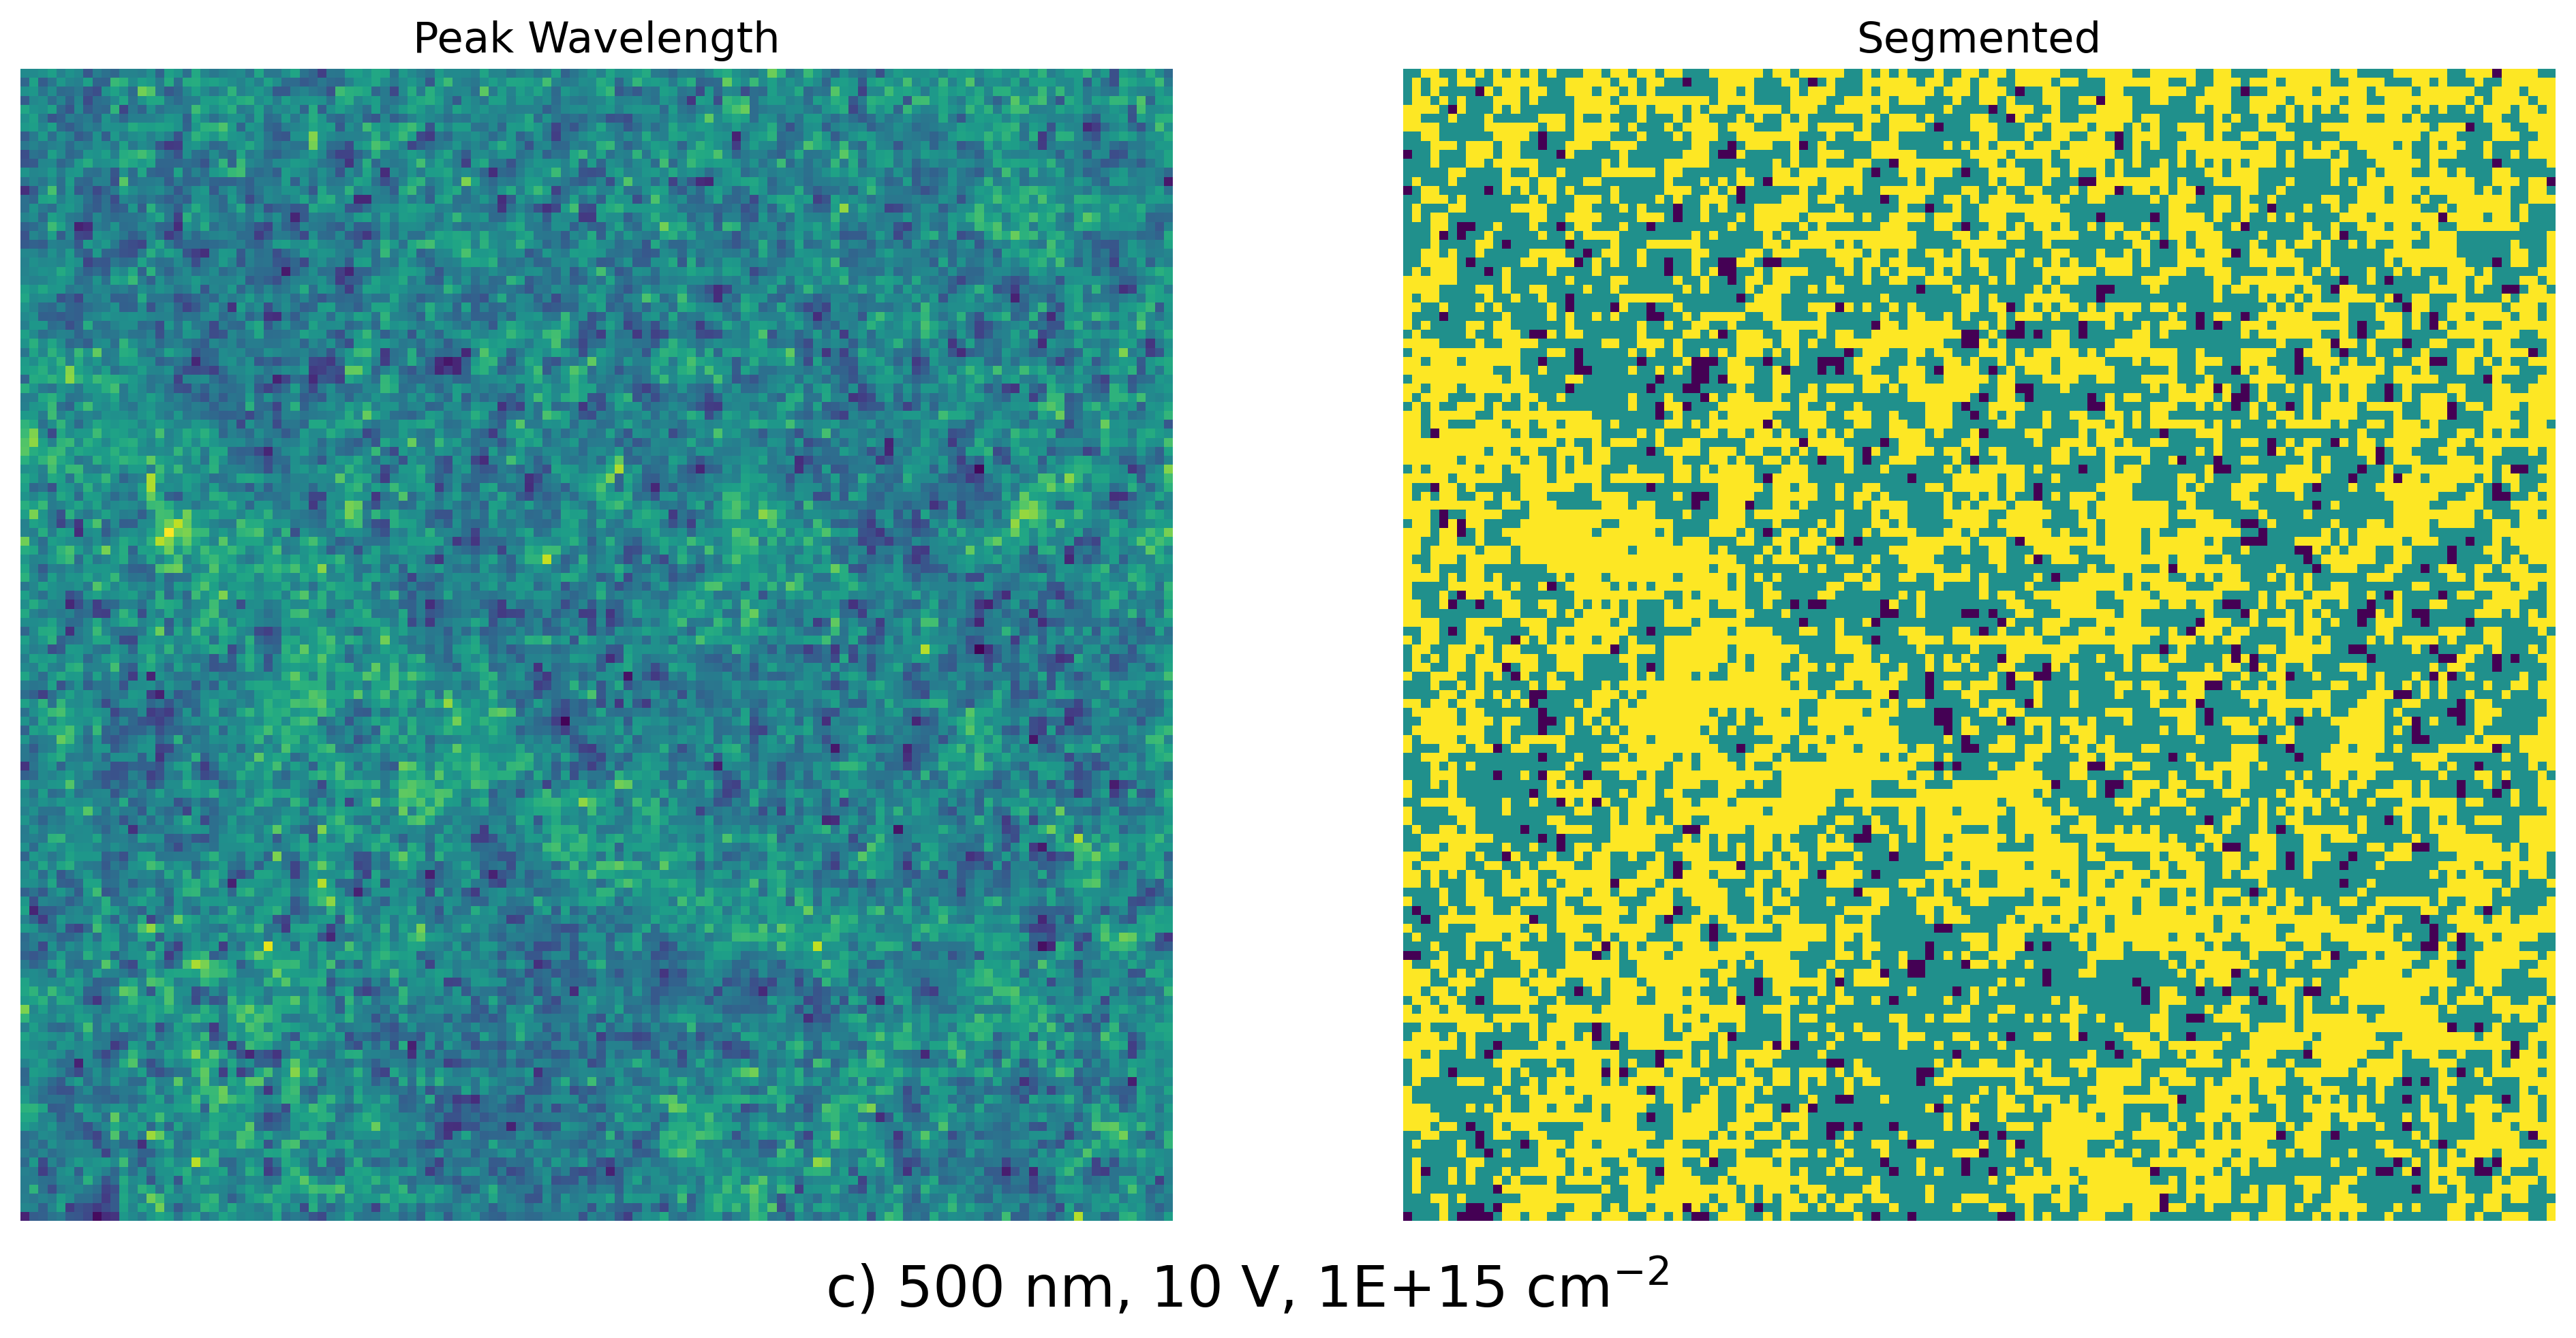

In [25]:
fg_size = (16,9)
fg_dpi = 300
ax_fsize = 20
tick_fsize = 15
leg_fsize = 15

i=0
for entry in mask_array[0:3]:

    sample, GaN_mask, NP_mask, P_mask = entry[0], entry[1], entry[2], entry[3]
    NP_mask = np.where(NP_mask == True, 2*np.ones(NP_mask.shape), np.zeros(NP_mask.shape))
    P_mask = np.where(P_mask == True, np.ones(P_mask.shape), np.zeros(P_mask.shape))
    # Plot segmentation results
    fig, axarr = plt.subplots(1,2, dpi=fg_dpi, figsize=fg_size)
    im0 = axarr[0].imshow(sample.CL_map.data[:,:,248])
    im1 = axarr[1].imshow(P_mask+NP_mask, cmap="viridis")
    #bar1=plt.colorbar(im1)
    axarr[0].set_title("Peak Wavelength", fontsize=tick_fsize)
    axarr[0].axis("off")
    axarr[1].set_title("Segmented", fontsize=tick_fsize)
    axarr[1].axis("off")
    alphabet = ["a","b","c"]
    
    fig.suptitle(alphabet[i] +") " + str(int(sample.porous_thickness)) + " nm, " + str(sample.etch_volt)+ " V, " +f"{sample.proton_fluence:.0E}" + " cm$^{-2}$", y=0.17, fontsize = ax_fsize)
    
    i+=1
    plt.savefig(sample.name+"Segmentation.png", bbox_inches='tight')
    

### Bandgap peak height

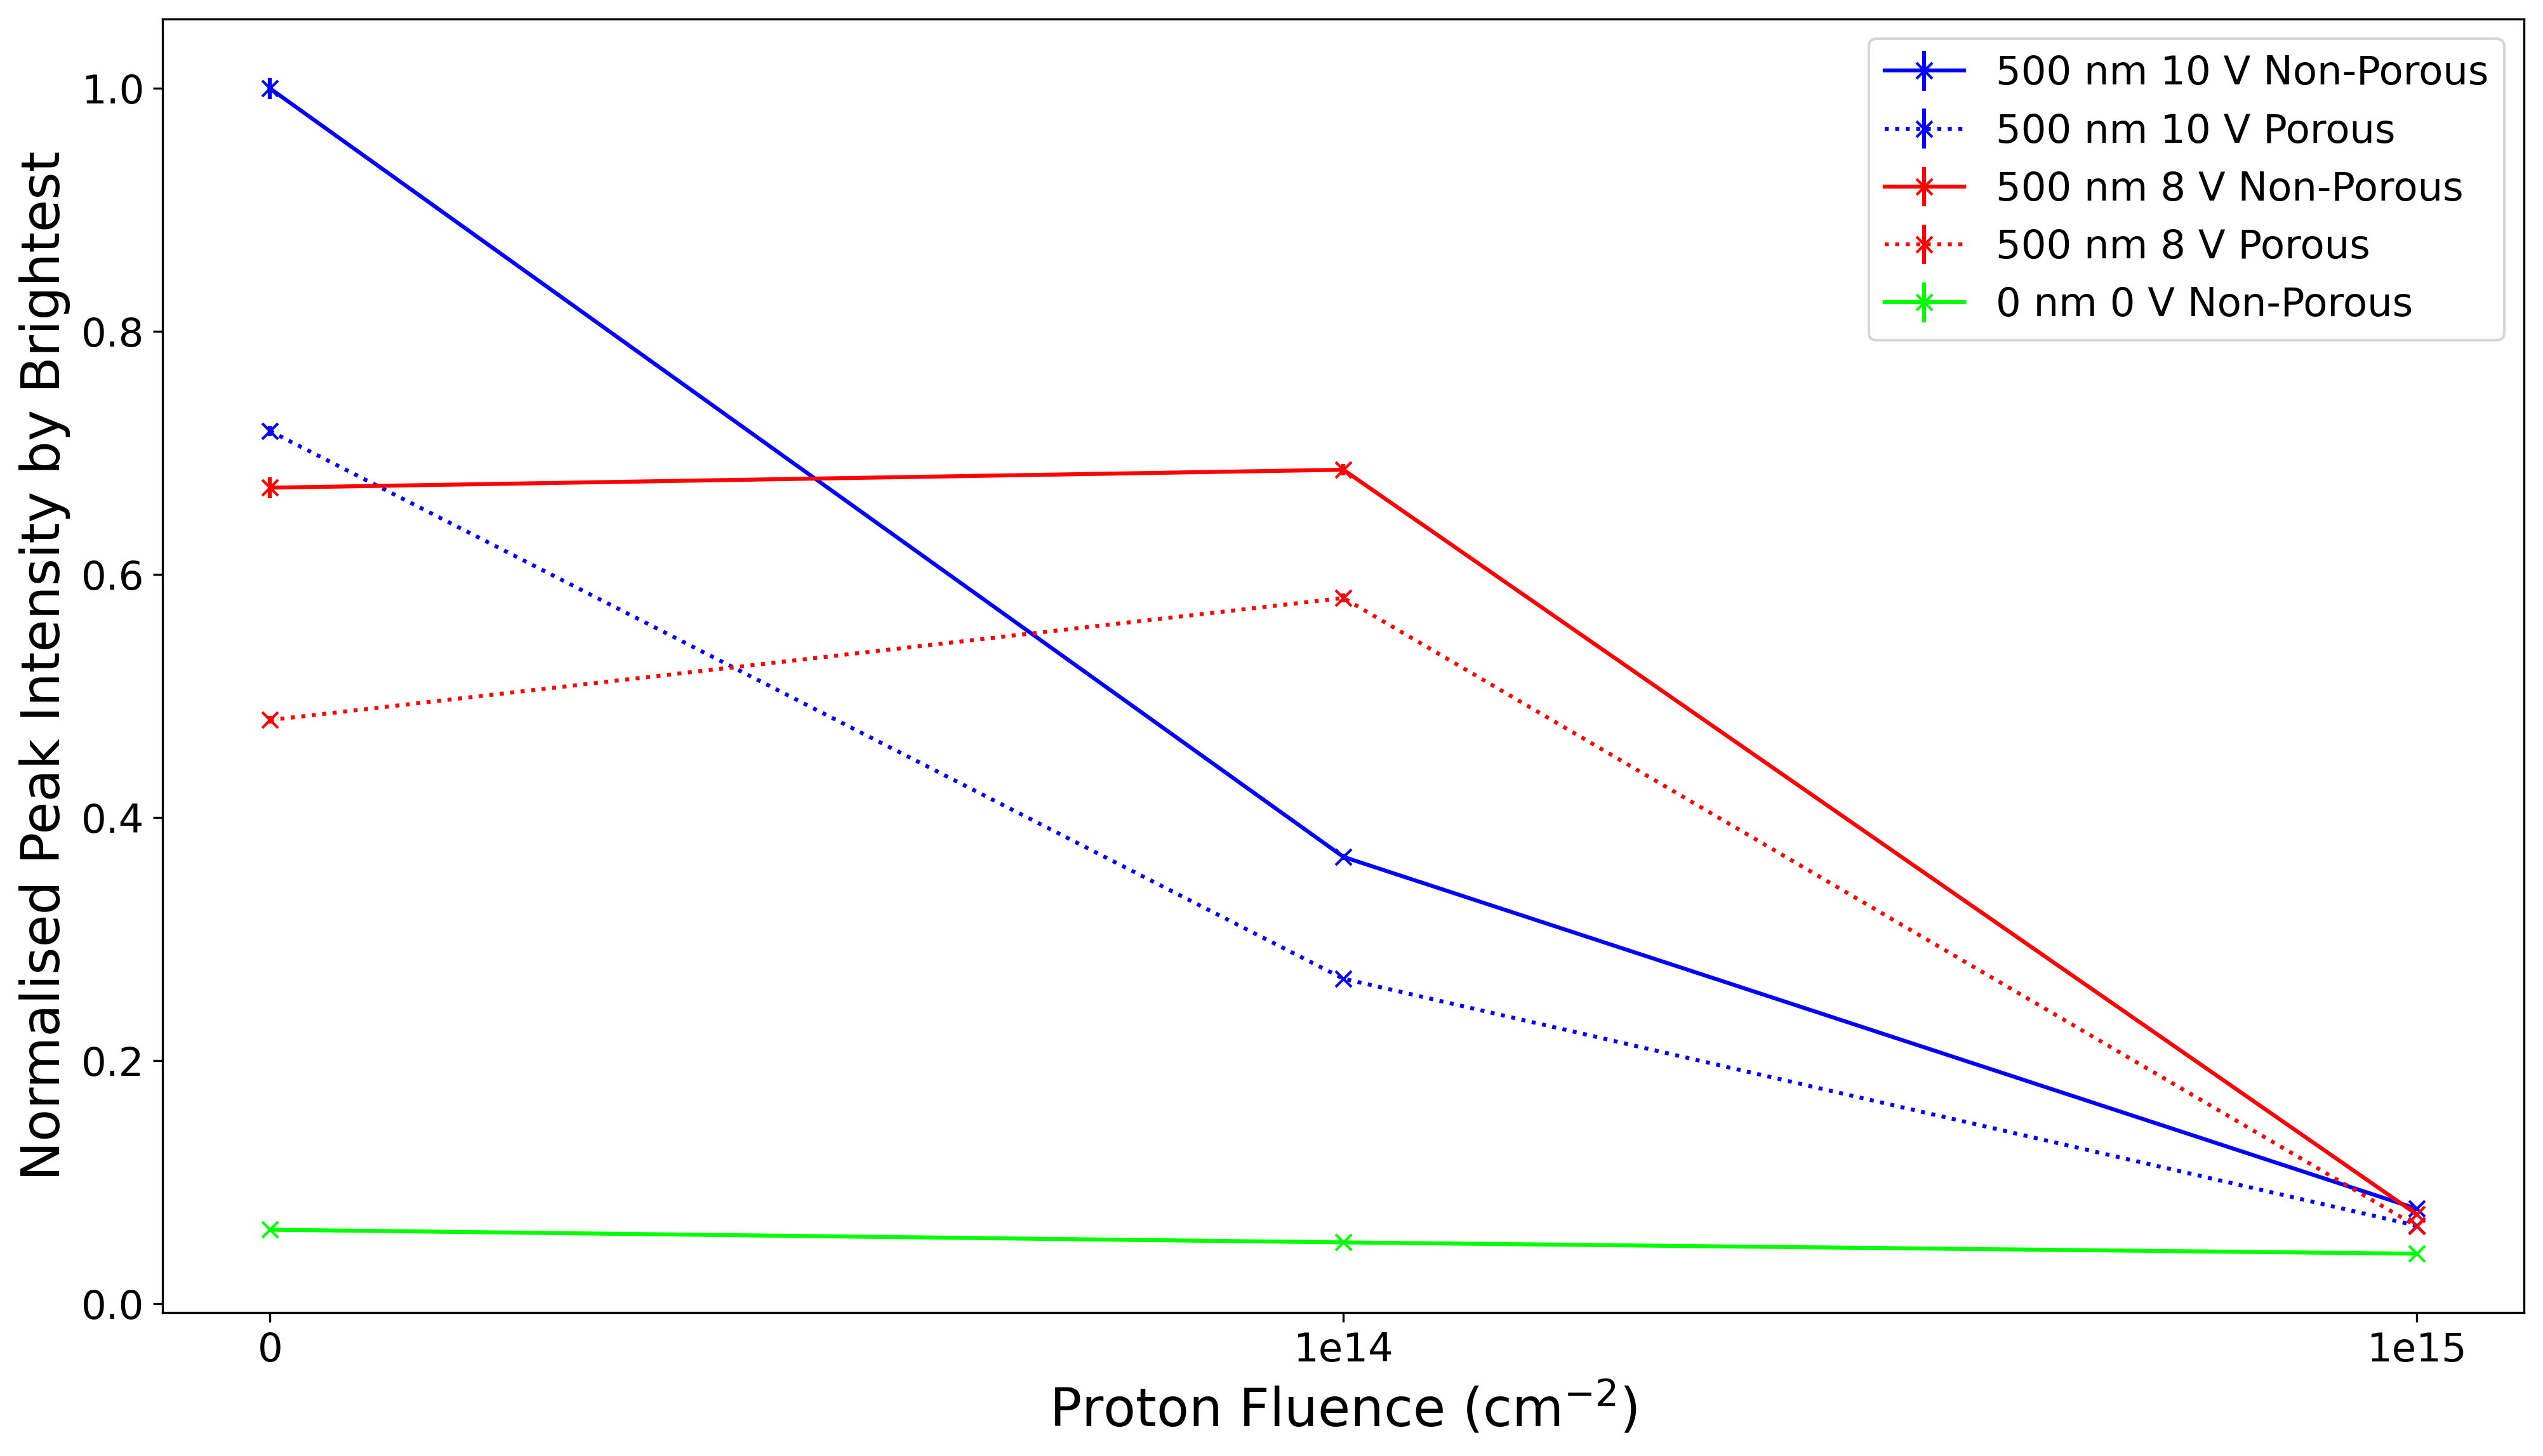

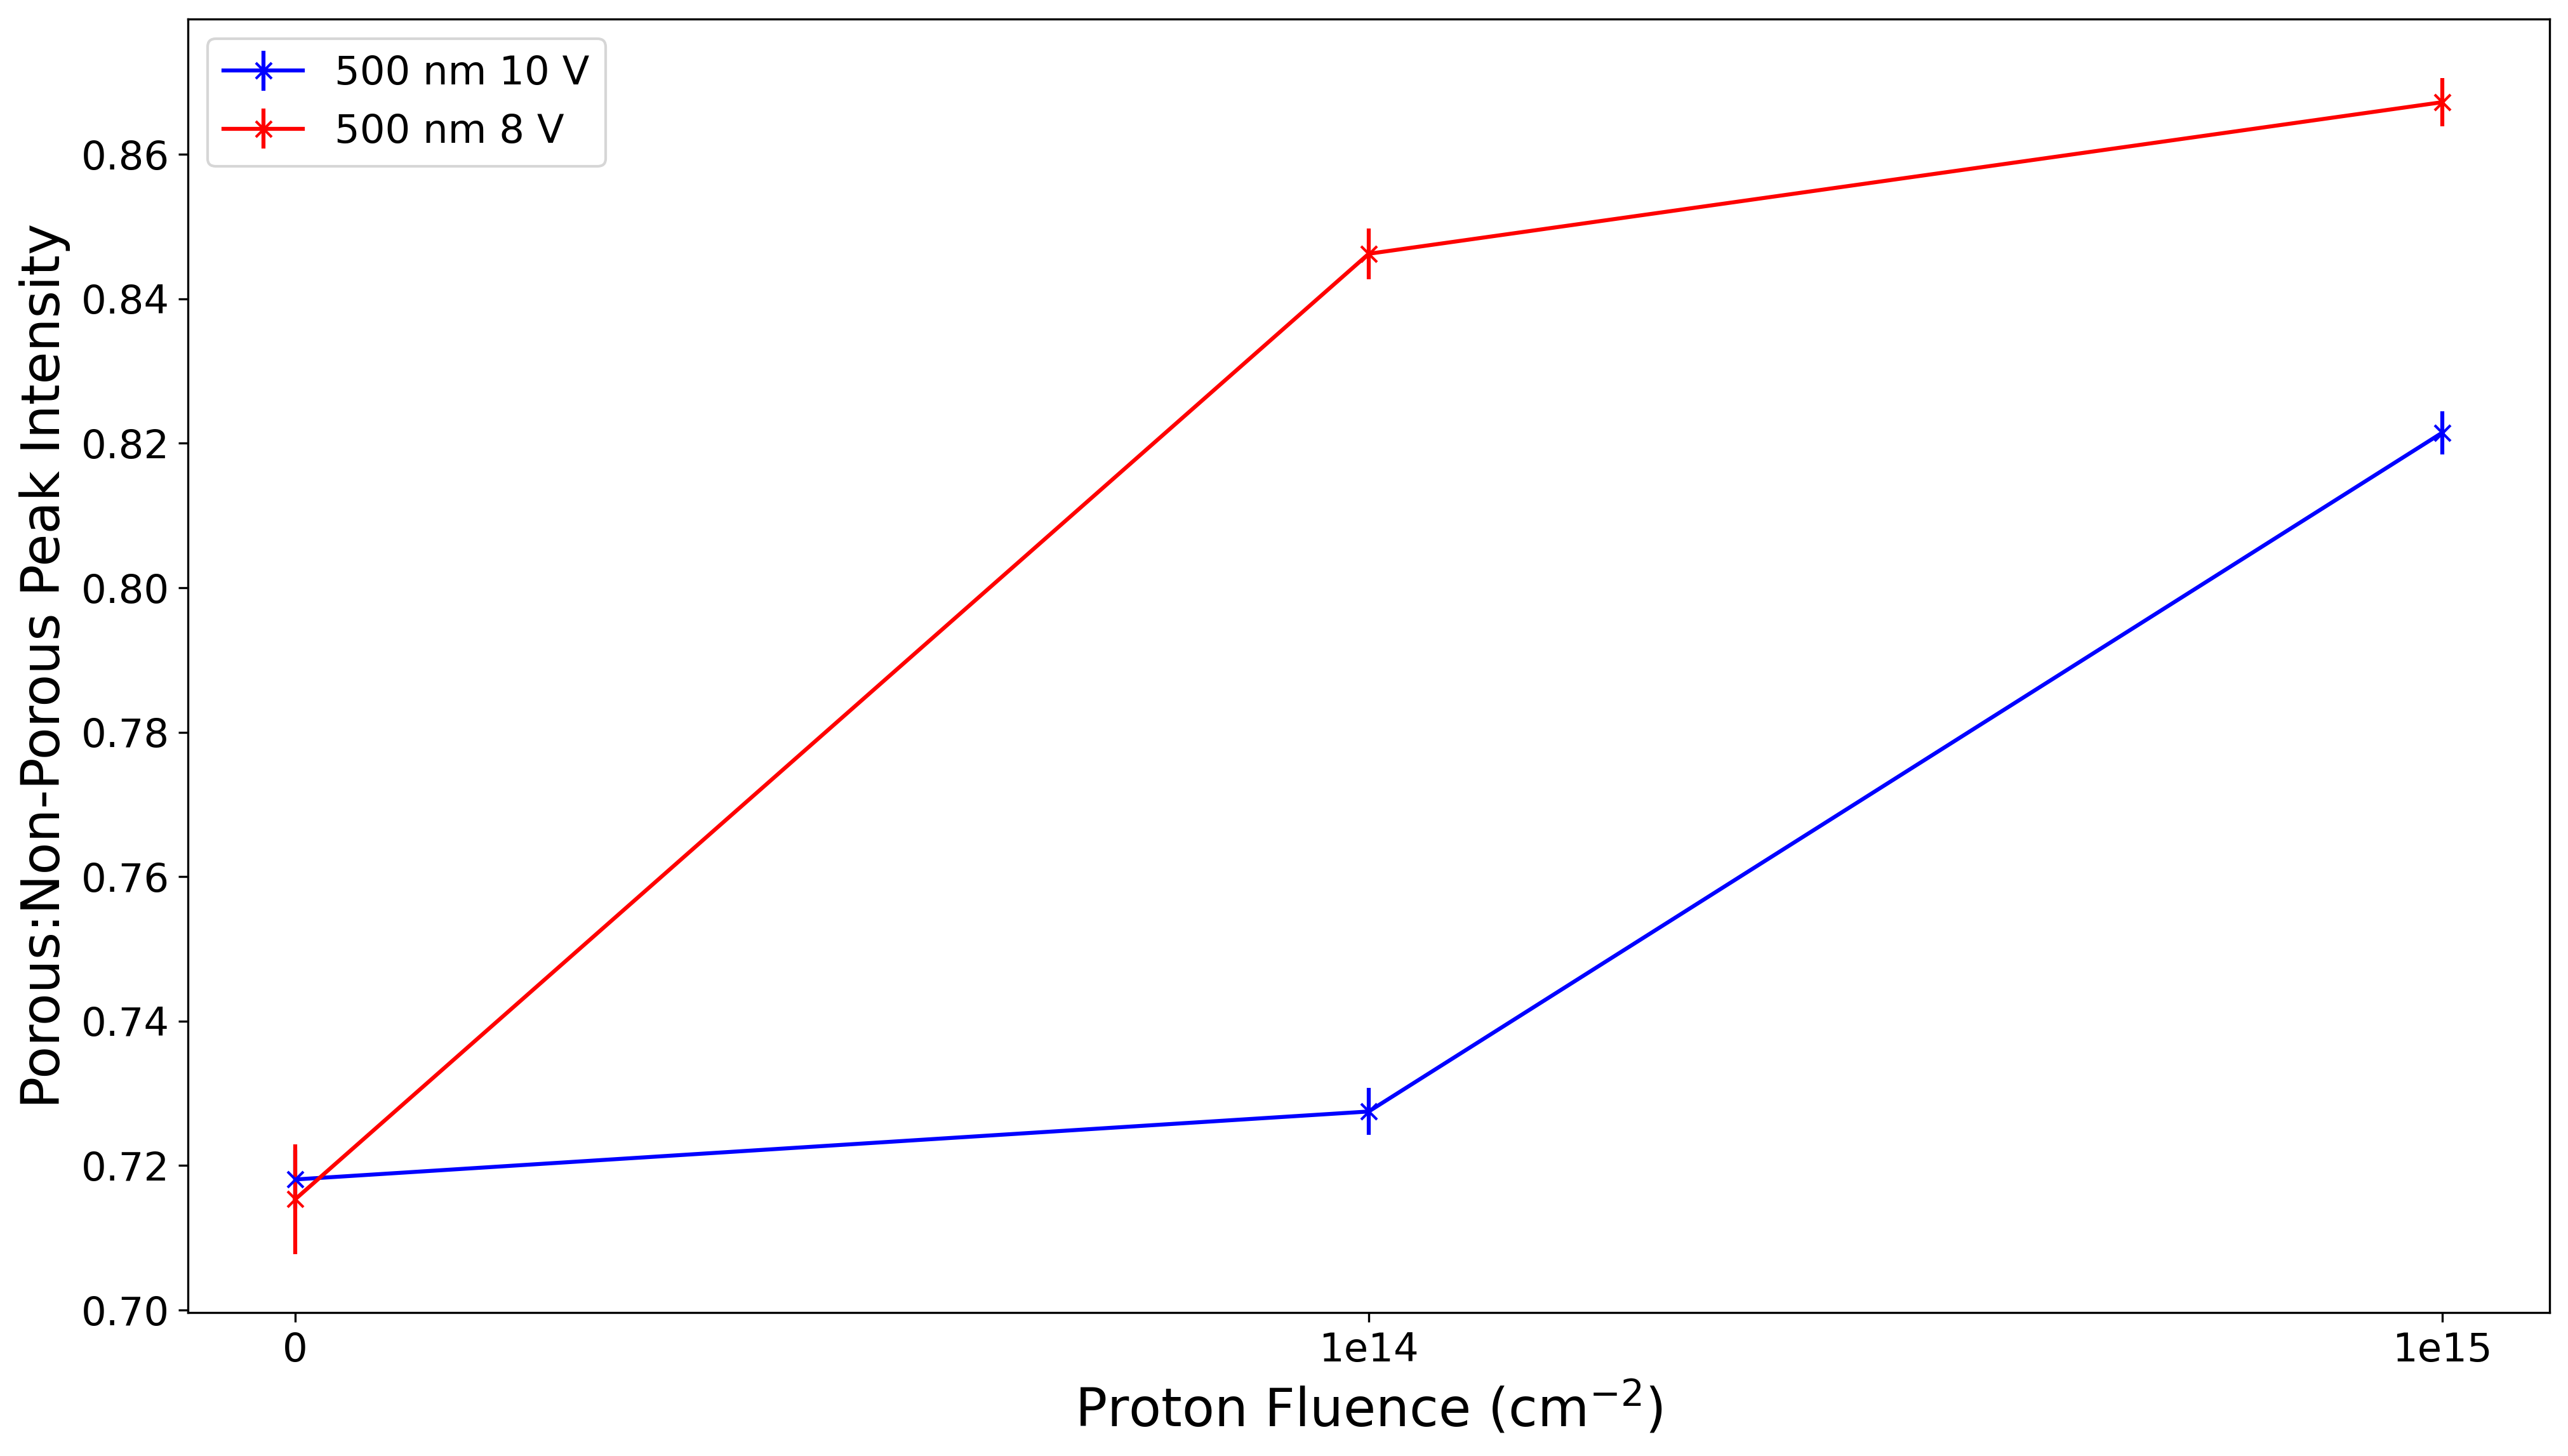

In [27]:
%matplotlib inline

fg_size = (16,9)
fg_dpi = 300
ax_fsize = 20
tick_fsize = 15
leg_fsize = 15

cmap = plt.cm.get_cmap('brg') # use any colormap you like
plt.figure(figsize=fg_size, dpi=fg_dpi)
plt.ylabel("Normalised Peak Intensity by Brightest", fontsize=ax_fsize)
plt.xlabel("Proton Fluence (cm$^{-2}$)", fontsize=ax_fsize)
i=0
for material in peak_values_df.drop(["Fluence"], axis=1).columns:
    if True in np.array(np.isnan(peak_values_df[material])):
        continue
    # plot normalised by all data
    
    # find max index assuming in no exposure
    max_idx = 0
    max_col = peak_values_df.idxmax(axis = 1, skipna = True)[max_idx]
    #print(peak_values_df.drop(["Fluence"], axis=1).max()[0]==peak_values_df[max_col][max_idx])
    
    norm_peak_vals = peak_values_df[material]/peak_values_df[max_col][max_idx]
    std_error = norm_peak_vals * ((std_error_values_df[material]/peak_values_df[material])+(std_error_values_df[max_col][max_idx]/peak_values_df[max_col][max_idx]))
    
    if i%2 == 0:
        col = cmap(i/(0.5*len(peak_values_df.drop("Fluence", axis=1).columns)))
        plt.errorbar([0,1,2],norm_peak_vals, yerr=std_error, label = material, linestyle="-", color=col, marker ="x")
    if i%2 == 1:
        col = cmap((i-1)/(0.5*len(peak_values_df.drop("Fluence", axis=1).columns)))
        plt.errorbar([0,1,2],norm_peak_vals, yerr=std_error, label = material, linestyle=":", color=col, marker ="x")
    i +=1
plt.xticks([0,1,2],["0","1e14","1e15"], fontsize = tick_fsize)
plt.yticks(fontsize = tick_fsize)
plt.legend(fontsize = leg_fsize, loc="best")
#plt.savefig("Normalised yellow peak intensity by bandgap peak.png", bbox_inches='tight')
        
# plt.figure()
# plt.ylabel("Normalised peak intensity by non-exposed peak")
# plt.xlabel("Proton fluence cm$^{-2}$")
# i=0
# for material in peak_values_df.drop(["Fluence"], axis=1).columns:
#     if True in np.array(np.isnan(peak_values_df[material])):
#         continue
#     # plot normalised by all data
    
#     if i%2 == 0:
#         col = cmap(i/(0.5*len(peak_values_df.drop("Fluence", axis=1).columns)))
#         plt.plot(peak_values_df[material]/peak_values_df[material][0], label = material, linestyle="-", color=col, marker ="x")
#     if i%2 == 1:
#         col = cmap((i-1)/(0.5*len(peak_values_df.drop("Fluence", axis=1).columns)))
#         plt.plot(peak_values_df[material]/peak_values_df[material][0], label = material, linestyle=":", color=col, marker ="x")
#     i +=1
# plt.xticks([0,1,2],["0","1e14","1e15"])
# plt.legend()

plt.figure(figsize=fg_size, dpi=fg_dpi)
plt.ylabel("Porous:Non-Porous Peak Intensity", fontsize=ax_fsize)
plt.xlabel("Proton Fluence (cm$^{-2}$)", fontsize = ax_fsize)
peak_pairs = []
i=0
# for material in peak_values_df.drop(["Fluence"], axis=1).columns[:4]:
#     if i%2 == 0:
#         previous = peak_values_df[material]
#     if i%2 == 1:
#         normalised = peak_values_df[material]/previous
        
#         col = cmap((i-1)/len(peak_values_df.drop(["Fluence"], axis=1).columns[:4]))
#         plt.plot(normalised, label = material[:-7], marker="x", color=col)
        
#     i += 1
    

for material in peak_values_df.drop(["Fluence"], axis=1).columns[:4]:
    if i%2 == 0:
        previous = peak_values_df[material]
        previous_err = std_error_values_df[material]
    if i%2 == 1:
        current = peak_values_df[material]
        current_err = std_error_values_df[material]
        normalised = current/previous
        normalised_err = normalised*((previous_err/previous)+(current_err/current))
        
        col = cmap((i-1)/len(peak_values_df.drop(["Fluence"], axis=1).columns[:4]))

        plt.errorbar([0,1,2],normalised, yerr=normalised_err, label = material[:-7], marker="x", color=col)
        
    i += 1
    
plt.xticks([0,1,2],["0","1e14","1e15"], fontsize = tick_fsize)
plt.yticks(fontsize = tick_fsize)
plt.legend(fontsize = leg_fsize, loc="best")
#plt.savefig("Normalised yellow peak intensity by bandgap peak.png", bbox_inches='tight')

### Yellow Defect Peak Height

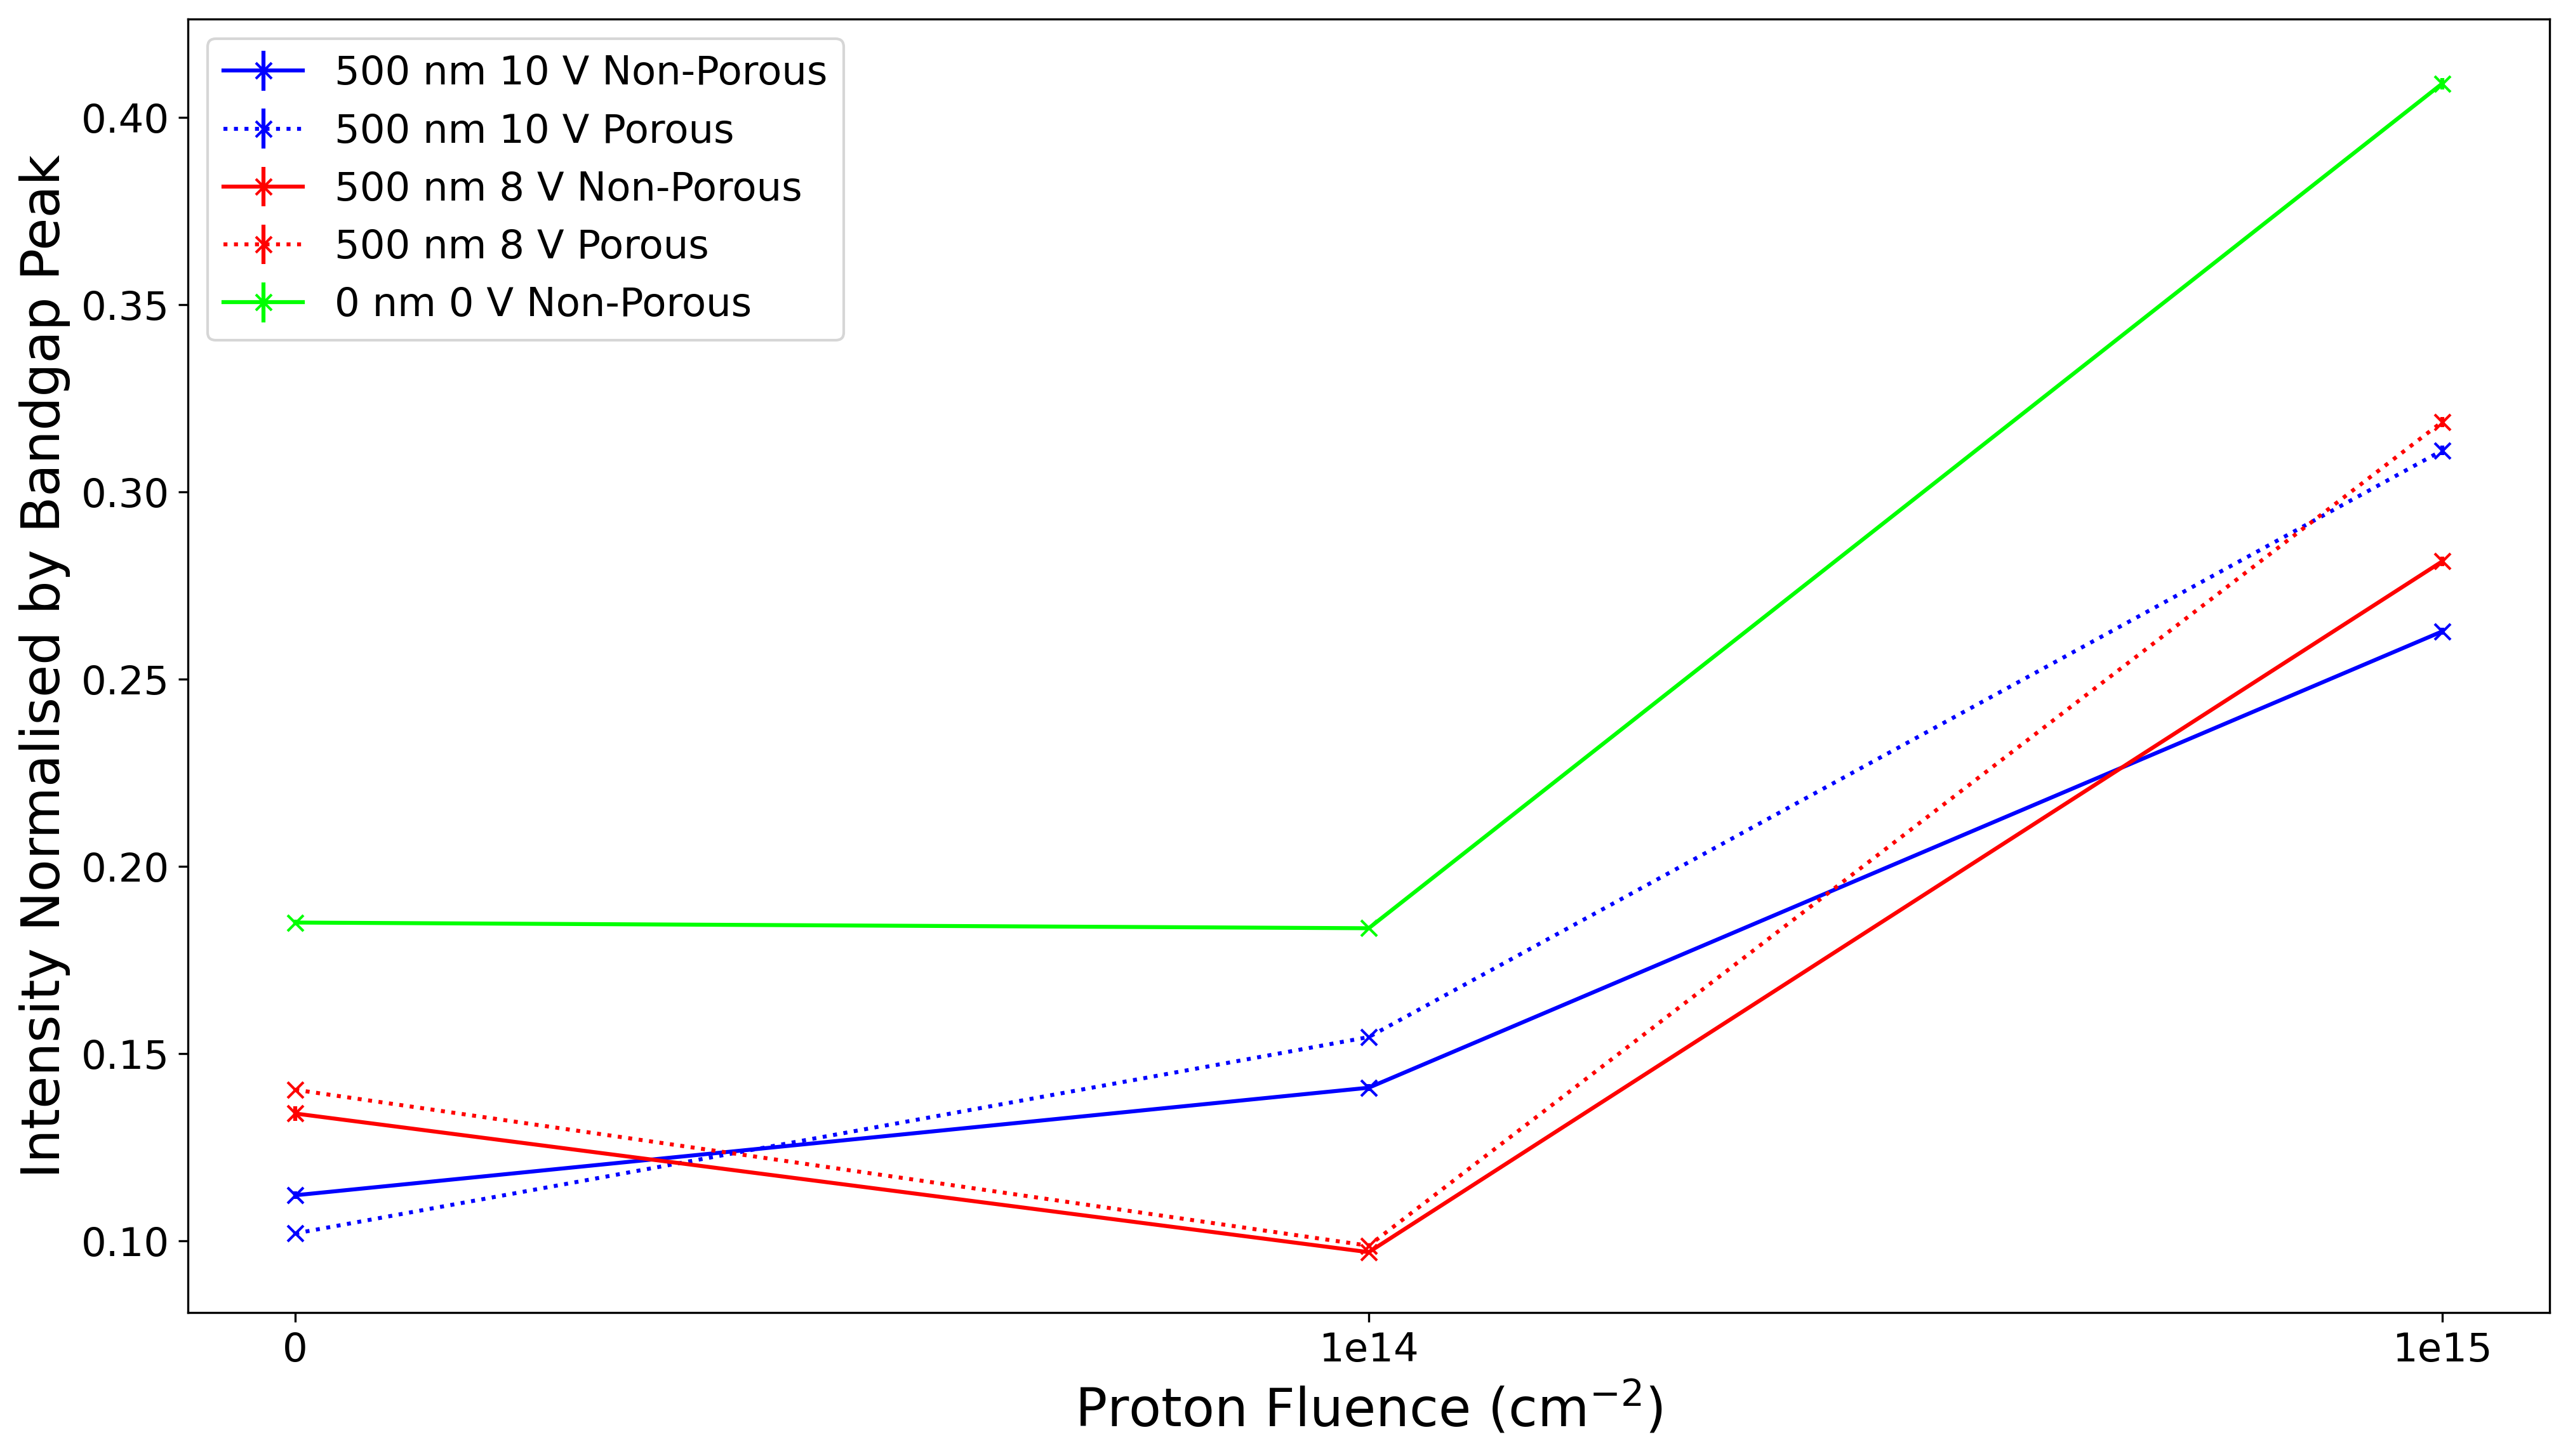

In [28]:
# plot normalised to main bandgap height


fg_size = (16,9)
fg_dpi = 300
ax_fsize = 20
tick_fsize = 15
leg_fsize = 15

cmap = plt.cm.get_cmap('brg') # use any colormap you like
plt.figure(figsize=fg_size, dpi=fg_dpi)
plt.ylabel("Intensity Normalised by Bandgap Peak", fontsize=ax_fsize)
plt.xlabel("Proton Fluence (cm$^{-2}$)", fontsize=ax_fsize)
i=0
for material in peak_values_df.drop(["Fluence"], axis=1).columns:
    if True in np.array(np.isnan(peak_values_df[material])):
        continue
    # plot normalised by all data
    
    norm_peak_vals = yellow_peak_values_df[material]/peak_values_df[material]
    std_error = norm_peak_vals * ((y_std_error_values_df[material]/yellow_peak_values_df[material])+(std_error_values_df[material]/peak_values_df[material]))
    
    if i%2 == 0:
        col = cmap(i/(0.5*len(peak_values_df.drop("Fluence", axis=1).columns)))
        plt.errorbar([0,1,2],norm_peak_vals, yerr=std_error, label = material, linestyle="-", color=col, marker ="x")
    if i%2 == 1:
        col = cmap((i-1)/(0.5*len(peak_values_df.drop("Fluence", axis=1).columns)))
        plt.errorbar([0,1,2],norm_peak_vals, yerr=std_error, label = material, linestyle=":", color=col, marker ="x")
    i +=1
plt.xticks([0,1,2],["0","1e14","1e15"], fontsize = tick_fsize)
plt.yticks(fontsize = tick_fsize)
plt.legend(fontsize = leg_fsize, loc="best")
plt.savefig("Normalised yellow peak intensity by bandgap peak.png", bbox_inches='tight')

## Panchromatic Images

In [66]:
folder = Path("C:/Users/es758/OneDrive - University of Cambridge/NanoDTC/Mini 2/CL/edward-300322/CL Maps")

# Everything in here has something weird with it, at least by the mean spectra
skipped_data = [
"HYP-500NMHVNE-3KV-10NA-30NM-1",
"HYP-500NMHVNE-3KV-10NA-30NM-390NM-G600-1",
"HYP-500NMHVNE-3KV-10NA-30NM-500NM-2-Z46",
"HYP-T0-3KV-10NA-25NM-1",
"HYP-T0-3KV-10NA-25NM-2"
]

skipped_data_path_list = [folder/skipped for skipped in skipped_data]
CL_data_list = [CL_data(data_folder) for data_folder in get_subfolders(folder) if (data_folder not in skipped_data_path_list)]
print("done")

Spectra has no Background file


  0%|          | 0/16384 [00:00<?, ?it/s]

Spectra has no Background file


  0%|          | 0/16384 [00:00<?, ?it/s]

Spectra has no Background file


  0%|          | 0/16384 [00:00<?, ?it/s]

Spectra has no Background file


  0%|          | 0/16384 [00:00<?, ?it/s]

Spectra has no Background file


  0%|          | 0/16384 [00:00<?, ?it/s]

Spectra has no Background file


  0%|          | 0/16384 [00:00<?, ?it/s]

Spectra has no Background file


  0%|          | 0/16384 [00:00<?, ?it/s]

Spectra has no Background file


  0%|          | 0/16384 [00:00<?, ?it/s]

Spectra has no Background file


  0%|          | 0/16384 [00:00<?, ?it/s]

Spectra has no Background file


  0%|          | 0/10000 [00:00<?, ?it/s]

done


In [67]:
for sample in CL_data_list:
    print(sample.name)

HYP-HYP-500NMHVLE-3KV-1NA-25NM-500NM-3
HYP-HYP-500NMHVNE-3KV-1NA-25NM-500NM-2
HYP-HYP-500NMHVNE-3KV-1NA-25NM-500NM-3
HYP-HYP-500NMLVHE-3KV-1NA-25NM-500NM-2-001
HYP-HYP-500NMLVLE-3KV-1NA-25NM-500NM-4
HYP-HYP-500NMLVNE-3KV-1NA-25NM-500NM-3
HYP-HYP-500NMNVNE-3KV-1NA-25NM-500NM-2
HYP-HYP-T0-3KV-1NA-25NM-500NM-2
HYP-HYP-T1-3KV-1NA-25NM-500NM-2
HYP-HYP-T1-3KV-1NA-25NM-500NM-3


In [85]:
i=4
print(CL_data_list[i].name)
CL_data_list[i].CL_map.plot()
CL_data_list[i].CL_map.T.plot()

HYP-HYP-500NMLVLE-3KV-1NA-25NM-500NM-4


In [38]:
panchrom_list = []
names = []
scale_list = []
for sample in CL_data_list:
    scale_list.append(sample.pixel_size_x)
    panchrom = sample.CL_map.mean((2)).data
    panchrom_list.append(panchrom)
    names.append(sample.name)

In [45]:
biggest0 = 0
current_biggest_index = 0
for pchromim in panchrom_list:
    biggest1 = np.max(pchromim)
    if biggest1>biggest0:
        biggest0 = biggest1
        biggest_index = current_biggest_index
    current_biggest_index += 1
#     print(biggest1)
# print(biggest0)
# print(biggest_index)

for i in np.arange(len(panchrom_list)):
    plt.figure(names[i])
    plt.imshow(panchrom_list[i], cmap='Greys_r')#, vmin=0, vmax=biggest0)
    plt.show()

# fig, axs = plt.subplots(nrows=3, ncols=2)
# for i in np.arange(3):
#     index_temp = i*2
#     for j in np.arange(2):
#         im = axs[i,j].imshow(panchrom_list[index_temp], cmap='Greys_r', vmin=0, vmax=biggest0)
#         axs[i,j].set_title(label=names[index_temp], fontsize =5)
        
#         sb_len = 40 # for now this seems to be pixels
        
#         scalebar = AnchoredSizeBar(axs[0,0].transData,
#                            sb_len, f'{round(sb_len*scale_list[index_temp])} nm', 'lower center', 
#                            pad=0.1,
#                            color='red',
#                            frameon=False,
#                            size_vertical=1)
        
#         axs[i,j].add_artist(scalebar)
        
        
#         index_temp += 1
#         if i == biggest_index:
#             legend_map = im
        
#         axs[i, j].axis("off")
#     #
# fig.subplots_adjust(wspace=0, hspace=0.2) # imshow increases width with padding unless specify size so can't get flush

#fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# fig.colorbar(legend_map, cax=cbar_ax)

In [53]:
CL_data_list[5].CL_map.T.plot()

## Manually Selected Spot Spectra

In [18]:
def click_point_detection(im):
    """ 
    Convenient function for selecting points.
    Opens user input to manually click out points (in index positions) to extract coordinates of interest.
    Currently have set max as 10 points.
    """
    # Show image
    plt.imshow(im,cmap='Greys_r')
    plt.axis('off')
    all_points = []
    # Get user input
    plt.title('Left click to add a point (max 10)\
    \n Middle click to remove a point (Use when zooming) \
    \n Finish by right clicking',fontsize=8)
    points = plt.ginput(n=10, timeout=0, show_clicks=True,mouse_stop=3,mouse_pop=2)
    all_points.append(points)     
    plt.close()
    
    # convert to indices
    all_points=np.array(all_points)
    all_points=np.rint(all_points)
    all_points=all_points.astype(int)
    all_points=all_points[0]

    return all_points

def extract_point_spec(CL_data_object, point):
    x=point[0]
    y=point[1]
    spectra = CL_data_object.CL_map.data[y][x]
    return spectra

Sorry/not sorry but for the below I have referred to regions we think are less porous as white and those we think are more porous as grey.

In [50]:
# points_list = []
# for i in np.arange(len(CL_data_list)):
#     white = click_point_detection(panchrom_list[i])
#     grey = click_point_detection(panchrom_list[i])
#     points_list.append([white,grey])

In [52]:
#np.save('bright and darker points', points_list)

In [15]:
points_list = np.load('bright and darker points.npy')

In [19]:
scan_index=0
average_spectra = []
for scan in points_list:
    white_points = scan[0]
    grey_points = scan[1]
    
    average_white=np.zeros(len(extract_point_spec(CL_data_list[scan_index], white_points[0])))
    for point in white_points:
        average_white+=extract_point_spec(CL_data_list[scan_index], point)
    average_white /= len(white_points)
    
    average_grey=np.zeros(len(extract_point_spec(CL_data_list[scan_index], grey_points[0])))
    for point in grey_points:
        average_grey+=extract_point_spec(CL_data_list[scan_index], point)
    average_grey /= len(grey_points)
    
    average_spectra.append([average_white, average_grey])
    
    scan_index+=1

Plot white and grey average spectra for comparison

In [28]:
cmap = plt.cm.get_cmap('hsv') # use any colormap you like

for i in np.arange(len(average_spectra)):
    col = cmap(i/len(average_spectra)) # cmap takes float between 0 & 1 and returns corresponding color
    plt.plot(average_spectra[i][0], label="white " + CL_data_list[i].name, color=col, linestyle="-")
    plt.plot(average_spectra[i][1], label="grey " + CL_data_list[i].name, color=col, linestyle="--")
plt.legend()

Plot ratio of white bandgap emission to grey bandgap emission

In [26]:
for i in np.arange(len(average_spectra)):
    white = average_spectra[i][0].copy()
    grey = average_spectra[i][1].copy()
    ratio = np.max(grey)/np.max(white)
    plt.bar(i, ratio, label = CL_data_list[i].name)
plt.ylabel("Porous bandgap emission : Less-porous bandgap emission")
plt.legend()

In [11]:
%matplotlib qt

In [61]:
a=(np.zeros(3)+np.array([1,2,3]))
a/=2
a

array([0.5, 1. , 1.5])

## Bandpass

In [47]:
im = CL_data_list[2].CL_map.T
im.plot()

roi1 = hs.roi.SpanROI(left=300, right=400)      #sets a digitalbandfilter
im_roi1 = roi1.interactive(im, color="red")
roi2 = hs.roi.SpanROI(left=400, right=500)      #sets another digitalbandfilter
im_roi2 = roi2.interactive(im, color="blue")
roi3 = hs.roi.SpanROI(left=500, right=600)      #sets another digitalbandfilter
im_roi3 = roi3.interactive(im, color="green")

roi1(im).T.plot( navigator_kwds=dict(colorbar=True,
                             scalebar_color='black',
                             cmap='Reds_r'))

roi2(im).T.plot( navigator_kwds=dict(colorbar=True,
                             scalebar_color='black',
                             cmap='Blues_r'))

roi3(im).T.plot( navigator_kwds=dict(colorbar=True,
                            scalebar_color='black',
                            cmap='Greens_r'))

In [49]:
im.plot()

In [48]:
%matplotlib qt